In [1]:
import numpy as np
from scipy.stats import unitary_group, ortho_group, special_ortho_group

import random
from random import choices

from functools import partial
from itertools import product, combinations, combinations_with_replacement
from opt_einsum import contract

import tensorcircuit as tc
import qutip as qt

import jax
import jax.numpy as jnp
import jax.random as jrand

import time
import os

import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib import rc
rc('text', usetex=True)
rc('font', size=25)
rc('axes', linewidth=3)
rc('text.latex', preamble=r'\usepackage{amsfonts}\usepackage{bm}')

K = tc.set_backend('jax')
tc.set_dtype('complex128')

Please first ``pip install -U qiskit`` to enable related functionality in translation module
Please first ``pip install -U cirq`` to enable related functionality in translation module


('complex128', 'float64')

# Functions for training

In [2]:
def label2Pauli(label):
    # transform a string to a Pauli operator
    paulis = [qt.qeye(2), qt.sigmax(), qt.sigmay(), qt.sigmaz()]
    if type(label)==int:
        P = paulis[label]
    else:
        P = qt.tensor([paulis[x] for x in label])
    return P

def circuitBlockPrepare(n, L):
    # generate the Paulis and entangling layers unitary using in RPA
    random.seed(22)
    Pauligroup = list(product(range(1,4), repeat=n))
    Plabels = np.array(choices(Pauligroup, k=L), dtype=int)
    np.random.seed(22)
    Ws = unitary_group.rvs(dim=2**n, size=L)
    return Plabels, Ws

In [3]:
def RPA_ypred(weights, input, n, Xs, Ws):
    L = len(weights)
    c = tc.Circuit(n, inputs=input)
    for l in range(L):
        c.exp1(*range(n), theta=weights[l], hermitian=Xs[l], half=True)
        c.any(*range(n), unitary=Ws[l])
    return K.real(c.expectation((tc.gates.z(), [0])))

In [ ]:
def RPAtraining(n, L, batch, eta, steps, data, targets, intercept=100, display_time=100):
    ndata = len(targets)
    
    key = jrand.PRNGKey(42)
    thetas = jrand.uniform(key, shape=(batch, L))*(2.*np.pi)

    labels, Ws = circuitBlockPrepare(n, L)
    Xs = [label2Pauli(x).full() for x in labels]

    ypred_vag = K.jit(K.value_and_grad(partial(RPA_ypred, n=n, Xs=Xs, Ws=Ws)))
    ypred_vvag = K.jit(K.vmap(ypred_vag, vectorized_argnums=1))
    ypred_vvag_batch = K.jit(K.vmap(ypred_vvag, vectorized_argnums=0))

    eps_hist = jnp.zeros((steps, batch, ndata))
    J_hist = jnp.zeros((steps, batch, ndata, L))
    thetas_hist = jnp.zeros((steps//intercept+1, batch, L))
    
    t0 = time.time()
    for step in range(steps):
        ys, Js = ypred_vvag_batch(thetas, data)
        epss = ys - targets

        grad_loss = contract('ra, rai->ri', epss, Js)/ndata
        
        eps_hist = eps_hist.at[step].set(epss)
        J_hist = J_hist.at[step].set(Js)

        if step % intercept == 0:
            thetas_hist = thetas_hist.at[step//intercept].set(thetas)

        thetas = thetas - eta* grad_loss
        if step % display_time == 0:
            print(f"Step {step}, loss: {0.5*jnp.mean(epss**2, axis=1)}, time elapsed: {time.time()-t0} seconds")
    
    return eps_hist, J_hist, thetas_hist

In [185]:
def hessianCal(thetas, data, n, L):
    labels, Ws = circuitBlockPrepare(n, L)
    Xs = [label2Pauli(x).full() for x in labels]

    ypred_g = K.jit(K.grad(partial(RPA_ypred, n=n, Xs=Xs, Ws=Ws)))
    ypred_h = K.jit(jax.jacfwd(ypred_g))
    ypred_vh = K.jit(K.vmap(ypred_h, vectorized_argnums=1))
    ypred_vh = K.jit(K.vmap(ypred_vh, vectorized_argnums=0))

    return ypred_vh(thetas, data)

In [ ]:
n = 3
L = 80
ndata = 4
batch = 5

np.random.seed(42)
U = unitary_group.rvs(2**n)
inputs = jnp.array(U[:, :ndata].T)
ys = jnp.array([4]*(ndata//2) + [-4]*(ndata//2))

steps = 4001

res = RPAtraining(n, L, batch, 0.001, steps, inputs, ys, mu_flag=False)

# Functions for unification theory

In [2]:
def ldaUT(K, mu):
    Kdiag_sqrtinv = np.diag(1./np.sqrt(np.diag(K)))
    lda = contract('ij, jkl, lm->ikm', Kdiag_sqrtinv, mu, Kdiag_sqrtinv)
    return lda

def KoffdiagRatio(K):
    B = np.zeros_like(K)
    for i in range(len(K)):
        B[i] = K[i] / np.sqrt(K[i, i] * np.diag(K))
    return B

# Single-phase results & QNTK-based theories

## Inside

In [ ]:
steps = 60001

J_hist = np.load('data/training/n4/orth_data/ndata2/L48/RPASlJhist_n4L48_0.3_-0.5.npy')
K_hist = contract('trai, trbi->trab', J_hist, J_hist)
H_hist = np.load('data/training/n4/orth_data/ndata2/L48/RPASlHhist_n4L48_0.3_-0.5.npy')
mu_hist = contract('trai, trbij, trcj->trabc', J_hist[::steps//50], H_hist, J_hist[::steps//50])

np.save('data/training/n4/orth_data/ndata2/L48/RPASlKhist_n4L48_0.3_-0.5.npy', K_hist)
np.save('data/training/n4/orth_data/ndata2/L48/RPASlmuhist_n4L48_0.3_-0.5.npy', mu_hist)

### hessian

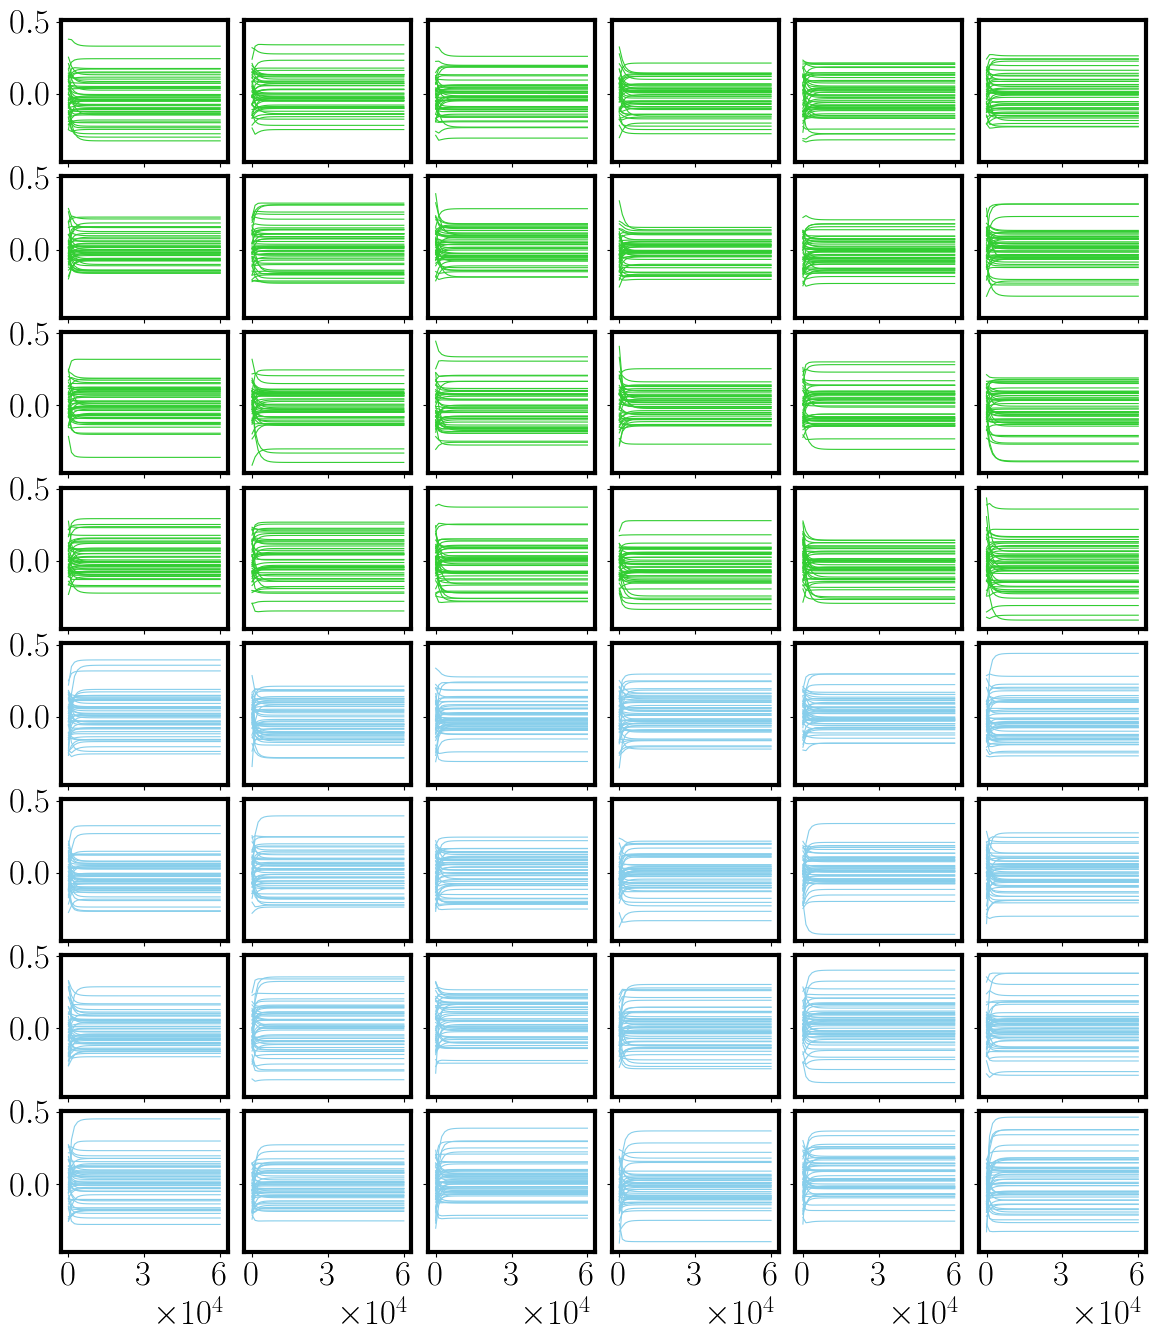

In [ ]:
steps = 60001
ts = np.arange(0, steps, steps//50)
L = 48
H_hist = np.load('data/training/n4/orth_data/ndata2/L48/RPASlHhist_n4L48_0.3_-0.5.npy')

idx = 5
H_hist_plot = [H_hist[:, idx, 0, x, y] for x in range(48) for y in range(x, 48)] + \
            [H_hist[:, idx, 1, x, y] for x in range(48) for y in range(x, 48)]
H_hist_plot = np.stack(H_hist_plot).T

num = L*(L-1)//2 + L

fig, axs = plt.subplots(8, 6, figsize=(14, 16), sharex=True, sharey=True)

for i in range(24):
    axs[i//6, i%6].plot(ts, H_hist_plot[:, num//24*i: num//24*(i+1)], c='limegreen', lw=0.8)
    axs[4+i//6, i%6].plot(ts, H_hist_plot[:, num + num//24*i: num + num//24*(i+1)], c='skyblue', lw=0.8)
axs[-1,0].set_xticks(np.arange(3)*3e4)
axs[-1,0].ticklabel_format(axis='x', style='sci', scilimits=(0,0))
plt.subplots_adjust(hspace=0.1, wspace=0.1)
#plt.tight_layout()

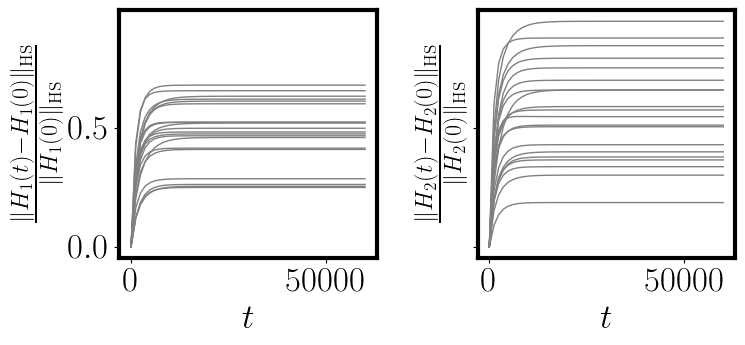

In [95]:
steps = 60001
ts = np.arange(0, steps, steps//50)

H_hist = np.load('data/training/n4/orth_data/ndata2/L48/RPASlHhist_n4L48_0.3_-0.5.npy')

fig, axs = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)
for i in range(2):
    axs[i].plot(ts, np.linalg.norm(H_hist[:,:,i]-H_hist[0,:,i], axis=(2, 3))\
                /np.linalg.norm(H_hist[0, :, i], axis=(1, 2)), c='grey', lw=1)
    axs[i].set_ylabel(fr'$\frac{{\|H_{{{i+1}}}(t) - H_{{{i+1}}}(0)\|_{{\rm HS}}}}{{\|H_{{{i+1}}}(0)\|_{{\rm HS}}}}$')
    axs[i].set_xlabel(r'$t$')
plt.tight_layout()

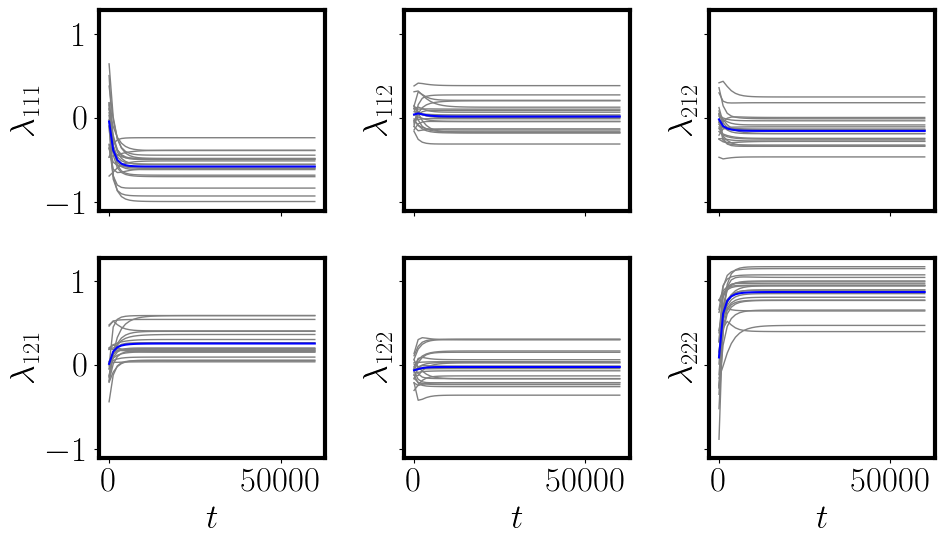

In [4]:
steps = 60001
ts = np.arange(0, steps, steps//50)

K_hist = np.load('data/training/n4/orth_data/ndata2/L48/RPASlKhist_n4L48_0.3_-0.5.npy')[::steps//50]
mu_hist = np.load('data/training/n4/orth_data/ndata2/L48/RPASlmuhist_n4L48_0.3_-0.5.npy')

lda_hist = np.zeros((51, 20, 2, 2, 2))
for i in range(51):
    for k in range(20):
        lda_hist[i, k] = ldaUT(K_hist[i, k], mu_hist[i, k])

fig, axs = plt.subplots(2, 3, figsize=(10, 6), sharex=True, sharey=True)

for i in range(2):
    for cc, (x, y) in enumerate(combinations_with_replacement(range(2), 2)): 
        axs[i, cc].plot(ts, lda_hist[:, :, x, i, y], lw=1, c='grey')
        axs[i, cc].plot(ts, np.mean(lda_hist[:, :, x, i, y], axis=1), c='b')
        axs[i, cc].set_ylabel(fr'$\lambda_{{{x+1} {i+1} {y+1}}}$')
        axs[1, cc].set_xlabel(r'$t$')
plt.tight_layout()

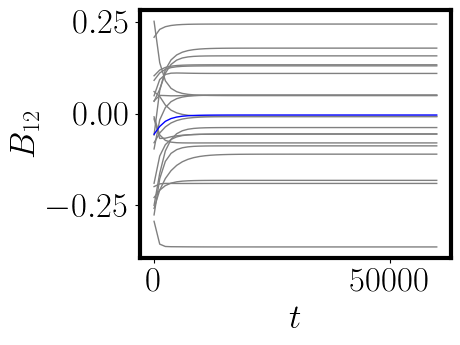

In [10]:
steps = 60001
ts = np.arange(0, steps, steps//50)

K_hist = np.load('data/training/n4/orth_data/ndata2/L48/RPASlKhist_n4L48_0.3_-0.5.npy')[::steps//50]
muend = np.load('data/training/n4/orth_data/ndata2/L48/RPASlmuhist_n4L48_0.3_-0.5.npy')[-1]

B_hist = np.zeros((51, 20, 2, 2))
for i in range(51):
    for k in range(20):
        B_hist[i, k] = KoffdiagRatio(K_hist[i, k])


fig, ax = plt.subplots(figsize=(5, 4))
ax.plot(ts, B_hist[:, :, 0, 1], c='grey', lw=1)
ax.plot(ts, np.mean(B_hist[:, :, 0, 1], axis=1), c='b', lw=1)
ax.set_ylabel(r'$B_{12}$')
ax.set_xlabel(r'$t$')

plt.tight_layout()

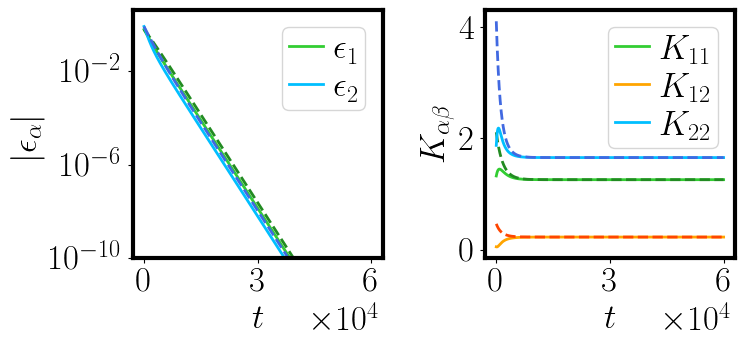

In [13]:
# complete version
steps = 60001
ts = np.arange(steps)
ndata = 2
idx = 5

eps_hist = np.load('data/training/n4/orth_data/ndata2/L48/RPASlepshist_n4L48_0.3_-0.5.npy')[:, idx]
K_hist = np.load('data/training/n4/orth_data/ndata2/L48/RPASlKhist_n4L48_0.3_-0.5.npy')[:, idx]
muend = np.load('data/training/n4/orth_data/ndata2/L48/RPASlmuhist_n4L48_0.3_-0.5.npy')[-1, idx]

ldaend = ldaUT(K_hist[-1], muend)
Aend = ldaend[:, range(2), range(2)].T
Bend = KoffdiagRatio(K_hist[-1])
# predict on epsilon
E = np.copy(Bend)
for i in range(2):
    E[i] *= np.sqrt(K_hist[-1, i,i] * np.diag(K_hist[-1]))
Evals, Pe = np.linalg.eigh(E)
bs = Pe.T @ eps_hist[0]
eps_pred = np.zeros((steps, ndata))
for i in range(ndata):
    eps_pred[:, i] = np.stack([bs[k] * Pe[i, k] * np.exp(-0.001*Evals[k]*ts/ndata) 
        for k in range(ndata)]).sum(axis=0)
# predict on g
g_pred = np.zeros_like(eps_pred)
factors = Aend @ np.diag(np.sqrt(np.diag(K_hist[-1]))) @ Pe
for i in range(ndata):
    g_pred[:, i] = np.stack([bs[k]*factors[i, k]/Evals[k] * np.exp(-0.001*Evals[k]*ts/ndata) 
        for k in range(ndata)]).sum(axis=0)
g_pred += np.sqrt(np.diag(K_hist[-1]))

fig, axs = plt.subplots(1, 2, figsize=(8, 4), sharex=True)
cl = ['limegreen', 'deepskyblue']
cl2 = ['forestgreen', 'royalblue']
for i in range(2):
    axs[0].plot(np.abs(eps_hist[:, i]), lw=2, c=cl[i], label=fr'$\epsilon_{{{i+1}}}$')
    axs[0].plot(np.abs(eps_pred[:, i]), '--', lw=2, c=cl2[i])
axs[0].legend(handletextpad=0.3, labelspacing=0.2, borderpad=0.2, handlelength=1)
axs[0].set_yscale('log')
axs[0].set_xticks(np.arange(3)*3e4)
axs[0].set_ylim(1e-10, 4)
axs[0].ticklabel_format(axis='x', style='sci', scilimits=(0,0))
axs[0].set_ylabel(r'$|\epsilon_\alpha|$')

clk = ['limegreen', 'orange', 'deepskyblue']
clk2 = ['forestgreen', 'orangered', 'royalblue']
for cc, (i, j) in enumerate(combinations_with_replacement(range(2), 2)):
    axs[1].plot(K_hist[:, i, j], lw=2, c=clk[cc], label=fr'$K_{{{i+1} {j+1}}}$')
    axs[1].plot(Bend[i,j] * g_pred[:, i] * g_pred[:, j], '--', lw=2, c=clk2[cc])
axs[1].legend(handletextpad=0.3, labelspacing=0.2, borderpad=0.2, handlelength=1)
axs[1].set_ylabel(r'$K_{\alpha \beta}$')

for i in range(2):
    axs[i].set_xlabel(r'$t$')

plt.tight_layout()
plt.show()
plt.close()

## At the critical boundary

In [201]:
steps = 100001

J_hist = np.load('data/training/n4/orth_data/ndata2/L48/RPASlJhist_n4L48_1_-1.npy')
K_hist = contract('trai, trbi->trab', J_hist, J_hist)
H_hist = np.load('data/training/n4/orth_data/ndata2/L48/RPASlHhist_n4L48_1_-1.npy')
mu_hist = contract('trai, trbij, trcj->trabc', J_hist[::steps//50], H_hist, J_hist[::steps//50])

np.save('data/training/n4/orth_data/ndata2/L48/RPASlKhist_n4L48_1_-1.npy', K_hist)
np.save('data/training/n4/orth_data/ndata2/L48/RPASlmuhist_n4L48_1_-1.npy', mu_hist)

### hessian

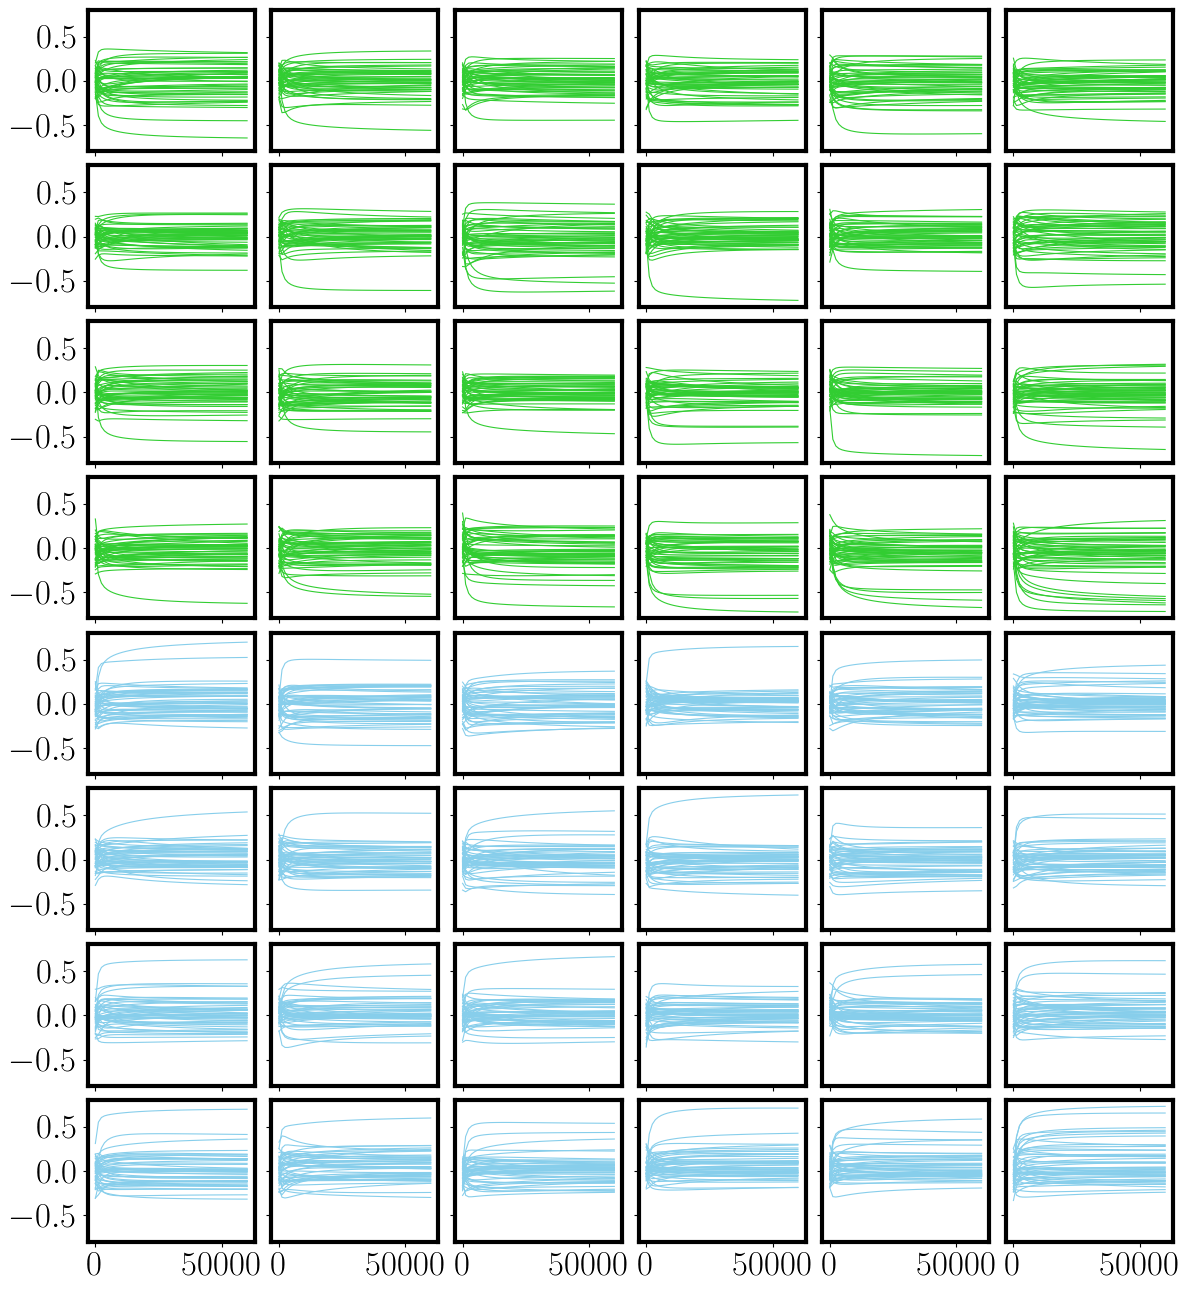

In [ ]:
steps = 60001
ts = np.arange(0, steps, steps//50)
L = 48
H_hist = np.load('data/training/n4/orth_data/ndata2/L48/RPASlHhist_n4L48_1_-1.npy')

idx = 2
H_hist_plot = [H_hist[:, idx, 0, x, y] for x in range(48) for y in range(x, 48)] + \
            [H_hist[:, idx, 1, x, y] for x in range(48) for y in range(x, 48)]
H_hist_plot = np.stack(H_hist_plot).T

num = L*(L-1)//2 + L

fig, axs = plt.subplots(8, 6, figsize=(14, 16), sharex=True, sharey=True)

for i in range(24):
    axs[i//6, i%6].plot(ts, H_hist_plot[:, num//24*i: num//24*(i+1)], c='limegreen', lw=0.8)
    axs[4+i//6, i%6].plot(ts, H_hist_plot[:, num + num//24*i: num + num//24*(i+1)], c='skyblue', lw=0.8)

plt.subplots_adjust(hspace=0.1, wspace=0.1)
#plt.tight_layout()

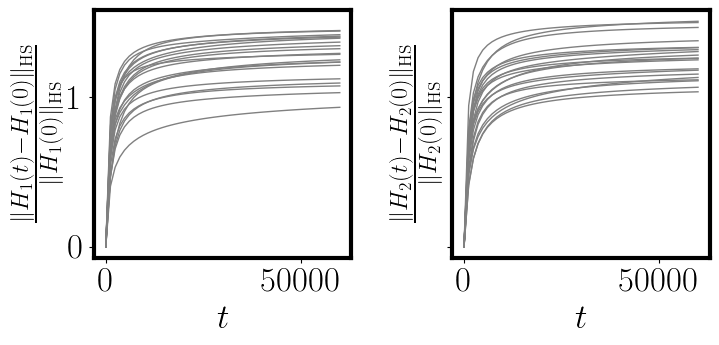

In [102]:
steps = 60001
ts = np.arange(0, steps, steps//50)

H_hist = np.load('data/training/n4/orth_data/ndata2/L48/RPASlHhist_n4L48_1_-1.npy')

fig, axs = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)
for i in range(2):
    axs[i].plot(ts, np.linalg.norm(H_hist[:,:,i]-H_hist[0,:,i], axis=(2, 3))\
                /np.linalg.norm(H_hist[0, :, i], axis=(1, 2)), c='grey', lw=1)
    axs[i].set_ylabel(fr'$\frac{{\|H_{{{i+1}}}(t) - H_{{{i+1}}}(0)\|_{{\rm HS}}}}{{\|H_{{{i+1}}}(0)\|_{{\rm HS}}}}$')
    axs[i].set_xlabel(r'$t$')
plt.tight_layout()

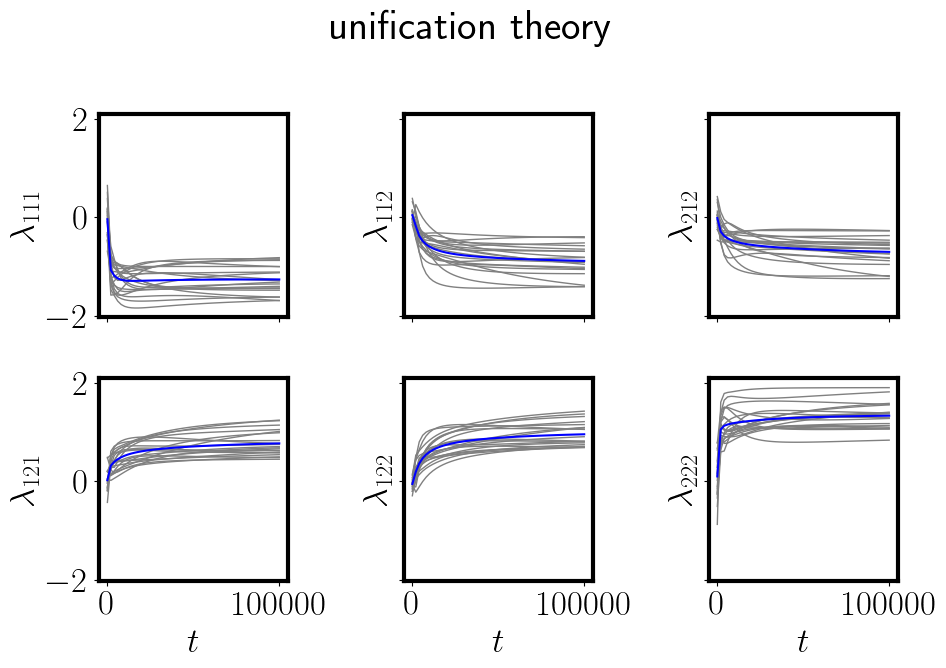

In [6]:
steps = int(1e5)+1
ts = np.arange(0, steps, steps//50)

K_hist = np.load('data/training/n4/orth_data/ndata2/L48/RPASlKhist_n4L48_1_-1.npy')[::steps//50]
mu_hist = np.load('data/training/n4/orth_data/ndata2/L48/RPASlmuhist_n4L48_1_-1.npy')

lda_hist = np.zeros((51, 20, 2, 2, 2))
for i in range(51):
    for k in range(20):
        lda_hist[i, k] = ldaUT(K_hist[i, k], mu_hist[i, k])

fig, axs = plt.subplots(2, 3, figsize=(10, 7), sharex=True, sharey=True)

for i in range(2):
    for cc, (x, y) in enumerate(combinations_with_replacement(range(2), 2)): 
        axs[i, cc].plot(ts, lda_hist[:, :, x, i, y], lw=1, c='grey')
        axs[i, cc].plot(ts, np.mean(lda_hist[:, :, x, i, y], axis=1), c='b')
        axs[i, cc].set_ylabel(fr'$\lambda_{{{x+1} {i+1} {y+1}}}$')
        axs[1, cc].set_xlabel(r'$t$')
plt.suptitle('unification theory')
plt.tight_layout()

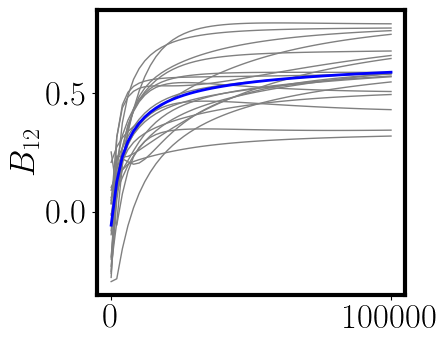

In [12]:
steps = int(1e5)+1
ts = np.arange(0, steps, steps//50)

K_hist = np.load('data/training/n4/orth_data/ndata2/L48/RPASlKhist_n4L48_1_-1.npy')[::steps//50]

B_hist = np.zeros((51, 20, 2, 2))
for i in range(51):
    for k in range(20):
        B_hist[i, k] = KoffdiagRatio(K_hist[i, k])

fig, ax = plt.subplots(figsize=(5, 4))
ax.plot(ts, B_hist[:, :, 0, 1], c='grey', lw=1)
ax.plot(ts, np.mean(B_hist[:, :, 0, 1], axis=1), c='b', lw=2)
ax.set_ylabel(r'$B_{12}$')
plt.tight_layout()

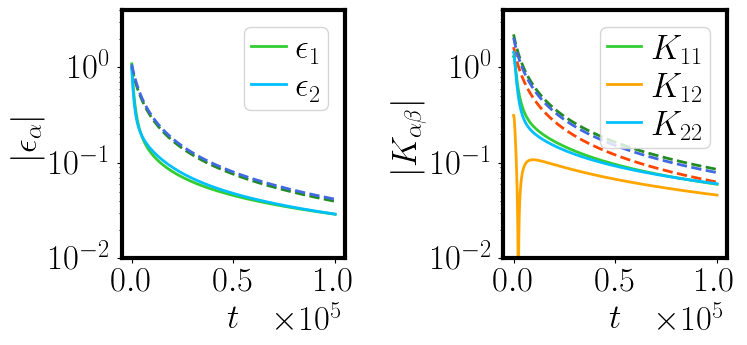

In [56]:
steps = int(1e5)+1
ts = np.arange(steps)
ndata = 2

idx = 2

eps_hist = np.load('data/training/n4/orth_data/ndata2/L48/RPASlepshist_n4L48_1_-1.npy')[:, idx]
K_hist = np.load('data/training/n4/orth_data/ndata2/L48/RPASlKhist_n4L48_1_-1.npy')[:, idx]
muend = np.load('data/training/n4/orth_data/ndata2/L48/RPASlmuhist_n4L48_1_-1.npy')[-1, idx]

ldaend = ldaUT(K_hist[-1], muend)
Aend = ldaend[:, range(2), range(2)].T
Bend = KoffdiagRatio(K_hist[-1])
cs_E = [-2.05186, 2.1608]
cs_G = [2.10723, 2.0254]
eps_pred = np.stack([cs_E[k]/(2 + 0.001*ts/ndata) for k in range(2)]).T
g_pred = np.stack([cs_G[k]/np.sqrt(2 + 0.001*ts/ndata) for k in range(2)]).T

fig, axs = plt.subplots(1, 2, figsize=(8, 4), sharex=True)
cl = ['limegreen', 'deepskyblue']
cl2 = ['forestgreen', 'royalblue']
for i in range(2):
    axs[0].plot(np.abs(eps_hist[:, i]), lw=2, c=cl[i], label=fr'$\epsilon_{{{i+1}}}$')
    axs[0].plot(np.arange(steps), np.abs(eps_pred[:, i]), '--', lw=2, c=cl2[i])
axs[0].legend(handletextpad=0.3, labelspacing=0.2, borderpad=0.2, handlelength=1)
axs[0].set_xticks(np.arange(3)*5e4)
axs[0].ticklabel_format(axis='x', style='sci', scilimits=(0,0))
axs[0].set_ylabel(r'$|\epsilon_\alpha|$')

clk = ['limegreen', 'orange', 'deepskyblue']
clk2 = ['forestgreen', 'orangered', 'royalblue']
for cc, (i, j) in enumerate(combinations_with_replacement(range(2), 2)):
    axs[1].plot(np.abs(K_hist[:, i, j]), lw=2, c=clk[cc], label=fr'$K_{{{i+1} {j+1}}}$')
    axs[1].plot(np.abs(Bend[i,j] * g_pred[:, i] * g_pred[:, j]), '--', lw=2, c=clk2[cc])
axs[1].legend(handletextpad=0.3, labelspacing=0.2, borderpad=0.2, handlelength=1)
axs[1].set_ylabel(r'$|K_{\alpha \beta}|$')
for i in range(2):
    axs[i].set_xlabel(r'$t$')
    axs[i].set_ylim(1e-2, 4)
    axs[i].set_yscale('log')
    
plt.tight_layout()
plt.show()
plt.close()

## Outside

In [41]:
steps = 60001

J_hist = np.load('data/training/n4/orth_data/ndata2/L48/RPASlJhist_n4L48_5_-6.npy')
K_hist = contract('trai, trbi->trab', J_hist, J_hist)
H_hist = np.load('data/training/n4/orth_data/ndata2/L48/RPASlHhist_n4L48_5_-6.npy')
mu_hist = contract('trai, trbij, trcj->trabc', J_hist[::steps//50], H_hist, J_hist[::steps//50])

np.save('data/training/n4/orth_data/ndata2/L48/RPASlKhist_n4L48_5_-6.npy', K_hist)
np.save('data/training/n4/orth_data/ndata2/L48/RPASlmuhist_n4L48_5_-6.npy', mu_hist)

### hessian

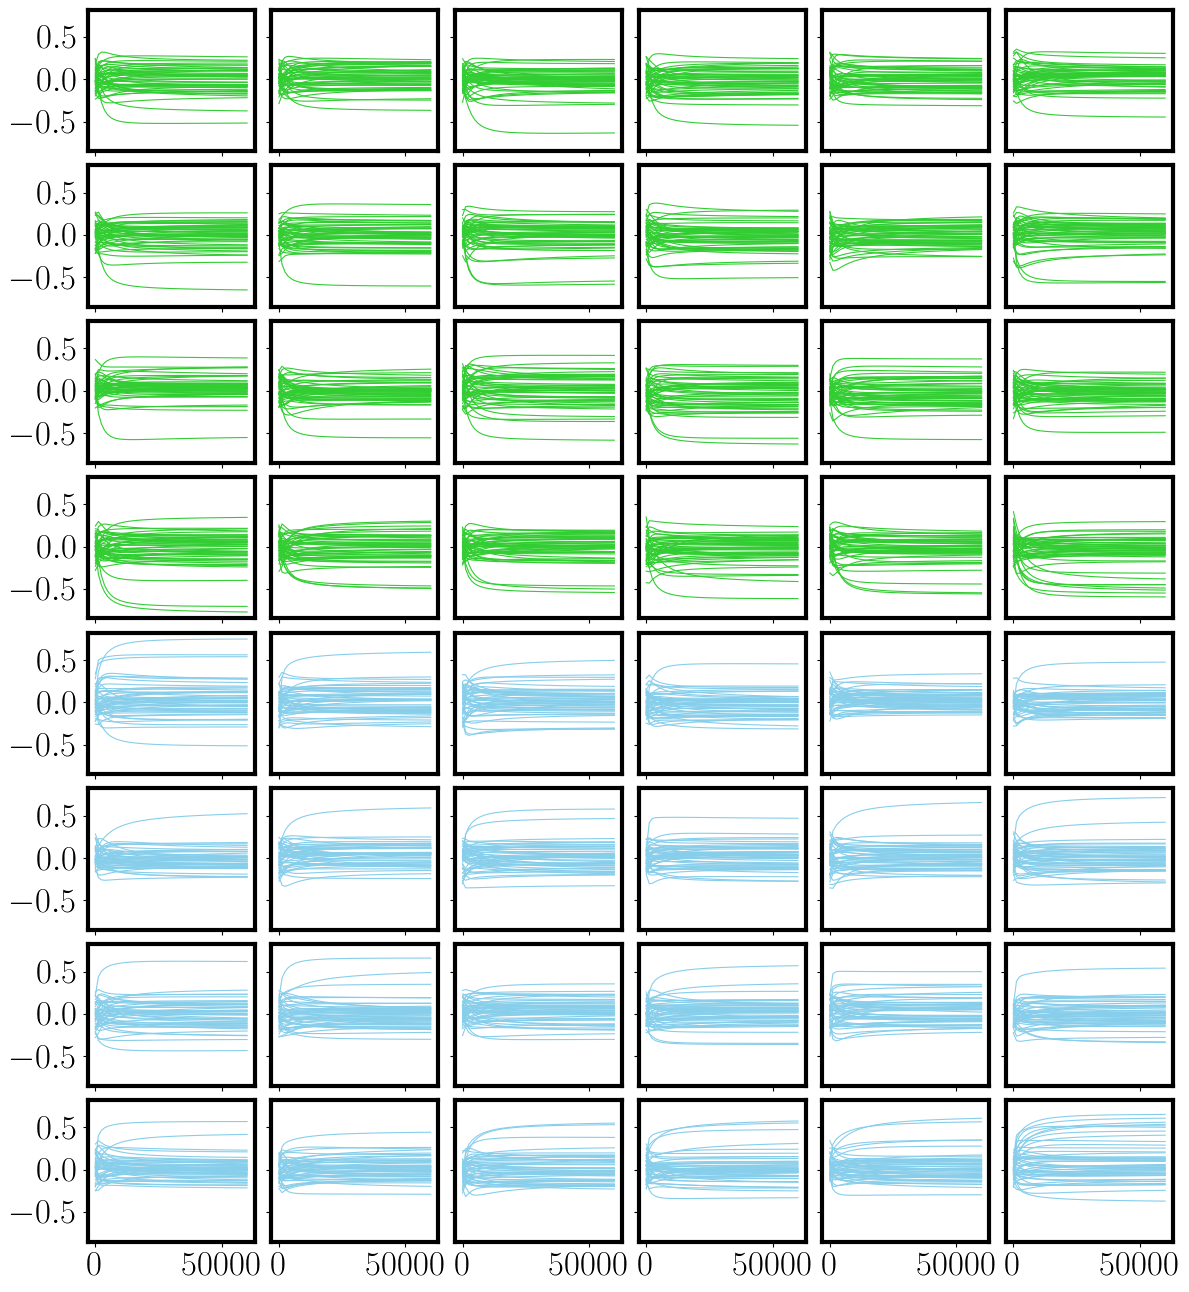

In [42]:
steps = 60001
ts = np.arange(0, steps, steps//50)
L = 48
H_hist = np.load('data/training/n4/orth_data/ndata2/L48/RPASlHhist_n4L48_1_-1.npy')

idx = 14
H_hist_plot = [H_hist[:, idx, 0, x, y] for x in range(48) for y in range(x, 48)] + \
            [H_hist[:, idx, 1, x, y] for x in range(48) for y in range(x, 48)]
H_hist_plot = np.stack(H_hist_plot).T

num = L*(L-1)//2 + L

fig, axs = plt.subplots(8, 6, figsize=(14, 16), sharex=True, sharey=True)

for i in range(24):
    axs[i//6, i%6].plot(ts, H_hist_plot[:, num//24*i: num//24*(i+1)], c='limegreen', lw=0.8)
    axs[4+i//6, i%6].plot(ts, H_hist_plot[:, num + num//24*i: num + num//24*(i+1)], c='skyblue', lw=0.8)

plt.subplots_adjust(hspace=0.1, wspace=0.1)
#plt.tight_layout()

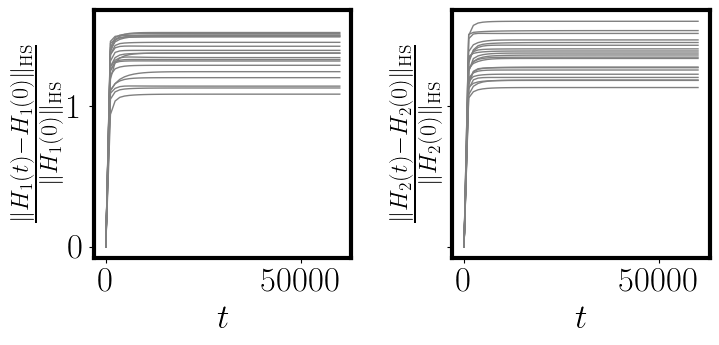

In [43]:
steps = 60001
ts = np.arange(0, steps, steps//50)

H_hist = np.load('data/training/n4/orth_data/ndata2/L48/RPASlHhist_n4L48_5_-6.npy')

fig, axs = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)
for i in range(2):
    axs[i].plot(ts, np.linalg.norm(H_hist[:,:,i]-H_hist[0,:,i], axis=(2, 3))\
                /np.linalg.norm(H_hist[0, :, i], axis=(1, 2)), c='grey', lw=1)
    axs[i].set_ylabel(fr'$\frac{{\|H_{{{i+1}}}(t) - H_{{{i+1}}}(0)\|_{{\rm HS}}}}{{\|H_{{{i+1}}}(0)\|_{{\rm HS}}}}$')
    axs[i].set_xlabel(r'$t$')
plt.tight_layout()

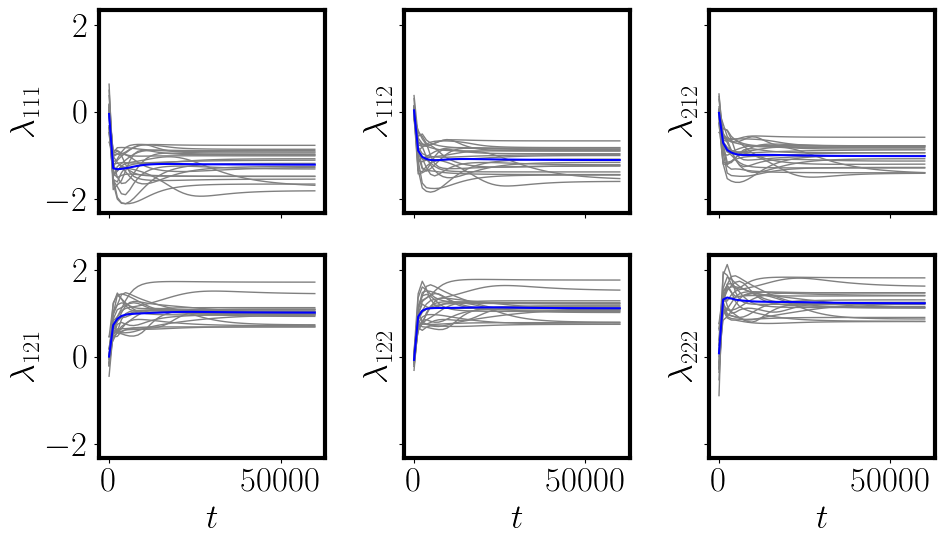

In [28]:
steps = 60001
ts = np.arange(0, steps, steps//50)

K_hist = np.load('data/training/n4/orth_data/ndata2/L48/RPASlKhist_n4L48_5_-6.npy')[::steps//50]
mu_hist = np.load('data/training/n4/orth_data/ndata2/L48/RPASlmuhist_n4L48_5_-6.npy')

lda_hist = np.zeros((51, 20, 2, 2, 2))
for i in range(51):
    for k in range(20):
        lda_hist[i, k] = ldaUT(K_hist[i, k], mu_hist[i, k])

fig, axs = plt.subplots(2, 3, figsize=(10, 6), sharex=True, sharey=True)

for i in range(2):
    for cc, (x, y) in enumerate(combinations_with_replacement(range(2), 2)): 
        axs[i, cc].plot(ts, lda_hist[:, :, x, i, y], lw=1, c='grey')
        axs[i, cc].plot(ts, np.mean(lda_hist[:, :, x, i, y], axis=1), c='b')
        axs[i, cc].set_ylabel(fr'$\lambda_{{{x+1} {i+1} {y+1}}}$')
        axs[1, cc].set_xlabel(r'$t$')
plt.tight_layout()

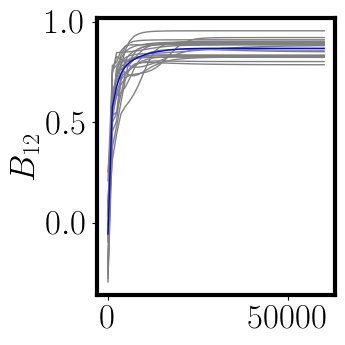

In [13]:
steps = 60001
ts = np.arange(0, steps, steps//50)

K_hist = np.load('data/training/n4/orth_data/ndata2/L48/RPASlKhist_n4L48_5_-6.npy')[::steps//50]

B_hist = np.zeros((51, 20, 2, 2))
for i in range(51):
    for k in range(20):
        B_hist[i, k] = KoffdiagRatio(K_hist[i, k])

fig, ax = plt.subplots(figsize=(4, 4))
ax.plot(ts, B_hist[:, :, 0, 1], c='grey', lw=1)
ax.plot(ts, np.mean(B_hist[:, :, 0, 1], axis=1), c='b', lw=1)
ax.set_ylabel(r'$B_{12}$')
plt.tight_layout()

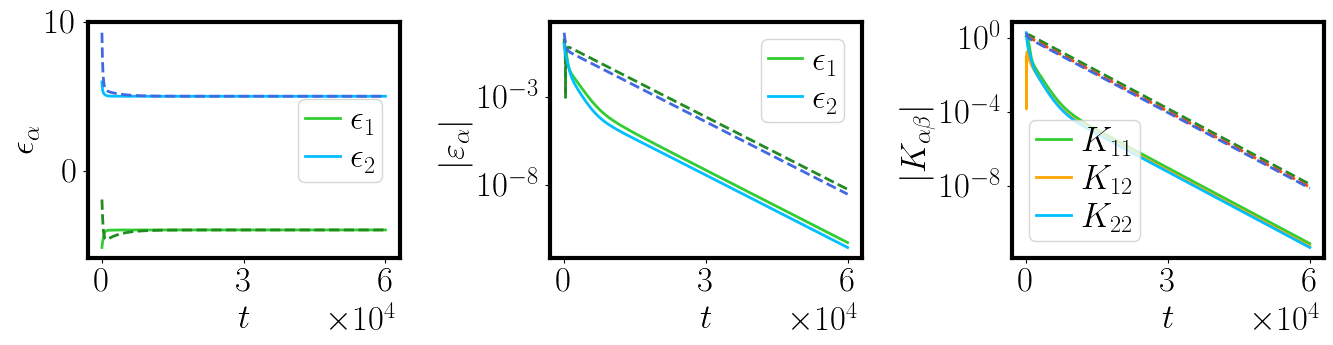

In [61]:
steps = 60001
ts = np.arange(steps)
ndata = 2

idx = 14

eps_hist = np.load('data/training/n4/orth_data/ndata2/L48/RPASlepshist_n4L48_5_-6.npy')[:, idx]
K_hist = np.load('data/training/n4/orth_data/ndata2/L48/RPASlKhist_n4L48_5_-6.npy')[:, idx]
muend = np.load('data/training/n4/orth_data/ndata2/L48/RPASlmuhist_n4L48_5_-6.npy')[-1, idx]

Rs = np.array([-4, 5])

ldaend = ldaUT(K_hist[-1], muend)
Aend = ldaend[:, range(2), range(2)].T
Bend = KoffdiagRatio(K_hist[-1])

# predict on g
G = Aend @ np.diag(Rs)
Gvals, Pg = np.linalg.eig(G)
bs = np.linalg.inv(Pg) @ np.sqrt(np.diag(K_hist[0]))
g_pred = np.zeros((steps, ndata))
for i in range(ndata):
    g_pred[:, i] = np.stack([bs[k] * Pg[i, k] * np.exp(-0.001*Gvals[k]*ts/ndata) 
        for k in range(ndata)]).sum(axis=0)
# predict on epsilon
eps_pred = np.zeros_like(g_pred)
factors = Bend @ np.diag(Rs) @ Pg
for i in range(ndata):
    for (k, kp) in product(range(2), repeat=2):
        eps_pred[:, i] += factors[i, kp]*bs[k]*bs[kp]*Pg[i,k]*np.exp(-0.001*(Gvals[k] + Gvals[kp])*ts/ndata)
eps_pred += Rs

fig, axs = plt.subplots(1, 3, figsize=(14, 4))
cl = ['limegreen', 'deepskyblue']
cl2 = ['forestgreen', 'royalblue']
for i in range(2):
    axs[0].plot(eps_hist[:, i], lw=2, c=cl[i], label=fr'$\epsilon_{{{i+1}}}$')
    axs[0].plot(eps_pred[:, i], '--', lw=2, c=cl2[i])
axs[0].legend(handletextpad=0.3, labelspacing=0.2, borderpad=0.2, handlelength=1)
axs[0].set_xticks(np.arange(3)*3e4)
axs[0].ticklabel_format(axis='x', style='sci', scilimits=(0,0))
axs[0].set_ylabel(r'$\epsilon_\alpha$')

for i in range(2):
    axs[1].plot(np.abs(eps_hist[:, i] - Rs[i]), lw=2, c=cl[i], label=fr'$\epsilon_{{{i+1}}}$')
    axs[1].plot(np.abs(eps_pred[:, i] - Rs[i]), '--', lw=2, c=cl2[i])
axs[1].legend(handletextpad=0.3, labelspacing=0.2, borderpad=0.2, handlelength=1)
axs[1].set_yscale('log')
axs[1].set_xticks(np.arange(3)*3e4)
axs[1].ticklabel_format(axis='x', style='sci', scilimits=(0,0))
axs[1].set_ylabel(r'$|\varepsilon_\alpha|$')

clk = ['limegreen', 'orange', 'deepskyblue']
clk2 = ['forestgreen', 'orangered', 'royalblue']
for cc, (i, j) in enumerate(combinations_with_replacement(range(2), 2)):
    axs[2].plot(np.abs(K_hist[:, i, j]), lw=2, c=clk[cc], label=fr'$K_{{{i+1} {j+1}}}$')
    axs[2].plot(np.abs(Bend[i, j] * g_pred[:, i] * g_pred[:, j]), '--', lw=2, c=clk2[cc])
axs[2].legend(handletextpad=0.3, labelspacing=0.2, borderpad=0.2, handlelength=1)
axs[2].set_ylabel(r'$K_{\alpha \beta}$')
axs[2].set_yscale('log')
axs[2].set_xticks(np.arange(3)*3e4)
axs[2].ticklabel_format(axis='x', style='sci', scilimits=(0,0))
axs[2].set_ylabel(r'$|K_{\alpha \beta}|$')

for i in range(3):
    axs[i].set_xlabel(r'$t$')

plt.tight_layout()
plt.show()
plt.close()

In [73]:
steps = 60001
ts = np.arange(steps)
ndata = 2

idx = 14

eps_hist = np.load('data/training/n4/orth_data/ndata2/L48/RPASlepshist_n4L48_5_-6.npy')[:, idx]
K_hist = np.load('data/training/n4/orth_data/ndata2/L48/RPASlKhist_n4L48_5_-6.npy')[:, idx]
muend = np.load('data/training/n4/orth_data/ndata2/L48/RPASlmuhist_n4L48_5_-6.npy')[-1, idx]


print(KoffdiagRatio(K_hist[10000]))
Rs = np.array([-4, 5])

ldaend = ldaUT(K_hist[-1], muend)
Aend = ldaend[:, range(2), range(2)].T
Bend = KoffdiagRatio(K_hist[-1])

G = Aend @ np.diag(Rs)
Gvals, Pg = np.linalg.eig(G)
bs = np.linalg.inv(Pg) @ np.sqrt(np.diag(K_hist[0]))

print(Gvals)
xmin = np.argmin(Gvals)

h1 = Rs[0]*Pg[0, xmin]*(ldaend[0, 1, 0]/Pg[1, xmin] + ldaend[0, 0, 1]/Pg[0, xmin]) \
+ Rs[1]*Pg[1, xmin]*(ldaend[1, 1, 0]/Pg[1, xmin] + ldaend[1, 0, 1]/Pg[0, xmin])

h2 = Rs[0]*Pg[0, xmin]*(ldaend[0, 1, 1]/Pg[1, xmin] + ldaend[0, 0, 0]/Pg[0, xmin]) \
+ Rs[1]*Pg[1, xmin]*(ldaend[1, 1, 1]/Pg[1, xmin] + ldaend[1, 0, 0]/Pg[0, xmin])
print(h1, h2, Bend[0, 1], Bend[0, 1]*h2 - h1)

[[1.         0.86408371]
 [0.86408371 1.        ]]
[0.31462915 9.08378765]
0.5632778256006579 0.6292582990992195 0.8951462599299201 3.873678714461093e-07


# Two-phase results & QNTK-based theories

## Inside $\times$ boundary

In [79]:
steps = int(1e5) + 1

J_hist = np.load('data/training/n4/orth_data/ndata2/L48/RPASlJhist_n4L48_0.4_-1.0.npy')
K_hist = contract('trai, trbi->trab', J_hist, J_hist)
H_hist = np.load('data/training/n4/orth_data/ndata2/L48/RPASlHhist_n4L48_0.4_-1.0.npy')
mu_hist = contract('trai, trbij, trcj->trabc', J_hist[::steps//50], H_hist, J_hist[::steps//50])

np.save('data/training/n4/orth_data/ndata2/L48/RPASlKhist_n4L48_0.4_-1.0.npy', K_hist)
np.save('data/training/n4/orth_data/ndata2/L48/RPASlmuhist_n4L48_0.4_-1.0.npy', mu_hist)

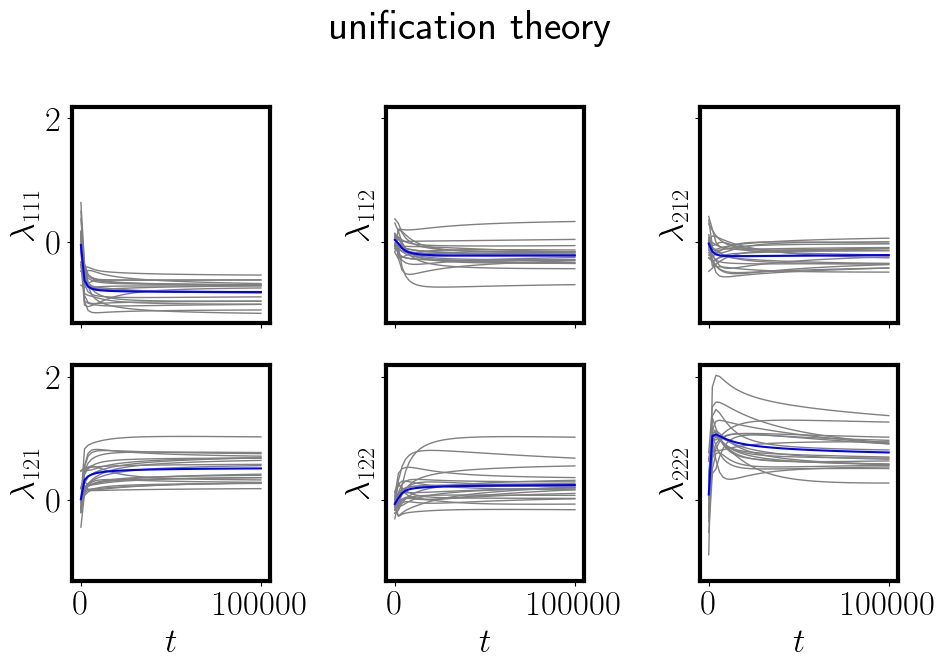

In [80]:
steps = int(1e5) + 1
ts = np.arange(0, steps, steps//50)

K_hist = np.load('data/training/n4/orth_data/ndata2/L48/RPASlKhist_n4L48_0.4_-1.0.npy')[::steps//50]
mu_hist = np.load('data/training/n4/orth_data/ndata2/L48/RPASlmuhist_n4L48_0.4_-1.0.npy')

lda_hist = np.zeros((51, 20, 2, 2, 2))
for i in range(51):
    for k in range(20):
        lda_hist[i, k] = ldaUT(K_hist[i, k], mu_hist[i, k])

fig, axs = plt.subplots(2, 3, figsize=(10, 7), sharex=True, sharey=True)

for i in range(2):
    for cc, (x, y) in enumerate(combinations_with_replacement(range(2), 2)): 
        axs[i, cc].plot(ts, lda_hist[:, :, x, i, y], lw=1, c='grey')
        axs[i, cc].plot(ts, np.mean(lda_hist[:, :, x, i, y], axis=1), c='b')
        axs[i, cc].set_ylabel(fr'$\lambda_{{{x+1} {i+1} {y+1}}}$')
        axs[1, cc].set_xlabel(r'$t$')
plt.suptitle('unification theory')
plt.tight_layout()

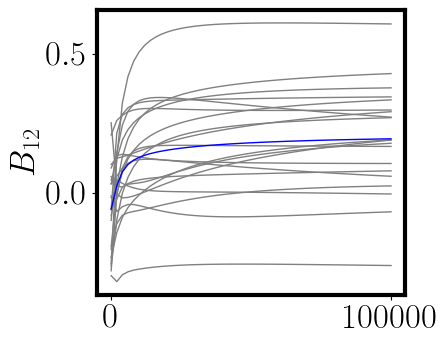

In [74]:
steps = int(1e5) + 1
ts = np.arange(0, steps, steps//50)

K_hist = np.load('data/training/n4/orth_data/ndata2/L48/RPASlKhist_n4L48_0.4_-1.0.npy')[::steps//50]

B_hist = np.zeros((51, 20, 2, 2))
for i in range(51):
    for k in range(20):
        B_hist[i, k] = KoffdiagRatio(K_hist[i, k])

fig, ax = plt.subplots(figsize=(5, 4))
ax.plot(ts, B_hist[:, :, 0, 1], c='grey', lw=1)
ax.plot(ts, np.mean(B_hist[:, :, 0, 1], axis=1), c='b', lw=1)
ax.set_ylabel(r'$B_{12}$')
plt.tight_layout()

C:\Users\Bingzhi\AppData\Local\Temp\ipykernel_246644\589181515.py:23: RuntimeWarning: invalid value encountered in power
  eps_pred[:, 0] = a1E/(0.001*ts/ndata + a0)**1.5
C:\Users\Bingzhi\AppData\Local\Temp\ipykernel_246644\589181515.py:24: RuntimeWarning: invalid value encountered in sqrt
  g_pred[:, 0] = 2*(Aend[0, 0]*np.sqrt(K_hist[-1, 0, 0])*a1E/np.sqrt(a0 + 0.001*ts/ndata)


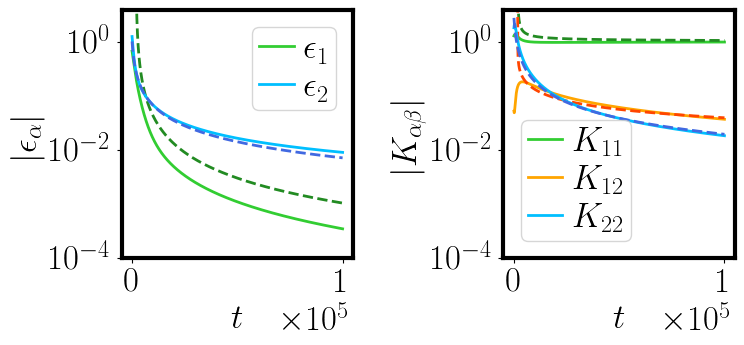

In [35]:
steps = int(1e5) + 1
ts = np.arange(steps)
ndata = 2

idx = 5
eps_hist = np.load('data/training/n4/orth_data/ndata2/L48/RPASlepshist_n4L48_0.4_-1.0.npy')[:, idx]
K_hist = np.load('data/training/n4/orth_data/ndata2/L48/RPASlKhist_n4L48_0.4_-1.0.npy')[:, idx]
muend = np.load('data/training/n4/orth_data/ndata2/L48/RPASlmuhist_n4L48_0.4_-1.0.npy')[-1, idx]
ldaend = ldaUT(K_hist[-1], muend)
Aend = ldaend[:, range(2), range(2)].T
Bend = KoffdiagRatio(K_hist[-1])

eps_pred = np.zeros((steps, 2))
g_pred = np.zeros_like(eps_pred)
# prediction on data at boundary
c1E, c1G = 0.365506, 1
c0 = 0.35
eps_pred[:, 1] = c1E/(0.001*ts/ndata + c0)
g_pred[:, 1] = c1G/np.sqrt(0.001*ts/ndata + c0)
# prediction on data inside
a1E = - Bend[0, 1]*c1E*c1G/(Bend[0, 1]*np.sqrt(K_hist[-1, 0, 0]))
a0 = (-a1E/np.sqrt(K_hist[-1, 0, 0]) - Bend[0, 1]*c1E*c1G*c0) / (Bend[0, 0]*np.sqrt(K_hist[-1, 0, 0])*a1E)
eps_pred[:, 0] = a1E/(0.001*ts/ndata + a0)**1.5
g_pred[:, 0] = 2*(Aend[0, 0]*np.sqrt(K_hist[-1, 0, 0])*a1E/np.sqrt(a0 + 0.001*ts/ndata)
                + Aend[0, 1]*c1E*c1G/np.sqrt(c0 + 0.001*ts/ndata)) + np.sqrt(K_hist[-1,0,0])

fig, axs = plt.subplots(1, 2, figsize=(8, 4), sharex=True)
cl = ['limegreen', 'deepskyblue']
cl2 = ['forestgreen', 'royalblue']
for i in range(2):
    axs[0].plot(np.abs(eps_hist[:, i]), lw=2, c=cl[i], label=fr'$\epsilon_{{{i+1}}}$')
    axs[0].plot(np.abs(eps_pred[:, i]), '--', lw=2, c=cl2[i])
axs[0].legend(handletextpad=0.3, labelspacing=0.2, borderpad=0.2, handlelength=1)
axs[0].ticklabel_format(axis='x', style='sci', scilimits=(0,0))
axs[0].set_ylabel(r'$|\epsilon_\alpha|$')

clk = ['limegreen', 'orange', 'deepskyblue']
clk2 = ['forestgreen', 'orangered', 'royalblue']
for cc, (i, j) in enumerate(combinations_with_replacement(range(2), 2)):
    axs[1].plot(np.abs(K_hist[:, i, j]), lw=2, c=clk[cc], label=fr'$K_{{{i+1} {j+1}}}$')
    axs[1].plot(np.abs(Bend[i, j]*g_pred[:, i]*g_pred[:, j]), '--', lw=2, c=clk2[cc])
axs[1].legend(handletextpad=0.3, labelspacing=0.2, borderpad=0.2, handlelength=1)
axs[1].set_ylabel(r'$|K_{\alpha \beta}|$')
for i in range(2):
    axs[i].set_ylim(1e-4, 4)
    axs[i].set_yscale('log')
    axs[i].set_xlabel(r'$t$')

plt.tight_layout()
plt.show()
plt.close()

## Boundary $\times$ Outside

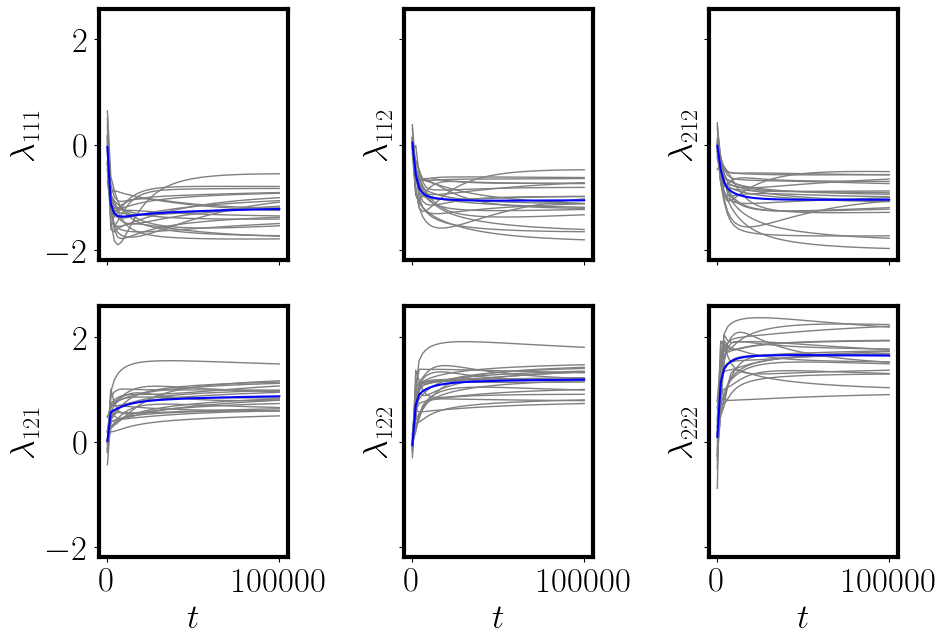

In [78]:
steps = int(1e5) + 1
ts = np.arange(0, steps, steps//50)

K_hist = np.load('data/training/n4/orth_data/ndata2/L48/RPASlKhist_n4L48_1_-5.npy')[::steps//50]
mu_hist = np.load('data/training/n4/orth_data/ndata2/L48/RPASlmuhist_n4L48_1_-5.npy')

lda_hist = np.zeros((51, 20, 2, 2, 2))
for i in range(51):
    for k in range(20):
        lda_hist[i, k] = ldaUT(K_hist[i, k], mu_hist[i, k])

fig, axs = plt.subplots(2, 3, figsize=(10, 7), sharex=True, sharey=True)

for i in range(2):
    for cc, (x, y) in enumerate(combinations_with_replacement(range(2), 2)): 
        axs[i, cc].plot(ts, lda_hist[:, :, x, i, y], lw=1, c='grey')
        axs[i, cc].plot(ts, np.mean(lda_hist[:, :, x, i, y], axis=1), c='b')
        axs[i, cc].set_ylabel(fr'$\lambda_{{{x+1} {i+1} {y+1}}}$')
        axs[1, cc].set_xlabel(r'$t$')
plt.tight_layout()

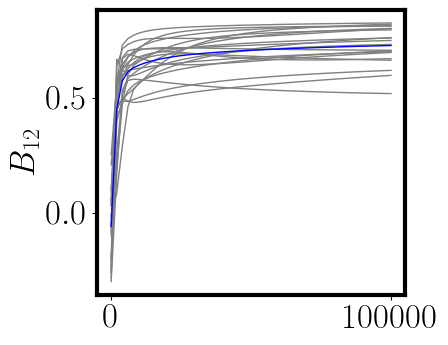

In [72]:
steps = int(1e5) + 1
ts = np.arange(0, steps, steps//50)

K_hist = np.load('data/training/n4/orth_data/ndata2/L48/RPASlKhist_n4L48_1_-5.npy')[::steps//50]

B_hist = np.zeros((51, 20, 2, 2))
for i in range(51):
    for k in range(20):
        B_hist[i, k] = KoffdiagRatio(K_hist[i, k])

fig, ax = plt.subplots(figsize=(5, 4))
ax.plot(ts, B_hist[:, :, 0, 1], c='grey', lw=1)
ax.plot(ts, np.mean(B_hist[:, :, 0, 1], axis=1), c='b', lw=1)
ax.set_ylabel(r'$B_{12}$')
plt.tight_layout()

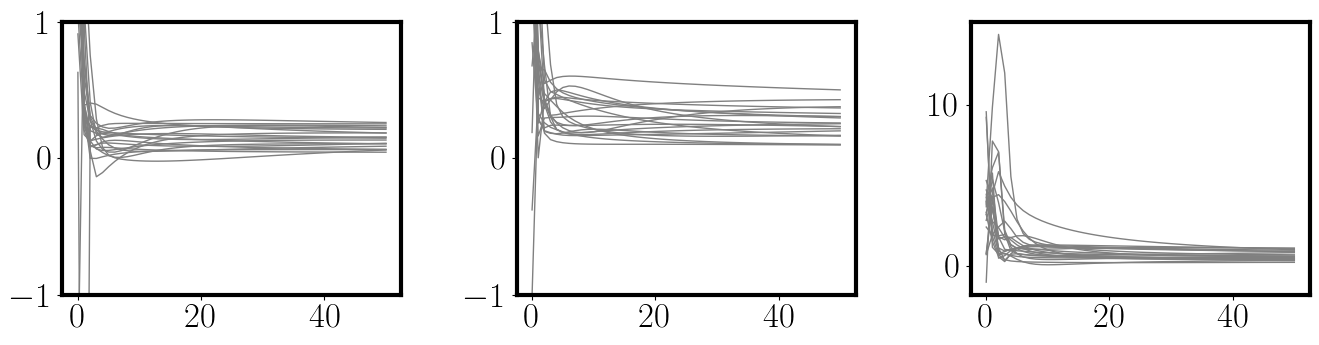

In [10]:
steps = int(1e5) + 1

eps_hist = np.load('data/training/n4/orth_data/ndata2/L48/RPASlepshist_n4L48_1_-5.npy')[::steps//50]
K_hist = np.load('data/training/n4/orth_data/ndata2/L48/RPASlKhist_n4L48_1_-5.npy')[::steps//50]
mu_hist = np.load('data/training/n4/orth_data/ndata2/L48/RPASlmuhist_n4L48_1_-5.npy')

lda_hist = np.zeros((51, 20, 2, 2, 2))
for i in range(51):
    for k in range(20):
        lda_hist[i, k] = ldaUT(K_hist[i, k], mu_hist[i, k])
B_hist = np.zeros((51, 20, 2, 2))
for i in range(51):
    for k in range(20):
        B_hist[i, k] = KoffdiagRatio(K_hist[i, k])


fig, axs = plt.subplots(1, 3, figsize=(14, 4), sharex=True)
dB = 0
for i in range(2):
    dB1 = (lda_hist[:, :, i, 1, 0] - B_hist[:, :, 0, 1]*lda_hist[:, :, i, 1, 1])/lda_hist[:, :, i, 1, 0]
    dB2 = (lda_hist[:, :, i, 0, 1] - B_hist[:, :, 0, 1]*lda_hist[:, :, i, 0, 0])/lda_hist[:, :, i, 0, 1]
    dB += (dB1/np.sqrt(K_hist[:, :, 1, 1]) + dB2/np.sqrt(K_hist[:, :, 0, 0]))\
        *np.sqrt(K_hist[:, :, i, i])
    axs[i].plot(dB1 + dB2, c='grey', lw=1)
    axs[i].set_ylim(-1, 1)
axs[2].plot(dB, c='grey', lw=1)
    
plt.tight_layout()
plt.show()
plt.close()

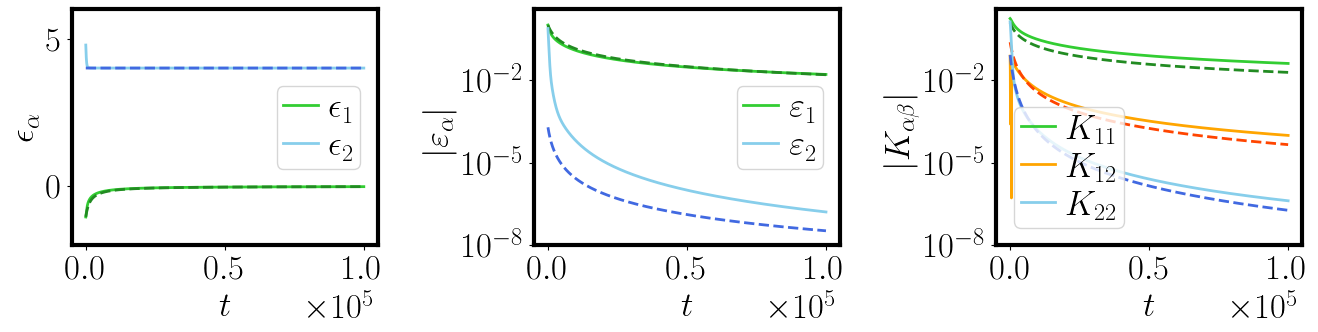

In [47]:
steps = int(1e5) + 1
ts = np.arange(steps)
ndata = 2

idx = 1
eps_hist = np.load('data/training/n4/orth_data/ndata2/L48/RPASlepshist_n4L48_1_-5.npy')[:, idx]
K_hist = np.load('data/training/n4/orth_data/ndata2/L48/RPASlKhist_n4L48_1_-5.npy')[:, idx]
muend = np.load('data/training/n4/orth_data/ndata2/L48/RPASlmuhist_n4L48_1_-5.npy')[-1, idx]
ldaend = ldaUT(K_hist[-1], muend)
Aend = ldaend[:, range(2), range(2)].T
Bend = KoffdiagRatio(K_hist[-1])

Rs = np.array([0, 4])

eps_pred = np.zeros((steps, 2))
g_pred = np.zeros((steps, 2))
# prediction on data at boundary
c1E, c1G = -0.821545, 1
c0 = 0.79
eps_pred[:, 0] = c1E/(0.001*ts/ndata + c0)
g_pred[:, 0] = c1G/np.sqrt(0.001*ts/ndata + c0)
# prediction on data outside
a1G = - Aend[1, 0]*c1E*c1G/(Aend[1, 1]*Rs[1])
a0 = -(a1G + Aend[1, 0]*c1E*c1G*c0) / (Aend[1, 1]*Rs[1]*a1G)
g_pred[:, 1] = a1G/(0.001*ts/ndata + a0)**1.5
eps_pred[:, 1] = (Bend[1, 0]*a1G*c1E*c1G + Bend[1, 1]*Rs[1]*a1G*a1G)/(2*(a0 + 0.001*ts/ndata)**2) \
    + Rs[1]

fig, axs = plt.subplots(1, 3, figsize=(14, 4), sharex=True)
cl = ['limegreen', 'skyblue']
cl2 = ['forestgreen', 'royalblue']
for i in range(2):
    axs[0].plot(eps_hist[:, i], lw=2, c=cl[i], label=fr'$\epsilon_{{{i+1}}}$')
    axs[0].plot(eps_pred[:, i], '--', lw=2, c=cl2[i])
axs[0].legend(handletextpad=0.3, labelspacing=0.2, borderpad=0.2, handlelength=1)
axs[0].set_xticks(np.arange(3)*5e4)
axs[0].set_ylim(-2, 6)
axs[0].ticklabel_format(axis='x', style='sci', scilimits=(0,0))
axs[0].set_ylabel(r'$\epsilon_\alpha$')

for i in range(2):
    axs[1].plot(np.abs(eps_hist[:, i] - Rs[i]), lw=2, c=cl[i], label=fr'$\varepsilon_{{{i+1}}}$')
    axs[1].plot(np.abs(eps_pred[:, i] - Rs[i]), '--', lw=2, c=cl2[i])
axs[1].legend(handletextpad=0.3, labelspacing=0.2, borderpad=0.2, handlelength=1)
axs[1].set_yscale('log')
axs[1].set_ylim(1e-8, 4)
axs[1].ticklabel_format(axis='x', style='sci', scilimits=(0,0))
axs[1].set_ylabel(r'$|\varepsilon_\alpha|$')

clk = ['limegreen', 'orange', 'skyblue']
clk2 = ['forestgreen', 'orangered', 'royalblue']
for cc, (i, j) in enumerate(combinations_with_replacement(range(2), 2)):
    axs[2].plot(np.abs(K_hist[:, i, j]), lw=2, c=clk[cc], label=fr'$K_{{{i+1} {j+1}}}$')
    axs[2].plot(np.abs(Bend[i, j]*g_pred[:, i]*g_pred[:, j]), '--', lw=2, c=clk2[cc])
axs[2].legend(handletextpad=0.3, labelspacing=0.2, borderpad=0.2, handlelength=1)
axs[2].set_ylabel(r'$K_{\alpha \beta}$')
axs[2].set_yscale('log')
axs[2].set_ylim(1e-8, 4)
axs[2].ticklabel_format(axis='x', style='sci', scilimits=(0,0))
axs[2].set_ylabel(r'$|K_{\alpha \beta}|$')

for i in range(3):
    axs[i].set_xlabel(r'$t$')

plt.tight_layout()
plt.show()
plt.close()

## Inside $\times$ Outside

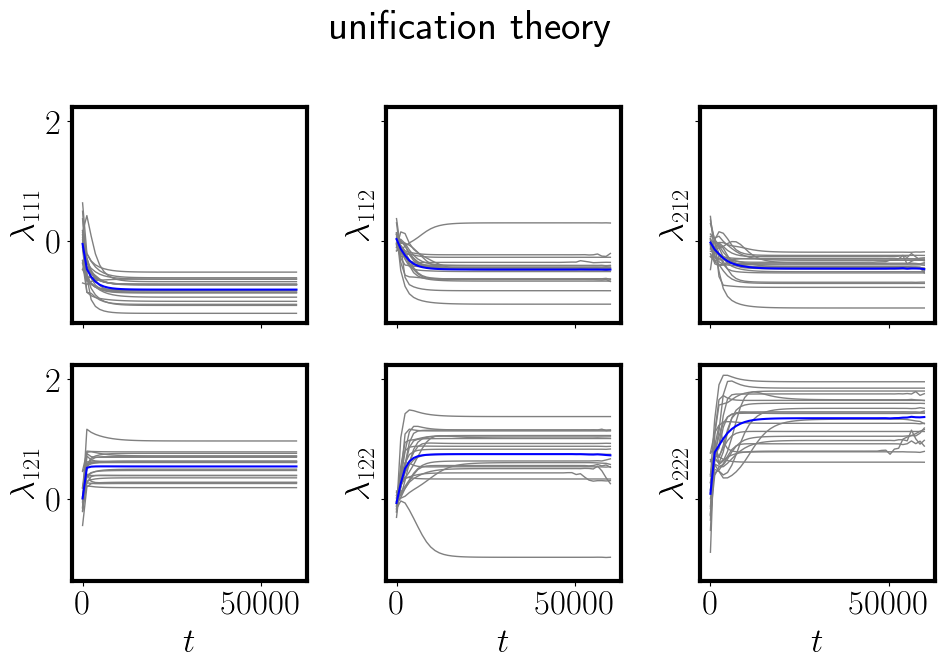

In [33]:
steps = 60001
ts = np.arange(0, steps, steps//50)

K_hist = np.load('data/training/n4/orth_data/ndata2/L48/RPASlKhist_n4L48_0.4_-5.0.npy')[::steps//50]
mu_hist = np.load('data/training/n4/orth_data/ndata2/L48/RPASlmuhist_n4L48_0.4_-5.0.npy')

lda_hist = np.zeros((51, 20, 2, 2, 2))
for i in range(51):
    for k in range(20):
        lda_hist[i, k] = ldaUT(K_hist[i, k], mu_hist[i, k])

fig, axs = plt.subplots(2, 3, figsize=(10, 7), sharex=True, sharey=True)

for i in range(2):
    for cc, (x, y) in enumerate(combinations_with_replacement(range(2), 2)): 
        axs[i, cc].plot(ts, lda_hist[:, :, x, i, y], lw=1, c='grey')
        axs[i, cc].plot(ts, np.mean(lda_hist[:, :, x, i, y], axis=1), c='b')
        axs[i, cc].set_ylabel(fr'$\lambda_{{{x+1} {i+1} {y+1}}}$')
        axs[1, cc].set_xlabel(r'$t$')
plt.suptitle('unification theory')
plt.tight_layout()

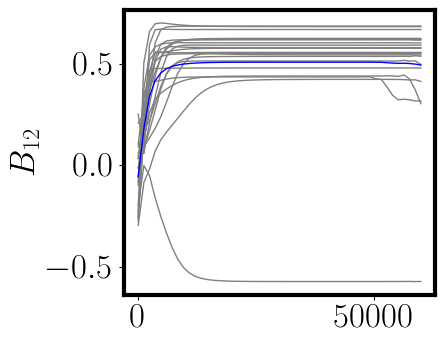

In [34]:
steps = 60001
ts = np.arange(0, steps, steps//50)

K_hist = np.load('data/training/n4/orth_data/ndata2/L48/RPASlKhist_n4L48_0.4_-5.0.npy')[::steps//50]

B_hist = np.zeros((51, 20, 2, 2))
for i in range(51):
    for k in range(20):
        B_hist[i, k] = KoffdiagRatio(K_hist[i, k])

fig, ax = plt.subplots(figsize=(5, 4))
ax.plot(ts, B_hist[:, :, 0, 1], c='grey', lw=1)
ax.plot(ts, np.mean(B_hist[:, :, 0, 1], axis=1), c='b', lw=1)
ax.set_ylabel(r'$B_{12}$')
plt.tight_layout()

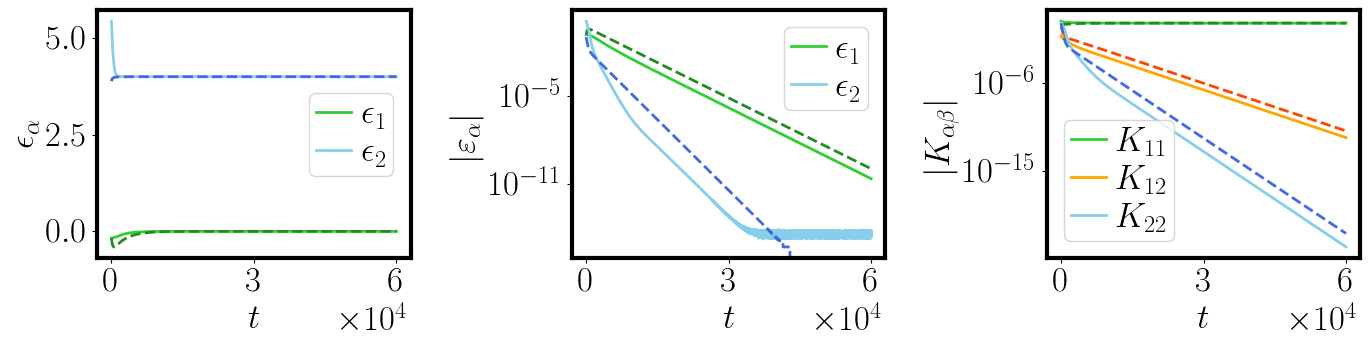

In [65]:
steps = int(6e4)+1
ts = np.arange(steps)
ndata = 2

idx = 9
eps_hist = np.load('data/training/n4/orth_data/ndata2/L48/RPASlepshist_n4L48_0.4_-5.0.npy')[:, idx]
K_hist = np.load('data/training/n4/orth_data/ndata2/L48/RPASlKhist_n4L48_0.4_-5.0.npy')[:, idx]
muend = np.load('data/training/n4/orth_data/ndata2/L48/RPASlmuhist_n4L48_0.4_-5.0.npy')[-1, idx]
ldaend = ldaUT(K_hist[-1], muend)
Aend = ldaend[:, range(2), range(2)].T
Bend = KoffdiagRatio(K_hist[-1])

Rs = np.array([0, 4])

eps_pred = np.zeros((steps, 2))
g_pred = np.zeros((steps, 2))
# prediction on epsilon (inside) and g (outside)
F = np.array([[K_hist[-1, 0, 0], Bend[0, 1]*Rs[1]*np.sqrt(K_hist[-1, 0, 0])], 
    [Aend[1, 0]*np.sqrt(K_hist[-1, 0, 0]), Aend[1, 1]*Rs[1]]])
Fvals, Pf = np.linalg.eig(F)
fs = np.linalg.inv(Pf) @ [eps_hist[0, 0], np.sqrt(K_hist[0, 1, 1])]
eps_pred[:, 0] = np.stack([fs[k]*Pf[0, k]*np.exp(-0.001*Fvals[k]*ts/ndata) for k in range(ndata)]).sum(axis=0)
g_pred[:, 1] = np.stack([fs[k]*Pf[1, k]*np.exp(-0.001*Fvals[k]*ts/ndata) for k in range(ndata)]).sum(axis=0)
# prediction on epsilon (outside) and g (inside)
for i in range(ndata//2, ndata):
    for (k, kp) in product(range(ndata), repeat=2):
        factor_in = np.sum([Bend[i, j]*np.sqrt(K_hist[-1, j, j])*Pf[j, kp] for j in range(ndata//2)])
        factor_out = np.sum([Bend[i, j]*Rs[j]*Pf[j, kp] for j in range(ndata//2, ndata)])
        eps_pred[:, i] += factor_in*factor_out*fs[k]*fs[kp]*Pf[i, k]/(Fvals[k] + Fvals[kp])\
            * np.exp(-0.001*(Fvals[k] + Fvals[kp])*ts/ndata)
    eps_pred[:, i] += Rs[i]
for i in range(ndata//2):
    for k in range(ndata):
        factor_in = np.sum([Aend[i, j]*np.sqrt(K_hist[-1, j, j])*Pf[j, k] for j in range(ndata//2)])
        factor_out = np.sum([Aend[i, j]*Rs[j]*Pf[j, k] for j in range(ndata//2, ndata)])
        g_pred[:, i] += factor_in*factor_out*fs[k]/Fvals[k]*np.exp(-0.001*Fvals[k]*ts/ndata)
    g_pred[:, i] += np.sqrt(K_hist[-1, i, i])

fig, axs = plt.subplots(1, 3, figsize=(14, 4))
cl = ['limegreen', 'skyblue']
cl2 = ['forestgreen', 'royalblue']
for i in range(2):
    axs[0].plot(eps_hist[:, i], lw=2, c=cl[i], label=fr'$\epsilon_{{{i+1}}}$')
    axs[0].plot(eps_pred[:, i], '--', lw=2, c=cl2[i])
axs[0].legend(handletextpad=0.3, labelspacing=0.2, borderpad=0.2, handlelength=1)
axs[0].set_xticks(np.arange(3)*3e4)
axs[0].ticklabel_format(axis='x', style='sci', scilimits=(0,0))
axs[0].set_ylabel(r'$\epsilon_\alpha$')

for i in range(2):
    axs[1].plot(np.abs(eps_hist[:, i] - Rs[i]), lw=2, c=cl[i], label=fr'$\epsilon_{{{i+1}}}$')
    axs[1].plot(np.abs(eps_pred[:, i] - Rs[i]), '--', lw=2, c=cl2[i])
axs[1].legend(handletextpad=0.3, labelspacing=0.2, borderpad=0.2, handlelength=1)
axs[1].set_yscale('log')
axs[1].set_xticks(np.arange(3)*3e4)
axs[1].ticklabel_format(axis='x', style='sci', scilimits=(0,0))
axs[1].set_ylabel(r'$|\varepsilon_\alpha|$')

clk = ['limegreen', 'orange', 'skyblue']
clk2 = ['forestgreen', 'orangered', 'royalblue']
for cc, (i, j) in enumerate(combinations_with_replacement(range(2), 2)):
    axs[2].plot(np.abs(K_hist[:, i, j]), lw=2, c=clk[cc], label=fr'$K_{{{i+1} {j+1}}}$')
    axs[2].plot(Bend[i, j] * g_pred[:, i] * g_pred[:, j], '--', lw=2, c=clk2[cc])
axs[2].legend(handletextpad=0.3, labelspacing=0.2, borderpad=0.2, handlelength=1)
axs[2].set_yscale('log')
axs[2].set_xticks(np.arange(3)*3e4)
axs[2].ticklabel_format(axis='x', style='sci', scilimits=(0,0))
axs[2].set_ylabel(r'$|K_{\alpha \beta}|$')

for i in range(3):
    axs[i].set_xlabel(r'$t$')

plt.tight_layout()
plt.show()
plt.close()

# Three-phase results & QNTK-based theories

In [3]:
steps = int(2e5) + 1

J_hist = np.load('data/training/n4/orth_data/ndata3/L48/RPASlJhist_n4L48_0.4_1.0_-5.0.npy')
K_hist = contract('trai, trbi->trab', J_hist, J_hist)
H_hist = np.load('data/training/n4/orth_data/ndata3/L48/RPASlHhist_n4L48_0.4_1.0_-5.0.npy')
mu_hist = contract('trai, trbij, trcj->trabc', J_hist[::steps//50], H_hist, J_hist[::steps//50])

np.save('data/training/n4/orth_data/ndata3/L48/RPASlKhist_n4L48_0.4_1.0_-5.0.npy', K_hist)
np.save('data/training/n4/orth_data/ndata3/L48/RPASlmuhist_n4L48_0.4_1.0_-5.0.npy', mu_hist)

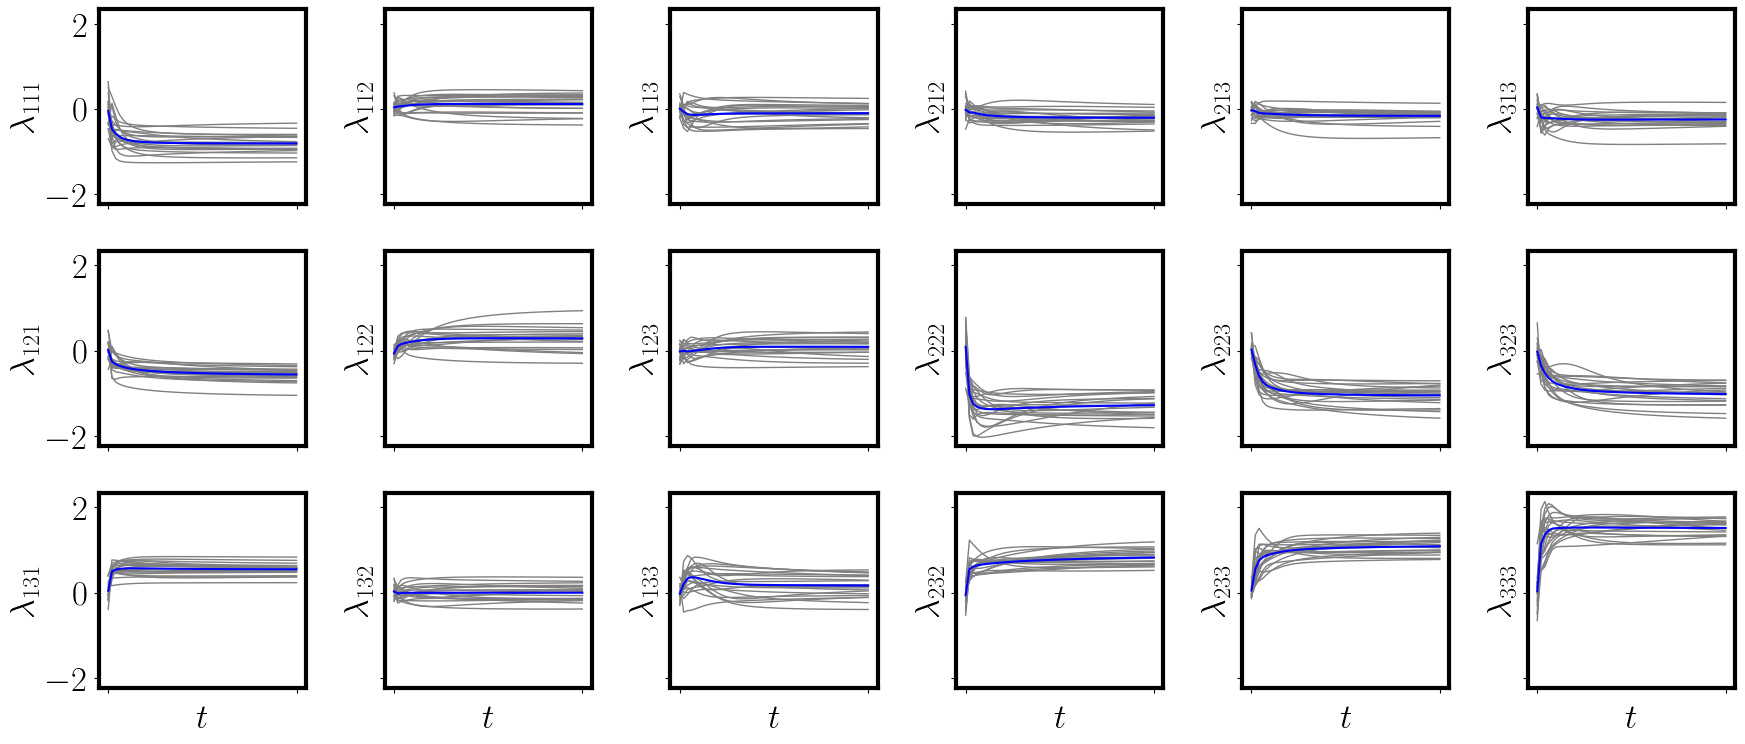

In [22]:
steps = int(1e5) + 1
ts = np.arange(0, steps, steps//50)

K_hist = np.load('data/training/n4/orth_data/ndata3/L48/RPASlKhist_n4L48_0.4_1.0_-5.0.npy')[::steps//50]
mu_hist = np.load('data/training/n4/orth_data/ndata3/L48/RPASlmuhist_n4L48_0.4_1.0_-5.0.npy')

lda_hist = np.zeros((51, 20, 3, 3, 3))
for i in range(51):
    for k in range(20):
        lda_hist[i, k] = ldaUT(K_hist[i, k], mu_hist[i, k])

fig, axs = plt.subplots(3, 6, figsize=(18, 8), sharex=True, sharey=True)

for i in range(3):
    for cc, (x, y) in enumerate(combinations_with_replacement(range(3), 2)): 
        axs[i, cc].plot(ts, lda_hist[:, :, x, i, y], lw=1, c='grey')
        axs[i, cc].plot(ts, np.mean(lda_hist[:, :, x, i, y], axis=1), c='b')
        axs[i, cc].set_ylabel(fr'$\lambda_{{{x+1} {i+1} {y+1}}}$')
        axs[2, cc].set_xlabel(r'$t$')
        axs[2, cc].set_xticklabels([])

plt.subplots_adjust(hspace=0.1)
plt.tight_layout()

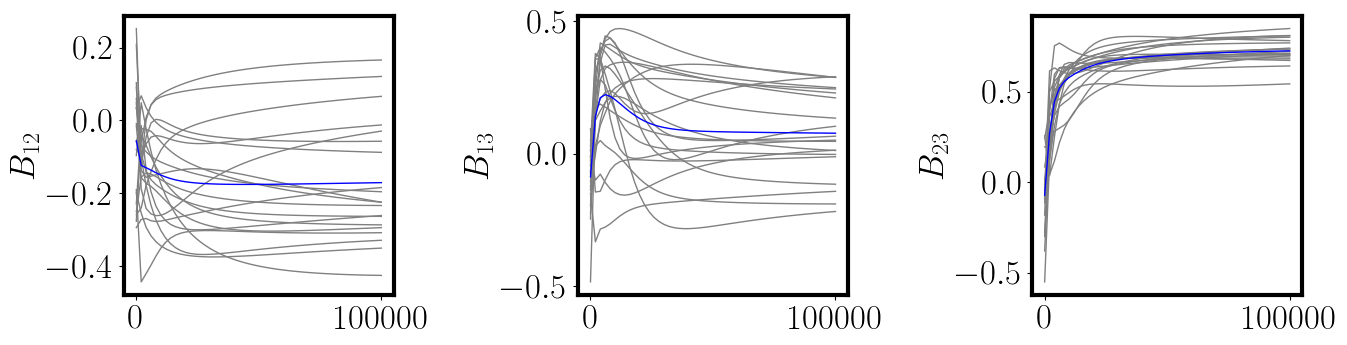

In [24]:
steps = int(1e5)+1
ts = np.arange(0, steps, steps//50)

K_hist = np.load('data/training/n4/orth_data/ndata3/L48/RPASlKhist_n4L48_0.4_1.0_-5.0.npy')[::steps//50]

B_hist = np.zeros((51, 20, 3, 3))
for i in range(51):
    for k in range(20):
        B_hist[i, k] = KoffdiagRatio(K_hist[i, k])

fig, axs = plt.subplots(1, 3, figsize=(14, 4))
for cc, (x, y) in enumerate(combinations(range(3), 2)):
    axs[cc].plot(ts, B_hist[:, :, x, y], c='grey', lw=1)
    axs[cc].plot(ts, np.mean(B_hist[:, :, x, y], axis=1), c='b', lw=1)
    axs[cc].set_ylabel(fr'$B_{{{x+1} {y+1}}}$')
plt.tight_layout()

In [39]:
Aend, \
Bend, eps_hist[0], np.sqrt(np.diag(K_hist[-1]))

(array([[-0.66450783,  0.21595892,  0.08670399],
        [ 0.54114446, -1.57955712, -1.3816506 ],
        [-0.10950818,  1.34234951,  1.77344787]]),
 array([[ 1.        , -0.32942657, -0.21849992],
        [-0.32942657,  1.        ,  0.78163126],
        [-0.21849992,  0.78163126,  1.        ]]),
 array([-0.47009515, -1.31447416,  4.41609992]),
 array([1.05383155, 0.28546396, 0.00194721]))

C:\Users\Bingzhi\AppData\Local\Temp\ipykernel_10520\3006319557.py:25: RuntimeWarning: invalid value encountered in power
  eps_pred[:, 0] = a1E/(a0E + 0.001*ts/ndata)**1.5


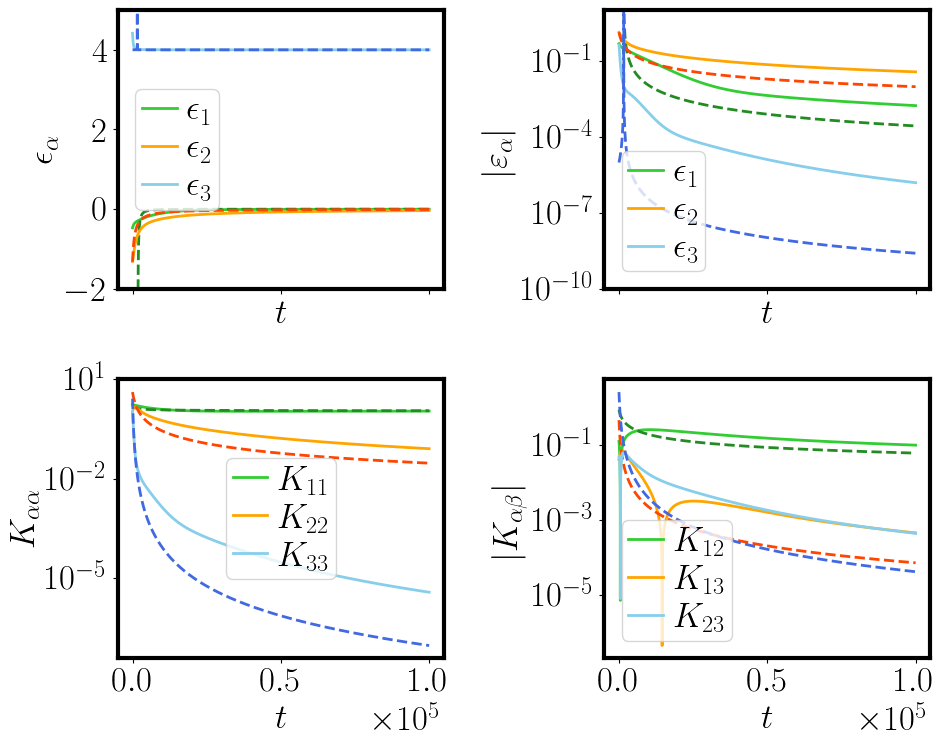

In [56]:
steps = int(1e5)+1
ts = np.arange(steps)
ndata = 3

idx = 10
eps_hist = np.load('data/training/n4/orth_data/ndata3/L48/RPASlepshist_n4L48_0.4_1.0_-5.0.npy')[:, idx]
K_hist = np.load('data/training/n4/orth_data/ndata3/L48/RPASlKhist_n4L48_0.4_1.0_-5.0.npy')[:, idx]
muend = np.load('data/training/n4/orth_data/ndata3/L48/RPASlmuhist_n4L48_0.4_1.0_-5.0.npy')[-1, idx]
ldaend = ldaUT(K_hist[-1], muend)
Aend = ldaend[:, range(ndata), range(ndata)].T
Bend = KoffdiagRatio(K_hist[-1])

Rs = np.array([0, 0, 4])

eps_pred = np.zeros((steps, 3))
g_pred = np.zeros((steps, 3))
# prediction on epsilon (crit) and g (crit)
c1E, c1G = -0.316544, 1
c0 = 0.24
eps_pred[:, 1] = c1E/(0.001*ts/ndata + c0)
g_pred[:, 1] = c1G/np.sqrt(0.001*ts/ndata + c0)
# prediction on epsilont (inside) and g (outside)
a1E, a3G = -0.050, 0.059
a0E, a0G = -0.532564, 0.109656
eps_pred[:, 0] = a1E/(a0E + 0.001*ts/ndata)**1.5
g_pred[:, 2] = a3G/(a0G + 0.001*ts/ndata)**1.5
# prediction on epsilon (outside) and g (inside)
factor_in = Bend[2, 0]*np.sqrt(K_hist[-1, 0, 0])*a1E
factor_crit = Bend[2, 1]*c1E*c1G
factor_out = Bend[2, 2]*Rs[2]*a3G
eps_pred[:, 2] = a3G/2*(factor_in + factor_crit + factor_out)/(a0E + 0.001*ts/ndata)**2 + Rs[2]
factor_in = Aend[0, 1]*np.sqrt(K_hist[-1, 0, 0])*a1E
factor_crit = Bend[0, 1]*c1E*c1G
factor_out = Bend[0, 2]*Rs[2]*a3G
g_pred[:, 0] = 2*(factor_in + factor_crit + factor_out)/np.sqrt(a0G + 0.001*ts/ndata) + np.sqrt(K_hist[-1, 0, 0])
# for i in range(ndata//2, ndata):
#     for (k, kp) in product(range(ndata), repeat=2):
#         factor_in = np.sum([Bend[i, j]*np.sqrt(K_hist[-1, j, j])*Pf[j, kp] for j in range(ndata//2)])
#         factor_out = np.sum([Bend[i, j]*Rs[j]*Pf[j, kp] for j in range(ndata//2, ndata)])
#         eps_pred[:, i] += factor_in*factor_out*fs[k]*fs[kp]*Pf[i, k]/(Fvals[k] + Fvals[kp])\
#             * np.exp(-0.001*(Fvals[k] + Fvals[kp])*ts/ndata)
#     eps_pred[:, i] += Rs[i]
# for i in range(ndata//2):
#     for k in range(ndata):
#         factor_in = np.sum([Aend[i, j]*np.sqrt(K_hist[-1, j, j])*Pf[j, k] for j in range(ndata//2)])
#         factor_out = np.sum([Aend[i, j]*Rs[j]*Pf[j, k] for j in range(ndata//2, ndata)])
#         g_pred[:, i] += factor_in*factor_out*fs[k]/Fvals[k]*np.exp(-0.001*Fvals[k]*ts/ndata)
#     g_pred[:, i] += np.sqrt(K_hist[-1, i, i])

fig, axs = plt.subplots(2, 2, figsize=(10, 8), sharex=True)
cl = ['limegreen', 'orange', 'skyblue']
cl2 = ['forestgreen', 'orangered', 'royalblue']
for i in range(ndata):
    axs[0, 0].plot(eps_hist[:, i], lw=2, c=cl[i], label=fr'$\epsilon_{{{i+1}}}$')
    axs[0, 0].plot(eps_pred[:, i], '--', lw=2, c=cl2[i])
axs[0, 0].legend(handletextpad=0.3, labelspacing=0.2, borderpad=0.2, handlelength=1)
axs[0, 0].set_xticks(np.arange(3)*5e4)
axs[0, 0].set_ylim(-2, 5)
axs[0, 0].set_ylabel(r'$\epsilon_\alpha$')

for i in range(ndata):
    axs[0, 1].plot(np.abs(eps_hist[:, i] - Rs[i]), lw=2, c=cl[i], label=fr'$\epsilon_{{{i+1}}}$')
    axs[0, 1].plot(np.abs(eps_pred[:, i] - Rs[i]), '--', lw=2, c=cl2[i])
axs[0, 1].legend(handletextpad=0.3, labelspacing=0.2, borderpad=0.2, handlelength=1)
axs[0, 1].set_yscale('log')
axs[0, 1].set_ylim(1e-10, 10)
axs[0, 1].set_ylabel(r'$|\varepsilon_\alpha|$')

for i in range(ndata):
    axs[1, 0].plot(K_hist[:, i, i], lw=2, c=cl[i], label=fr'$K_{{{i+1} {i+1}}}$')
    axs[1, 0].plot(g_pred[:, i]**2, '--', lw=2, c=cl2[i])
axs[1, 0].legend(handletextpad=0.3, labelspacing=0.2, borderpad=0.2, handlelength=1)
axs[1, 0].set_ylabel(r'$K_{\alpha \alpha}$')
axs[1, 0].set_yscale('log')
axs[1, 0].set_xticks(np.arange(3)*5e4)
axs[1, 0].ticklabel_format(axis='x', style='sci', scilimits=(0,0))

for cc, (i, j) in enumerate(combinations(range(ndata), 2)):
    axs[1, 1].plot(np.abs(K_hist[:, i, j]), lw=2, c=cl[cc], label=fr'$K_{{{i+1} {j+1}}}$')
    axs[1, 1].plot(np.abs(Bend[i, j] * g_pred[:, i] * g_pred[:, j]), '--', lw=2, c=cl2[cc])
axs[1, 1].legend(handletextpad=0.3, labelspacing=0.2, borderpad=0.2, handlelength=1)
axs[1, 1].set_ylabel(r'$|K_{\alpha \beta}|$')
axs[1, 1].set_yscale('log')
axs[1, 1].set_xticks(np.arange(3)*5e4)
axs[1, 1].ticklabel_format(axis='x', style='sci', scilimits=(0,0))


for i in range(4):
    axs[i//2, i%2].set_xlabel(r'$t$')

plt.tight_layout()
plt.show()
plt.close()

# Summary

## Dynamics

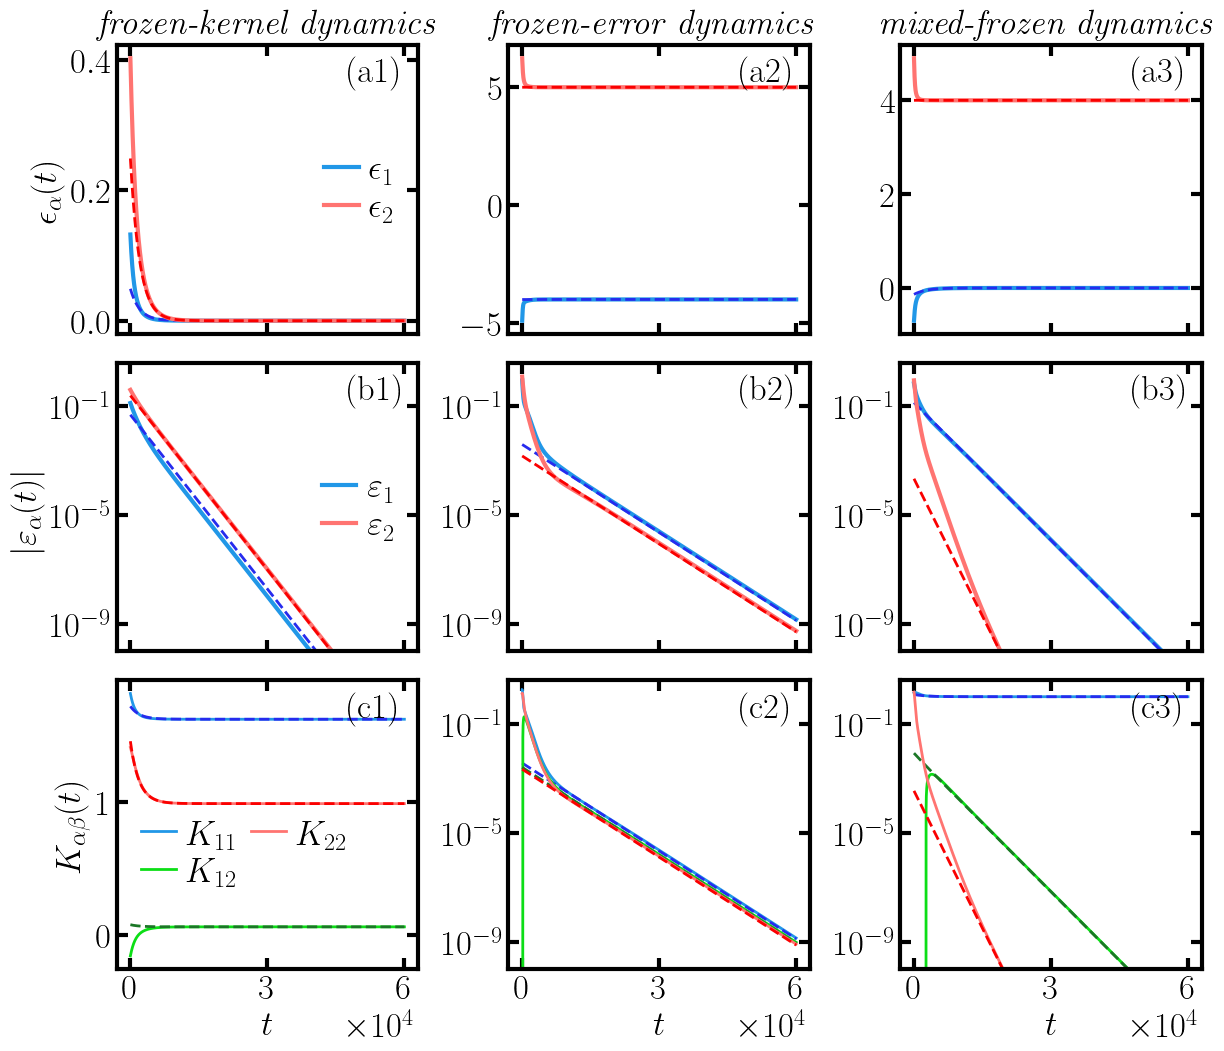

In [4]:
# asymptotic theory
steps = 60001
ts = np.arange(steps)
ndata = 2
tlate = int(1e4) + 1

# frozen-kernel phase
idx = 12
eps_hist_fro_k = np.load('data/training/n4/orth_data/ndata2/L48/RPASlepshist_n4L48_0.3_-0.5.npy')[:, idx]
K_hist_fro_k = np.load('data/training/n4/orth_data/ndata2/L48/RPASlKhist_n4L48_0.3_-0.5.npy')[:, idx]
muend_fro_k = np.load('data/training/n4/orth_data/ndata2/L48/RPASlmuhist_n4L48_0.3_-0.5.npy')[-1, idx]
g_hist_fro_k = np.sqrt(K_hist_fro_k[:, range(ndata), range(ndata)])

ldaend_fro_k = ldaUT(K_hist_fro_k[-1], muend_fro_k)
Aend_fro_k = ldaend_fro_k[range(2), range(2)]
Bend_fro_k = KoffdiagRatio(K_hist_fro_k[-1])

E = np.copy(Bend_fro_k)
for i in range(ndata):
    E[i] *= np.sqrt(g_hist_fro_k[-1, i] * g_hist_fro_k[-1])
Evals, Pe = np.linalg.eigh(E)
bs = Pe.T @ eps_hist_fro_k[tlate]
bs *= np.exp(0.001*Evals*tlate/ndata)
minx = np.argmin(Evals)
# prediction on epsilon
eps_pred_fro_k = np.zeros((steps, ndata))
for i in range(ndata):
    eps_pred_fro_k[:, i] = bs[minx]*Pe[i, minx]*np.exp(-0.001*Evals[minx]*ts/ndata)
# prediction on g
g_pred_fro_k = np.zeros_like(eps_pred_fro_k)
factors = Aend_fro_k @ np.diag(g_hist_fro_k[-1]) @ Pe
for i in range(ndata):
    g_pred_fro_k[:, i] = bs[minx]*factors[i, minx]/Evals[minx]*np.exp(-0.001*Evals[minx]*ts/ndata)
g_pred_fro_k += g_hist_fro_k[-1]

# frozen-error phase
idx = 15
eps_hist_fro_e = np.load('data/training/n4/orth_data/ndata2/L48/RPASlepshist_n4L48_5_-6.npy')[:, idx]
K_hist_fro_e = np.load('data/training/n4/orth_data/ndata2/L48/RPASlKhist_n4L48_5_-6.npy')[:, idx]
muend_fro_e = np.load('data/training/n4/orth_data/ndata2/L48/RPASlmuhist_n4L48_5_-6.npy')[-1, idx]
g_hist_fro_e = np.sqrt(K_hist_fro_e[:, range(ndata), range(ndata)])

Rs_fro_e = np.array([-4, 5])
ldaend_fro_e = ldaUT(K_hist_fro_e[-1], muend_fro_e)
Aend_fro_e = ldaend_fro_e[range(2), range(2)]
Bend_fro_e = KoffdiagRatio(K_hist_fro_e[-1])
# predict on g
G = Aend_fro_e @ np.diag(Rs_fro_e)
Gvals, Pg = np.linalg.eig(G)
bs = np.linalg.inv(Pg) @ g_hist_fro_e[tlate]
bs *= np.exp(0.001*Gvals*tlate/ndata)
minx = np.argmin(Gvals)
g_pred_fro_e = np.zeros((steps, ndata))
for i in range(ndata):
    g_pred_fro_e[:, i] = bs[minx] * Pg[i, minx] * np.exp(-0.001*Gvals[minx]*ts/ndata)
# predict on epsilon
eps_pred_fro_e = np.zeros_like(g_pred_fro_e)
factors = Bend_fro_e @ np.diag(Rs_fro_e) @ Pg
for i in range(ndata):
    eps_pred_fro_e[:, i] = factors[i, minx]*bs[minx]**2*Pg[i, minx]/(2*Gvals[minx])\
        *np.exp(-0.001*2*Gvals[minx]*ts/ndata)
eps_pred_fro_e += Rs_fro_e

# mixed-frozen phase
idx = 11
eps_hist_mix_fro = np.load('data/training/n4/orth_data/ndata2/L48/RPASlepshist_n4L48_0.4_-5.0.npy')[:, idx]
K_hist_mix_fro = np.load('data/training/n4/orth_data/ndata2/L48/RPASlKhist_n4L48_0.4_-5.0.npy')[:, idx]
muend_mix_fro = np.load('data/training/n4/orth_data/ndata2/L48/RPASlmuhist_n4L48_0.4_-5.0.npy')[-1, idx]
g_hist_mix_fro = np.sqrt(K_hist_mix_fro[:, range(ndata), range(ndata)])

Rs_mix_fro = np.array([0, 4])
ldaend_mix_fro = ldaUT(K_hist_mix_fro[-1], muend_mix_fro)
Aend_mix_fro = ldaend_mix_fro[range(2), range(2)]
Bend_mix_fro = KoffdiagRatio(K_hist_mix_fro[-1])

eps_pred_mix_fro = np.zeros((steps, ndata))
g_pred_mix_fro = np.zeros((steps, ndata))
# prediction on epsilon (inside) and g (outside)
F = np.array([[g_hist_mix_fro[-1, 0]**2, g_hist_mix_fro[-1, 0]*Bend_mix_fro[0, 1]*Rs_mix_fro[1]], 
    [Aend_mix_fro[1, 0]*g_hist_mix_fro[-1, 0], Aend_mix_fro[1, 1]*Rs_mix_fro[1]]])
Fvals, Pf = np.linalg.eig(F)
xmin = np.argmin(Fvals)
fs = np.linalg.inv(Pf) @ [eps_hist_mix_fro[tlate, 0], g_hist_mix_fro[tlate, 1]]
fs *= np.exp(0.001*Fvals*tlate/ndata)
eps_pred_mix_fro[:, 0] = fs[xmin]*Pf[0, xmin]*np.exp(-0.001*Fvals[xmin]*ts/ndata)
g_pred_mix_fro[:, 1] = fs[xmin]*Pf[1, xmin]*np.exp(-0.001*Fvals[xmin]*ts/ndata)
factor1 = Bend_mix_fro[1, 0]*g_hist_mix_fro[-1, 0]*Pf[0, xmin] + Bend_mix_fro[1, 1]*Rs_mix_fro[1]*Pf[1, xmin]
factor2 = Aend_mix_fro[0, 0]*g_hist_mix_fro[-1, 0]*Pf[0, xmin] + Aend_mix_fro[0, 1]*Rs_mix_fro[1]*Pf[1, xmin]
eps_pred_mix_fro[:, 1] = factor1*fs[xmin]**2*Pf[1, xmin]/(2*Fvals[xmin])*np.exp(-2*0.001*Fvals[xmin]*ts/ndata)\
    + Rs_mix_fro[1]
g_pred_mix_fro[:, 0] = factor2*fs[xmin]/Fvals[xmin]*np.exp(-0.001*Fvals[xmin]*ts/ndata) + g_hist_mix_fro[-1, 0]


fig, axs = plt.subplots(3, 3, figsize=(14, 12), sharex=True)
cl = ['#2197E7', '#FF7471']
cl2 = ['#262BEE', '#FA0000']
clk = ['#2197E7', '#0CDE16', '#FF7471']
clk2 = ['#262BEE', '#1B7726', '#FA0000']

for i in range(2):
    # frozen-kernel phase
    axs[0, 0].plot(np.abs(eps_hist_fro_k[:, i]), lw=3, c=cl[i], label=fr'$\epsilon_{{{i+1}}}$')
    axs[0, 0].plot(np.abs(eps_pred_fro_k[:, i]), '--', lw=2, c=cl2[i])
    axs[1, 0].plot(np.abs(eps_hist_fro_k[:, i]), lw=3, c=cl[i], label=fr'$\varepsilon_{{{i+1}}}$')
    axs[1, 0].plot(np.abs(eps_pred_fro_k[:, i]), '--', lw=2, c=cl2[i])
    # frozen-error phase
    axs[0, 1].plot(eps_hist_fro_e[:, i], lw=3, c=cl[i])
    axs[0, 1].plot(eps_pred_fro_e[:, i], '--', lw=2, c=cl2[i])
    axs[1, 1].plot(np.abs(eps_hist_fro_e[:, i] - Rs_fro_e[i]), lw=3, c=cl[i])
    axs[1, 1].plot(np.abs(eps_pred_fro_e[:, i] - Rs_fro_e[i]), '--', lw=2, c=cl2[i])
    # mixed-frozen phase
    axs[0, 2].plot(eps_hist_mix_fro[:, i], lw=3, c=cl[i])
    axs[0, 2].plot(eps_pred_mix_fro[:, i], '--', lw=2, c=cl2[i])
    axs[1, 2].plot(np.abs(eps_hist_mix_fro[:, i] - Rs_mix_fro[i]), lw=3, c=cl[i])
    axs[1, 2].plot(np.abs(eps_pred_mix_fro[:, i] - Rs_mix_fro[i]), '--', lw=2, c=cl2[i])

for cc, (i, j) in enumerate(combinations_with_replacement(range(2), 2)):
    # frozen-kernel phase
    axs[2, 0].plot(K_hist_fro_k[:, i, j], lw=2, c=clk[cc], label=fr'$K_{{{i+1} {j+1}}}$')
    axs[2, 0].plot(Bend_fro_k[i,j]*g_pred_fro_k[:, i]*g_pred_fro_k[:, j], '--', lw=2, c=clk2[cc])
    # frozen-error phase
    axs[2, 1].plot(K_hist_fro_e[:, i, j], lw=2, c=clk[cc])
    axs[2, 1].plot(Bend_fro_e[i,j]*g_pred_fro_e[:, i]*g_pred_fro_e[:, j], '--', lw=2, c=clk2[cc])
    # mixed-frozen phase
    axs[2, 2].plot(K_hist_mix_fro[:, i, j], lw=2, c=clk[cc])
    axs[2, 2].plot(Bend_mix_fro[i, j]*g_pred_mix_fro[:, i]*g_pred_mix_fro[:, j], '--', lw=2, c=clk2[cc])

for i in range(3):
    axs[2, i].set_xlabel(r'$t$')
    axs[1, i].set_yscale('log')
    axs[1, i].set_ylim(1e-10, 4)
    axs[1, i].set_yticks([1e-1, 1e-5, 1e-9])
axs[0, 0].set_ylabel(r'$\epsilon_\alpha(t)$')    
axs[1, 0].set_ylabel(r'$|\varepsilon_\alpha(t)|$')
axs[2, 0].set_ylabel(r'$K_{\alpha \beta}(t)$')

for i in range(2):
    axs[2, i+1].set_yscale('log')
    axs[2, i+1].set_ylim(1e-10, 4)
    axs[2, i+1].set_yticks([1e-1, 1e-5, 1e-9])

axs[0, 0].set_xticks(np.arange(3)*3e4)
axs[0, 0].ticklabel_format(axis='x', style='sci', scilimits=(0,0))
for i in range(9):
    axs[i//3, i%3].tick_params(direction='in', length=8, width=3, top='on', right='on')

for i in range(2):
    axs[i, 0].legend(handletextpad=0.3, labelspacing=0.2, borderpad=0.2, handlelength=1, framealpha=0,
        loc='center right')
axs[2, 0].legend(handletextpad=0.3, labelspacing=0.2, borderpad=0.2, handlelength=1, framealpha=0,
    ncol=2, columnspacing=0.4, loc='center left', bbox_to_anchor=(0, 0.4))

xpos = [0.29, 0.57, 0.85]
ypos = [0.85, 0.585, 0.32]
for i in range(9):
    fig.text(x=xpos[i%3], y=ypos[i//3], s=fr'$\rm ({chr(97+i//3)} {i%3 + 1})$')
fig.text(0.11, 0.89, '\it frozen-kernel dynamics')
fig.text(0.39, 0.89, '\it frozen-error dynamics')
fig.text(0.67, 0.89, '\it mixed-frozen dynamics')

plt.subplots_adjust(wspace=0.3, hspace=0.1)
plt.savefig('figures/exp_class_N2.pdf', bbox_inches='tight')
plt.show()
plt.close()

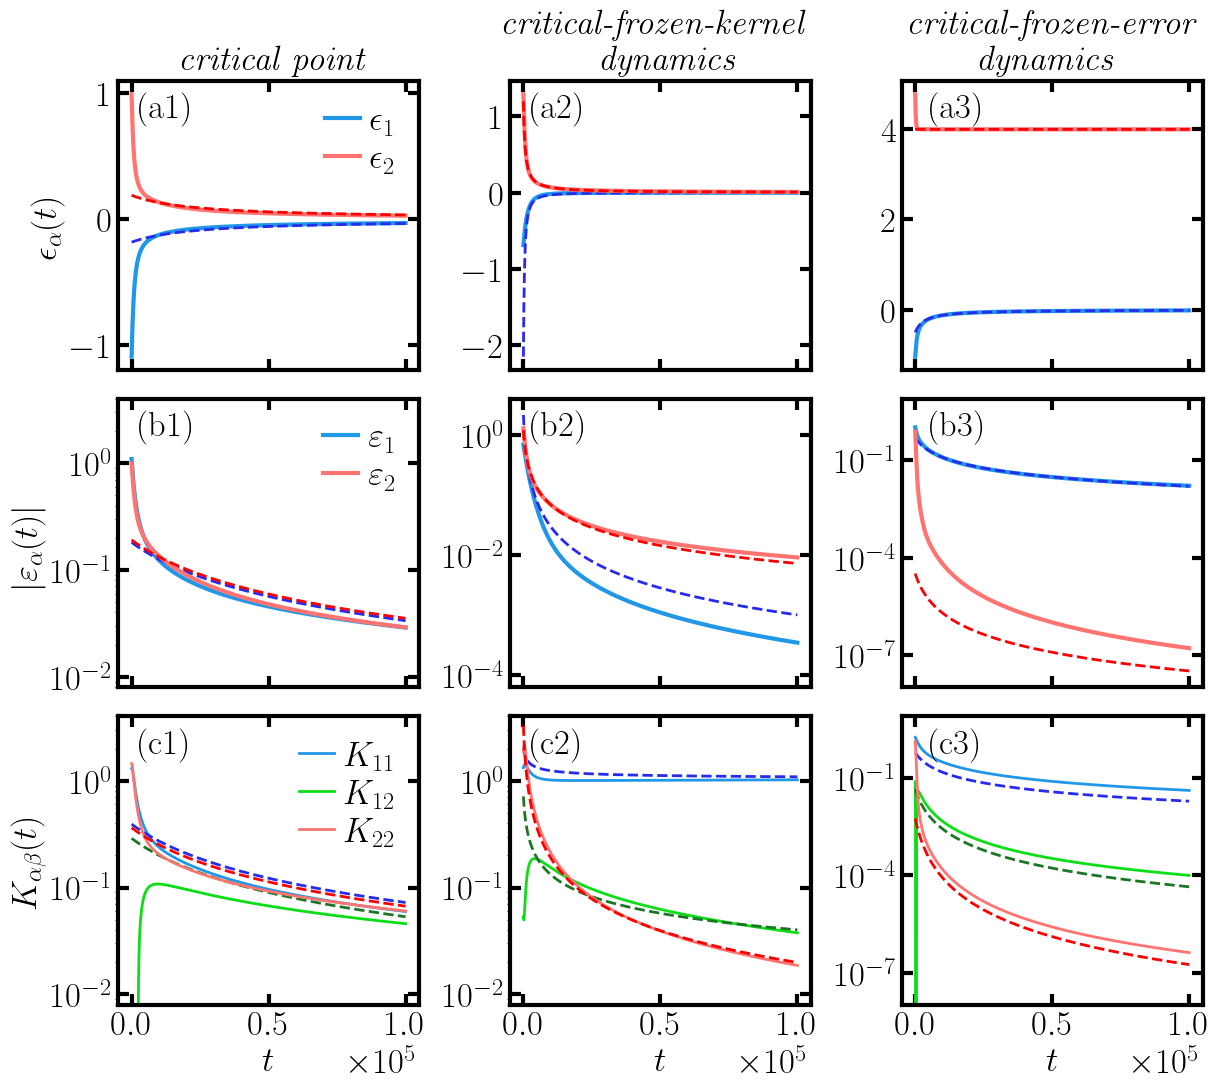

In [3]:
# asymptotic theory
steps = int(1e5) + 1
ts = np.arange(steps)
ndata = 2
tlate = int(1e4) + 1

# critical point
idx = 2
eps_hist_c = np.load('data/training/n4/orth_data/ndata2/L48/RPASlepshist_n4L48_1_-1.npy')[:, idx]
K_hist_c = np.load('data/training/n4/orth_data/ndata2/L48/RPASlKhist_n4L48_1_-1.npy')[:, idx]
muend_c = np.load('data/training/n4/orth_data/ndata2/L48/RPASlmuhist_n4L48_1_-1.npy')[-1, idx]
g_hist_c = np.sqrt(K_hist_c[:, range(ndata), range(ndata)])

ldaend_c = ldaUT(K_hist_c[-1], muend_c)
Aend_c = ldaend_c[range(ndata), range(ndata)]
Bend_c = KoffdiagRatio(K_hist_c[-1])
cs_E_c = [-2.05186, 2.1608]
cs_G_c = [2.10723, 2.0254]
c0_c = np.mean(np.array(cs_E_c)/eps_hist_c[tlate] - 0.001*tlate/ndata)
eps_pred_c = np.stack([cs_E_c[k]/(c0_c + 0.001*ts/ndata) for k in range(2)]).T
g_pred_c = np.stack([cs_G_c[k]/np.sqrt(c0_c + 0.001*ts/ndata) for k in range(2)]).T

# critical-frozen-kernel phase
idx = 5
eps_hist_c_fro_k = np.load('data/training/n4/orth_data/ndata2/L48/RPASlepshist_n4L48_0.4_-1.0.npy')[:, idx]
K_hist_c_fro_k = np.load('data/training/n4/orth_data/ndata2/L48/RPASlKhist_n4L48_0.4_-1.0.npy')[:, idx]
muend_c_fro_k = np.load('data/training/n4/orth_data/ndata2/L48/RPASlmuhist_n4L48_0.4_-1.0.npy')[-1, idx]
g_hist_c_fro_k = np.sqrt(K_hist_c_fro_k[:, range(ndata), range(ndata)])

ldaend_c_fro_k = ldaUT(K_hist_c_fro_k[-1], muend_c_fro_k)
Aend_c_fro_k = ldaend_c_fro_k[range(ndata), range(ndata)]
Bend_c_fro_k = KoffdiagRatio(K_hist_c_fro_k[-1])

eps_pred_c_fro_k = np.zeros((steps, ndata))
g_pred_c_fro_k = np.zeros((steps, ndata))
# prediction on data at boundary
c1E_c_fro_k, c1G_c_fro_k = 0.365506, 1
c0_c_fro_k = c1E_c_fro_k/eps_hist_c_fro_k[tlate, 1] - 0.001*tlate/ndata
eps_pred_c_fro_k[:, 1] = c1E_c_fro_k/(0.001*ts/ndata + c0_c_fro_k)
g_pred_c_fro_k[:, 1] = c1G_c_fro_k/np.sqrt(0.001*ts/ndata + c0_c_fro_k)
# prediction on data inside
a1E_c_fro_k = - Bend_c_fro_k[0, 1]*c1E_c_fro_k*c1G_c_fro_k/(Bend_c_fro_k[0, 1]*g_hist_c_fro_k[-1, 0])
eps_pred_c_fro_k[:, 0] = a1E_c_fro_k/(0.001*ts/ndata + c0_c_fro_k)**1.5
a1G_c_fro_k  = 2*(Aend_c_fro_k[0, 0]*g_hist_c_fro_k[-1, 0]*a1E_c_fro_k
    + Aend_c_fro_k[0, 1]*c1E_c_fro_k*c1G_c_fro_k)
g_pred_c_fro_k[:, 0] = a1G_c_fro_k/np.sqrt(c0_c_fro_k + 0.001 * ts/ndata) + g_hist_c_fro_k[-1, 0]

# critical-frozen-error phase
idx = 1
eps_hist_c_fro_err = np.load('data/training/n4/orth_data/ndata2/L48/RPASlepshist_n4L48_1_-5.npy')[:, idx]
K_hist_c_fro_err = np.load('data/training/n4/orth_data/ndata2/L48/RPASlKhist_n4L48_1_-5.npy')[:, idx]
muend_c_fro_err = np.load('data/training/n4/orth_data/ndata2/L48/RPASlmuhist_n4L48_1_-5.npy')[-1, idx]
g_hist_c_fro_err = np.sqrt(K_hist_c_fro_err[:, range(ndata), range(ndata)])

Rs_c_fro_err = np.array([0, 4])
ldaend_c_fro_err = ldaUT(K_hist_c_fro_err[-1], muend_c_fro_err)
Aend_c_fro_err = ldaend_c_fro_err[range(2), range(2)]
Bend_c_fro_err = KoffdiagRatio(K_hist_c_fro_err[-1])

eps_pred_c_fro_err = np.zeros((steps, 2))
g_pred_c_fro_err = np.zeros((steps, 2))
# prediction on data at boundary
c1E_c_fro_err, c1G_c_fro_err = -0.821545, 1
c0_c_fro_err = c1E_c_fro_err/eps_hist_c_fro_err[tlate, 0] - 0.001*tlate/ndata
eps_pred_c_fro_err[:, 0] = c1E_c_fro_err/(0.001*ts/ndata + c0_c_fro_err)
g_pred_c_fro_err[:, 0] = c1G_c_fro_err/np.sqrt(0.001*ts/ndata + c0_c_fro_err)
# prediction on data outside
a1G_c_fro_err = - Aend_c_fro_err[1, 0]*c1E_c_fro_err*c1G_c_fro_err\
    /(Aend_c_fro_err[1, 1]*Rs_c_fro_err[1])
g_pred_c_fro_err[:, 1] = a1G_c_fro_err/(0.001*ts/ndata + c0_c_fro_err)**1.5
a1E_c_fro_err = (Bend_c_fro_err[1, 0]*a1G_c_fro_err*c1E_c_fro_err*c1G_c_fro_err
     + Bend_c_fro_err[1, 1]*Rs_c_fro_err[1]*a1G_c_fro_err**2)/2
eps_pred_c_fro_err[:, 1] = a1E_c_fro_err/(c0_c_fro_err + 0.001*ts/ndata)**2 + Rs_c_fro_err[1]


fig, axs = plt.subplots(3, 3, figsize=(14, 12), sharex=True)
cl = ['#2197E7', '#FF7471']
cl2 = ['#262BEE', '#FA0000']
clk = ['#2197E7', '#0CDE16', '#FF7471']
clk2 = ['#262BEE', '#1B7726', '#FA0000']

for i in range(2):
    # critical point
    axs[0, 0].plot(eps_hist_c[:, i], lw=3, c=cl[i], label=fr'$\epsilon_{{{i+1}}}$')
    axs[0, 0].plot(eps_pred_c[:, i], '--', lw=2, c=cl2[i])
    axs[1, 0].plot(np.abs(eps_hist_c[:, i]), lw=3, c=cl[i], label=fr'$\varepsilon_{{{i+1}}}$')
    axs[1, 0].plot(np.abs(eps_pred_c[:, i]), '--', lw=2, c=cl2[i])
    # critical-frozen-kernel phase
    axs[0, 1].plot(eps_hist_c_fro_k[:, i], lw=3, c=cl[i])
    axs[0, 1].plot(eps_pred_c_fro_k[:, i], '--', lw=2, c=cl2[i])
    axs[1, 1].plot(np.abs(eps_hist_c_fro_k[:, i]), lw=3, c=cl[i])
    axs[1, 1].plot(np.abs(eps_pred_c_fro_k[:, i]), '--', lw=2, c=cl2[i])
    # critical-frozen-error phase
    axs[0, 2].plot(eps_hist_c_fro_err[:, i], lw=3, c=cl[i])
    axs[0, 2].plot(eps_pred_c_fro_err[:, i], '--', lw=2, c=cl2[i])
    axs[1, 2].plot(np.abs(eps_hist_c_fro_err[:, i] - Rs_c_fro_err[i]), lw=3, c=cl[i])
    axs[1, 2].plot(np.abs(eps_pred_c_fro_err[:, i] - Rs_c_fro_err[i]), '--', lw=2, c=cl2[i])


for cc, (i, j) in enumerate(combinations_with_replacement(range(2), 2)):
    # critical point
    axs[2, 0].plot(K_hist_c[:, i, j], lw=2, c=clk[cc], label=fr'$K_{{{i+1} {j+1}}}$')
    axs[2, 0].plot(Bend_c[i,j]*g_pred_c[:, i]*g_pred_c[:, j], '--', lw=2, c=clk2[cc])
    # critical-frozen-kernel phase
    axs[2, 1].plot(K_hist_c_fro_k[:, i, j], lw=2, c=clk[cc])
    axs[2, 1].plot(Bend_c_fro_k[i,j]*g_pred_c_fro_k[:, i]*g_pred_c_fro_k[:, j], '--', 
        lw=2, c=clk2[cc])
    # critical-frozen-error phase
    axs[2, 2].plot(K_hist_c_fro_err[:, i, j], lw=2, c=clk[cc])
    axs[2, 2].plot(Bend_c_fro_err[i,j]*g_pred_c_fro_err[:, i]*g_pred_c_fro_err[:, j], '--', 
        lw=2, c=clk2[cc])

for i in range(3):
    axs[2, i].set_xlabel(r'$t$')
    axs[1, i].set_yscale('log')
    axs[2, i].set_yscale('log')

for i in range(2):
    axs[1+i, 0].set_ylim(10**-2.1, 4)
    axs[1+i, 2].set_ylim(10**-8, 8)
    axs[1+i, 2].set_yticks([1e-7, 1e-4, 0.1])
axs[1, 1].set_ylim(10**-4.2, 4)
axs[1, 1].set_yticks([1e-4, 1e-2, 1])
axs[2, 1].set_ylim(10**-2.1, 4)
axs[2, 1].set_yticks([1e-2, 0.1, 1])

axs[0, 0].set_ylabel(r'$\epsilon_\alpha(t)$')    
axs[1, 0].set_ylabel(r'$|\varepsilon_\alpha(t)|$')
axs[2, 0].set_ylabel(r'$K_{\alpha \beta}(t)$')

axs[0, 0].set_xticks(np.arange(3)*5e4)
axs[0, 0].ticklabel_format(axis='x', style='sci', scilimits=(0,0))
for i in range(9):
    axs[i//3, i%3].tick_params(direction='in', length=8, width=3, top='on', right='on')

for i in range(2):
    axs[i, 0].legend(handletextpad=0.3, labelspacing=0.2, borderpad=0.2, handlelength=1, framealpha=0,
        loc='upper right')
axs[2, 0].legend(handletextpad=0.3, labelspacing=0.2, borderpad=0.2, handlelength=1, framealpha=0,
    loc='upper right')

xpos = [0.14, 0.42, 0.705]
ypos = [0.85, 0.585, 0.32]
for i in range(9):
    fig.text(x=xpos[i%3], y=ypos[i//3], s=fr'$\rm ({chr(97+i//3)} {i%3 + 1})$')
fig.text(0.17, 0.89, '\it critical point')
fig.text(0.4, 0.92, '\it critical-frozen-kernel')
fig.text(0.47, 0.89, '\it dynamics')
fig.text(0.69, 0.92, '\it critical-frozen-error')
fig.text(0.74, 0.89, '\it dynamics')

plt.subplots_adjust(wspace=0.3, hspace=0.1)
#plt.savefig('figures/poly_class_N2.svg', bbox_inches='tight')
plt.show()
plt.close()

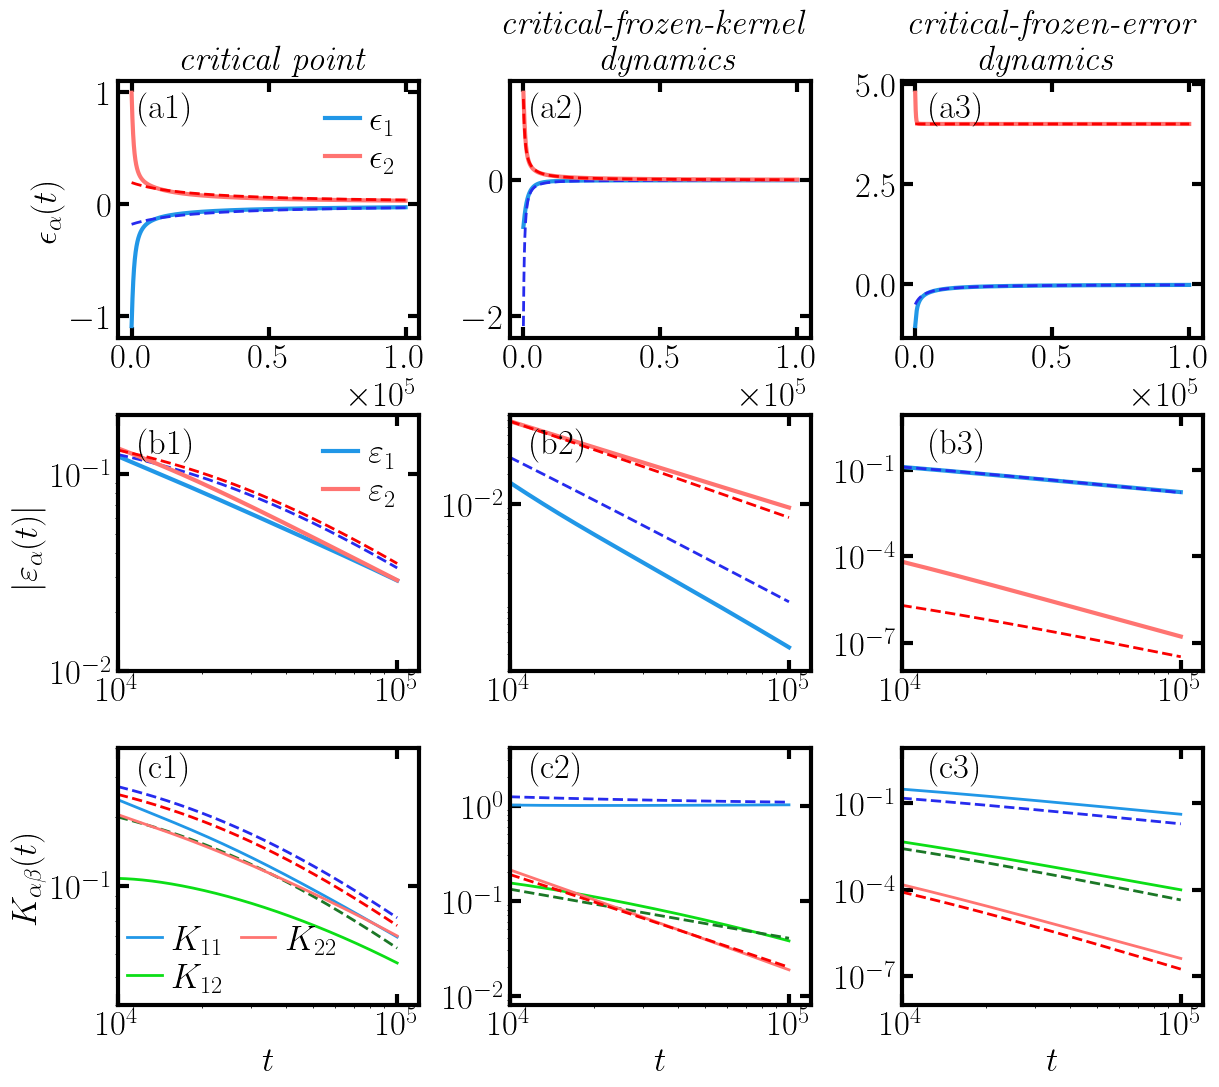

In [48]:
# asymptotic theory
steps = int(1e5) + 1
ts = np.arange(steps)
ndata = 2
tlate = int(1e4) + 1

# critical point
idx = 2
eps_hist_c = np.load('data/training/n4/orth_data/ndata2/L48/RPASlepshist_n4L48_1_-1.npy')[:, idx]
K_hist_c = np.load('data/training/n4/orth_data/ndata2/L48/RPASlKhist_n4L48_1_-1.npy')[:, idx]
muend_c = np.load('data/training/n4/orth_data/ndata2/L48/RPASlmuhist_n4L48_1_-1.npy')[-1, idx]
g_hist_c = np.sqrt(K_hist_c[:, range(ndata), range(ndata)])

ldaend_c = ldaUT(K_hist_c[-1], muend_c)
Aend_c = ldaend_c[range(ndata), range(ndata)]
Bend_c = KoffdiagRatio(K_hist_c[-1])
cs_E_c = [-2.05186, 2.1608]
cs_G_c = [2.10723, 2.0254]
c0_c = np.mean(np.array(cs_E_c)/eps_hist_c[tlate] - 0.001*tlate/ndata)
eps_pred_c = np.stack([cs_E_c[k]/(c0_c + 0.001*ts/ndata) for k in range(2)]).T
g_pred_c = np.stack([cs_G_c[k]/np.sqrt(c0_c + 0.001*ts/ndata) for k in range(2)]).T

# critical-frozen-kernel phase
idx = 5
eps_hist_c_fro_k = np.load('data/training/n4/orth_data/ndata2/L48/RPASlepshist_n4L48_0.4_-1.0.npy')[:, idx]
K_hist_c_fro_k = np.load('data/training/n4/orth_data/ndata2/L48/RPASlKhist_n4L48_0.4_-1.0.npy')[:, idx]
muend_c_fro_k = np.load('data/training/n4/orth_data/ndata2/L48/RPASlmuhist_n4L48_0.4_-1.0.npy')[-1, idx]
g_hist_c_fro_k = np.sqrt(K_hist_c_fro_k[:, range(ndata), range(ndata)])

ldaend_c_fro_k = ldaUT(K_hist_c_fro_k[-1], muend_c_fro_k)
Aend_c_fro_k = ldaend_c_fro_k[range(ndata), range(ndata)]
Bend_c_fro_k = KoffdiagRatio(K_hist_c_fro_k[-1])

eps_pred_c_fro_k = np.zeros((steps, ndata))
g_pred_c_fro_k = np.zeros((steps, ndata))
# prediction on data at boundary
c1E_c_fro_k, c1G_c_fro_k = 0.365506, 1
c0_c_fro_k = c1E_c_fro_k/eps_hist_c_fro_k[tlate, 1] - 0.001*tlate/ndata
eps_pred_c_fro_k[:, 1] = c1E_c_fro_k/(0.001*ts/ndata + c0_c_fro_k)
g_pred_c_fro_k[:, 1] = c1G_c_fro_k/np.sqrt(0.001*ts/ndata + c0_c_fro_k)
# prediction on data inside
a1E_c_fro_k = - Bend_c_fro_k[0, 1]*c1E_c_fro_k*c1G_c_fro_k/(Bend_c_fro_k[0, 1]*g_hist_c_fro_k[-1, 0])
eps_pred_c_fro_k[:, 0] = a1E_c_fro_k/(0.001*ts/ndata + c0_c_fro_k)**1.5
a1G_c_fro_k  = 2*(Aend_c_fro_k[0, 0]*g_hist_c_fro_k[-1, 0]*a1E_c_fro_k
    + Aend_c_fro_k[0, 1]*c1E_c_fro_k*c1G_c_fro_k)
g_pred_c_fro_k[:, 0] = a1G_c_fro_k/np.sqrt(c0_c_fro_k + 0.001 * ts/ndata) + g_hist_c_fro_k[-1, 0]

# critical-frozen-error phase
idx = 1
eps_hist_c_fro_err = np.load('data/training/n4/orth_data/ndata2/L48/RPASlepshist_n4L48_1_-5.npy')[:, idx]
K_hist_c_fro_err = np.load('data/training/n4/orth_data/ndata2/L48/RPASlKhist_n4L48_1_-5.npy')[:, idx]
muend_c_fro_err = np.load('data/training/n4/orth_data/ndata2/L48/RPASlmuhist_n4L48_1_-5.npy')[-1, idx]
g_hist_c_fro_err = np.sqrt(K_hist_c_fro_err[:, range(ndata), range(ndata)])

Rs_c_fro_err = np.array([0, 4])
ldaend_c_fro_err = ldaUT(K_hist_c_fro_err[-1], muend_c_fro_err)
Aend_c_fro_err = ldaend_c_fro_err[range(2), range(2)]
Bend_c_fro_err = KoffdiagRatio(K_hist_c_fro_err[-1])

eps_pred_c_fro_err = np.zeros((steps, 2))
g_pred_c_fro_err = np.zeros((steps, 2))
# prediction on data at boundary
c1E_c_fro_err, c1G_c_fro_err = -0.821545, 1
c0_c_fro_err = c1E_c_fro_err/eps_hist_c_fro_err[tlate, 0] - 0.001*tlate/ndata
eps_pred_c_fro_err[:, 0] = c1E_c_fro_err/(0.001*ts/ndata + c0_c_fro_err)
g_pred_c_fro_err[:, 0] = c1G_c_fro_err/np.sqrt(0.001*ts/ndata + c0_c_fro_err)
# prediction on data outside
a1G_c_fro_err = - Aend_c_fro_err[1, 0]*c1E_c_fro_err*c1G_c_fro_err\
    /(Aend_c_fro_err[1, 1]*Rs_c_fro_err[1])
g_pred_c_fro_err[:, 1] = a1G_c_fro_err/(0.001*ts/ndata + c0_c_fro_err)**1.5
a1E_c_fro_err = (Bend_c_fro_err[1, 0]*a1G_c_fro_err*c1E_c_fro_err*c1G_c_fro_err
     + Bend_c_fro_err[1, 1]*Rs_c_fro_err[1]*a1G_c_fro_err**2)/2
eps_pred_c_fro_err[:, 1] = a1E_c_fro_err/(c0_c_fro_err + 0.001*ts/ndata)**2 + Rs_c_fro_err[1]


fig, axs = plt.subplots(3, 3, figsize=(14, 12))
cl = ['#2197E7', '#FF7471']
cl2 = ['#262BEE', '#FA0000']
clk = ['#2197E7', '#0CDE16', '#FF7471']
clk2 = ['#262BEE', '#1B7726', '#FA0000']

for i in range(2):
    # critical point
    axs[0, 0].plot(eps_hist_c[:, i], lw=3, c=cl[i], label=fr'$\epsilon_{{{i+1}}}$')
    axs[0, 0].plot(eps_pred_c[:, i], '--', lw=2, c=cl2[i])
    axs[1, 0].plot(np.abs(eps_hist_c[:, i]), lw=3, c=cl[i], label=fr'$\varepsilon_{{{i+1}}}$')
    axs[1, 0].plot(np.abs(eps_pred_c[:, i]), '--', lw=2, c=cl2[i])
    # critical-frozen-kernel phase
    axs[0, 1].plot(eps_hist_c_fro_k[:, i], lw=3, c=cl[i])
    axs[0, 1].plot(eps_pred_c_fro_k[:, i], '--', lw=2, c=cl2[i])
    axs[1, 1].plot(np.abs(eps_hist_c_fro_k[:, i]), lw=3, c=cl[i])
    axs[1, 1].plot(np.abs(eps_pred_c_fro_k[:, i]), '--', lw=2, c=cl2[i])
    # critical-frozen-error phase
    axs[0, 2].plot(eps_hist_c_fro_err[:, i], lw=3, c=cl[i])
    axs[0, 2].plot(eps_pred_c_fro_err[:, i], '--', lw=2, c=cl2[i])
    axs[1, 2].plot(np.abs(eps_hist_c_fro_err[:, i] - Rs_c_fro_err[i]), lw=3, c=cl[i])
    axs[1, 2].plot(np.abs(eps_pred_c_fro_err[:, i] - Rs_c_fro_err[i]), '--', lw=2, c=cl2[i])


for cc, (i, j) in enumerate(combinations_with_replacement(range(2), 2)):
    # critical point
    axs[2, 0].plot(K_hist_c[:, i, j], lw=2, c=clk[cc], label=fr'$K_{{{i+1} {j+1}}}$')
    axs[2, 0].plot(Bend_c[i,j]*g_pred_c[:, i]*g_pred_c[:, j], '--', lw=2, c=clk2[cc])
    # critical-frozen-kernel phase
    axs[2, 1].plot(K_hist_c_fro_k[:, i, j], lw=2, c=clk[cc])
    axs[2, 1].plot(Bend_c_fro_k[i,j]*g_pred_c_fro_k[:, i]*g_pred_c_fro_k[:, j], '--', 
        lw=2, c=clk2[cc])
    # critical-frozen-error phase
    axs[2, 2].plot(K_hist_c_fro_err[:, i, j], lw=2, c=clk[cc])
    axs[2, 2].plot(Bend_c_fro_err[i,j]*g_pred_c_fro_err[:, i]*g_pred_c_fro_err[:, j], '--', 
        lw=2, c=clk2[cc])

for i in range(3):
    axs[2, i].set_xlabel(r'$t$')
    axs[1, i].set_yscale('log')
    axs[2, i].set_yscale('log')

for i in range(2):
    axs[1+i, 0].set_ylim(10**-2.1, 4)
    axs[1+i, 2].set_ylim(10**-8, 8)
    axs[1+i, 2].set_yticks([1e-7, 1e-4, 0.1])
axs[1, 1].set_ylim(10**-4.2, 4)
axs[1, 1].set_yticks([1e-4, 1e-2, 1])
axs[2, 1].set_ylim(10**-2.1, 4)
axs[2, 1].set_yticks([1e-2, 0.1, 1])

axs[0, 0].set_ylabel(r'$\epsilon_\alpha(t)$')    
axs[1, 0].set_ylabel(r'$|\varepsilon_\alpha(t)|$')
axs[2, 0].set_ylabel(r'$K_{\alpha \beta}(t)$')

for i in range(3):
    axs[0, i].ticklabel_format(axis='x', style='sci', scilimits=(0,0))
for i in range(9):
    axs[i//3, i%3].tick_params(direction='in', length=8, width=3, top='on', right='on')

for i in range(2):
    axs[i, 0].legend(handletextpad=0.3, labelspacing=0.2, borderpad=0.2, handlelength=1, framealpha=0,
        loc='upper right')
axs[2, 0].legend(handletextpad=0.3, labelspacing=0.2, borderpad=0.2, handlelength=1, framealpha=0,
    loc='lower left', ncol=2, columnspacing=0.5, bbox_to_anchor=(-0.05, -0.05))

xpos = [0.14, 0.42, 0.705]
ypos = [0.85, 0.57, 0.3]
for i in range(9):
    fig.text(x=xpos[i%3], y=ypos[i//3], s=fr'$\rm ({chr(97+i//3)} {i%3 + 1})$')
fig.text(0.17, 0.89, '\it critical point')
fig.text(0.4, 0.92, '\it critical-frozen-kernel')
fig.text(0.47, 0.89, '\it dynamics')
fig.text(0.69, 0.92, '\it critical-frozen-error')
fig.text(0.74, 0.89, '\it dynamics')

for i in range(3):
    axs[1, i].set_xscale('log')
    axs[2, i].set_xscale('log')
    axs[0, i].set_xticks(np.arange(3)*5e4)
    axs[1, i].set_xlim(1e4, 1.2e5)
    axs[2, i].set_xlim(1e4, 1.2e5)

axs[1, 0].set_ylim(1e-2, 2e-1)
axs[1, 1].set_ylim(2e-4, 8e-2)
axs[2, 0].set_ylim(3e-2, 4e-1)
#axs[1, 0].set_yticks([0.03, 0.1])
#axs[1, 0].set_yticklabels([r'$3\times 10^{-2}$', r'$10^{-1}$'])

plt.subplots_adjust(wspace=0.3, hspace=0.3)
plt.savefig('figures/poly_class_N2_loglog.pdf', bbox_inches='tight')
plt.show()
plt.close()

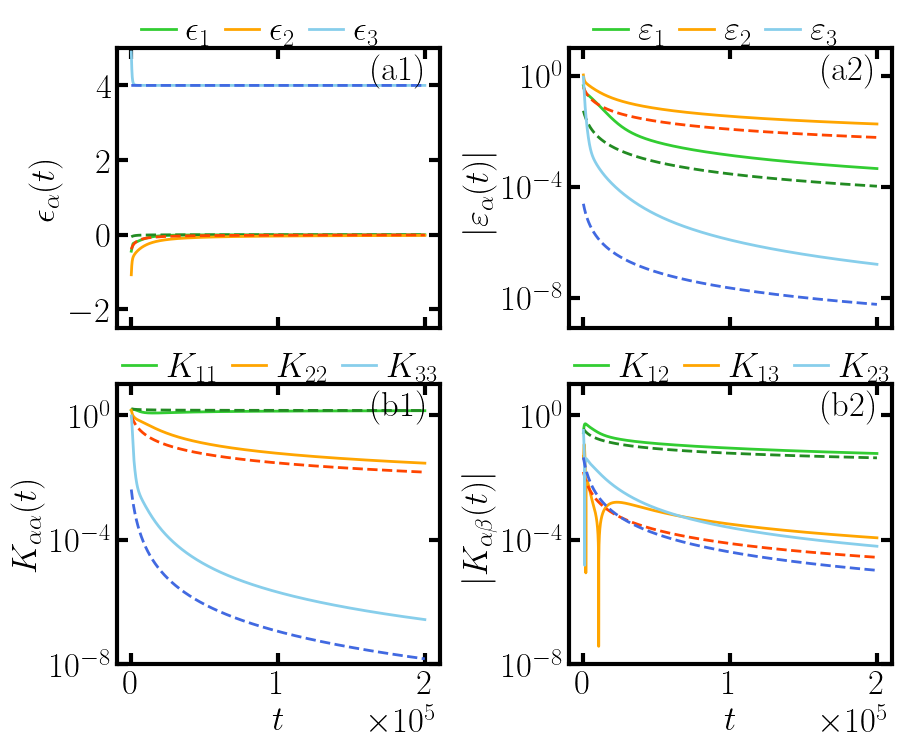

In [ ]:
steps = int(2e5)+1
ts = np.arange(steps)
ndata = 3
tlate = int(1e4) + 1

idx = 7
eps_hist_c_mix_fro = np.load('data/training/n4/orth_data/ndata3/L48/RPASlepshist_n4L48_0.4_1.0_-5.0.npy')[:, idx]
K_hist_c_mix_fro = np.load('data/training/n4/orth_data/ndata3/L48/RPASlKhist_n4L48_0.4_1.0_-5.0.npy')[:, idx]
muend_c_mix_fro = np.load('data/training/n4/orth_data/ndata3/L48/RPASlmuhist_n4L48_0.4_1.0_-5.0.npy')[-1, idx]
g_hist_c_mix_fro = np.sqrt(K_hist_c_mix_fro[:, range(ndata), range(ndata)])

Rs_c_mix_fro = np.array([0, 0, 4])
ldaend_c_mix_fro = ldaUT(K_hist_c_mix_fro[-1], muend_c_mix_fro)
Aend_c_mix_fro = ldaend_c_mix_fro[range(ndata), range(ndata)]
Bend_c_mix_fro = KoffdiagRatio(K_hist_c_mix_fro[-1])

eps_pred_c_mix_fro = np.zeros((steps, 3))
g_pred_c_mix_fro = np.zeros((steps, 3))
# prediction on epsilon (crit) and g (crit)
c1E_c_mix_fro, c1G_c_mix_fro = -0.405126, 1
c0_c_mix_fro = c1E_c_mix_fro/eps_hist_c_mix_fro[tlate, 0] - 0.001*tlate/ndata
eps_pred_c_mix_fro[:, 1] = c1E_c_mix_fro/(0.001*ts/ndata + c0_c_mix_fro)
g_pred_c_mix_fro[:, 1] = c1G_c_mix_fro/np.sqrt(0.001*ts/ndata + c0_c_mix_fro)
# prediction on epsilont (inside) and g (outside)
a1E_c_mix_fro, a3G_c_mix_fro = -0.0580515, 0.067643
eps_pred_c_mix_fro[:, 0] = a1E_c_mix_fro/(c0_c_mix_fro + 0.001*ts/ndata)**1.5
g_pred_c_mix_fro[:, 2] = a3G_c_mix_fro/(c0_c_mix_fro + 0.001*ts/ndata)**1.5
# # prediction on epsilon (outside) and g (inside)
factor_in = Bend_c_mix_fro[2, 0]*g_hist_c_mix_fro[-1, 0]*a1E_c_mix_fro
factor_crit = Bend_c_mix_fro[2, 1]*c1E_c_mix_fro*c1G_c_mix_fro
factor_out = Bend_c_mix_fro[2, 2]*Rs_c_mix_fro[2]*a3G_c_mix_fro
a3E_c_mix_fro = a3G_c_mix_fro*(factor_in + factor_crit + factor_out)/2
eps_pred_c_mix_fro[:, 2] = a3E_c_mix_fro/(c0_c_mix_fro + 0.001*ts/ndata)**2 + Rs_c_mix_fro[2]

factor_in = Aend_c_mix_fro[0, 1]*g_hist_c_mix_fro[-1, 0]*a1E_c_mix_fro
factor_crit = Bend_c_mix_fro[0, 1]*c1E_c_mix_fro*c1G_c_mix_fro
factor_out = Bend_c_mix_fro[0, 2]*Rs_c_mix_fro[2]*a3G_c_mix_fro
a1G_c_mix_fro = 2*(factor_in + factor_crit + factor_out)
g_pred_c_mix_fro[:, 0] = a1G_c_mix_fro/np.sqrt(c0_c_mix_fro + 0.001*ts/ndata) + g_hist_c_mix_fro[-1, 0]


fig, axs = plt.subplots(2, 2, figsize=(10, 8), sharex=True)
cl = ['limegreen', 'orange', 'skyblue']
cl2 = ['forestgreen', 'orangered', 'royalblue']
for i in range(ndata):
    axs[0, 0].plot(eps_hist_c_mix_fro[:, i], lw=2, c=cl[i], label=fr'$\epsilon_{{{i+1}}}$')
    axs[0, 0].plot(eps_pred_c_mix_fro[:, i], '--', lw=2, c=cl2[i])
axs[0, 0].legend(handletextpad=0.3, labelspacing=0.2, borderpad=0.2, handlelength=1, framealpha=0,
    loc='upper left', bbox_to_anchor=(0., 1.2), ncol=3, columnspacing=0.4)
axs[0, 0].set_xticks(np.arange(3)*5e4)
axs[0, 0].set_ylim(-2.5, 5)
axs[0, 0].set_yticks([-2, 1, 4])
axs[0, 0].set_ylabel(r'$\epsilon_\alpha (t)$')

for i in range(ndata):
    axs[0, 1].plot(np.abs(eps_hist_c_mix_fro[:, i] - Rs_c_mix_fro[i]), lw=2, c=cl[i], 
        label=fr'$\varepsilon_{{{i+1}}}$')
    axs[0, 1].plot(np.abs(eps_pred_c_mix_fro[:, i] - Rs_c_mix_fro[i]), '--', lw=2, c=cl2[i])
axs[0, 1].legend(handletextpad=0.3, labelspacing=0.2, borderpad=0.2, handlelength=1, framealpha=0,
    loc='upper left', bbox_to_anchor=(0., 1.2), ncol=3, columnspacing=0.4)
axs[0, 1].set_yscale('log')
axs[0, 1].set_ylim(10**-9.1, 10)
axs[0, 1].set_yticks([1e-8, 1e-4, 1])
axs[0, 1].set_ylabel(r'$|\varepsilon_\alpha (t)|$')

for i in range(ndata):
    axs[1, 0].plot(K_hist_c_mix_fro[:, i, i], lw=2, c=cl[i], label=fr'$K_{{{i+1} {i+1}}}$')
    axs[1, 0].plot(g_pred_c_mix_fro[:, i]**2, '--', lw=2, c=cl2[i])
axs[1, 0].legend(handletextpad=0.3, labelspacing=0.2, borderpad=0.2, handlelength=1, framealpha=0,
    loc='upper left', bbox_to_anchor=(-0.06, 1.2), ncol=3, columnspacing=0.4)
axs[1, 0].set_ylabel(r'$K_{\alpha \alpha}(t)$')
axs[1, 0].set_yscale('log')
axs[1, 0].set_xticks(np.arange(3)*5e4)
axs[1, 0].set_ylim(1e-8, 10)
axs[1, 0].set_yticks([1e-8, 1e-4, 1])

for cc, (i, j) in enumerate(combinations(range(ndata), 2)):
    axs[1, 1].plot(np.abs(K_hist_c_mix_fro[:, i, j]), lw=2, c=cl[cc], label=fr'$K_{{{i+1} {j+1}}}$')
    axs[1, 1].plot(np.abs(Bend_c_mix_fro[i, j]*g_pred_c_mix_fro[:, i]*g_pred_c_mix_fro[:, j]), 
        '--', lw=2, c=cl2[cc])
axs[1, 1].legend(handletextpad=0.3, labelspacing=0.2, borderpad=0.2, handlelength=1, framealpha=0,
    loc='upper left', bbox_to_anchor=(-0.06, 1.2), ncol=3, columnspacing=0.4)
axs[1, 1].set_ylabel(r'$|K_{\alpha \beta}(t)|$')
axs[1, 1].set_yscale('log')
axs[1, 1].set_xticks(np.arange(3)*5e4)
axs[1, 1].set_ylim(1e-8, 10)
axs[1, 1].set_yticks([1e-8, 1e-4, 1])

axs[0, 0].set_xticks(np.arange(3)*1e5)
axs[0, 0].set_yticks([-2, 0, 2, 4])
axs[0, 0].ticklabel_format(axis='x', style='sci', scilimits=(0,0))
for i in range(4):
    axs[i//2, i%2].tick_params(direction='in', length=8, width=3, top='on', right='on')

for i in range(2):
    axs[1, i].set_xlabel(r'$t$')

xpos = [0.38, 0.83]
ypos = [0.84, 0.42]
for i in range(4):
    fig.text(x=xpos[i%2], y=ypos[i//2], s=fr'$\rm ({chr(97+i//2)} {i%2 + 1})$')

plt.subplots_adjust(wspace=0.4, hspace=0.2)
#plt.savefig('figures/crit_mix_fro_N3.svg', bbox_inches='tight')
plt.show()
plt.close()

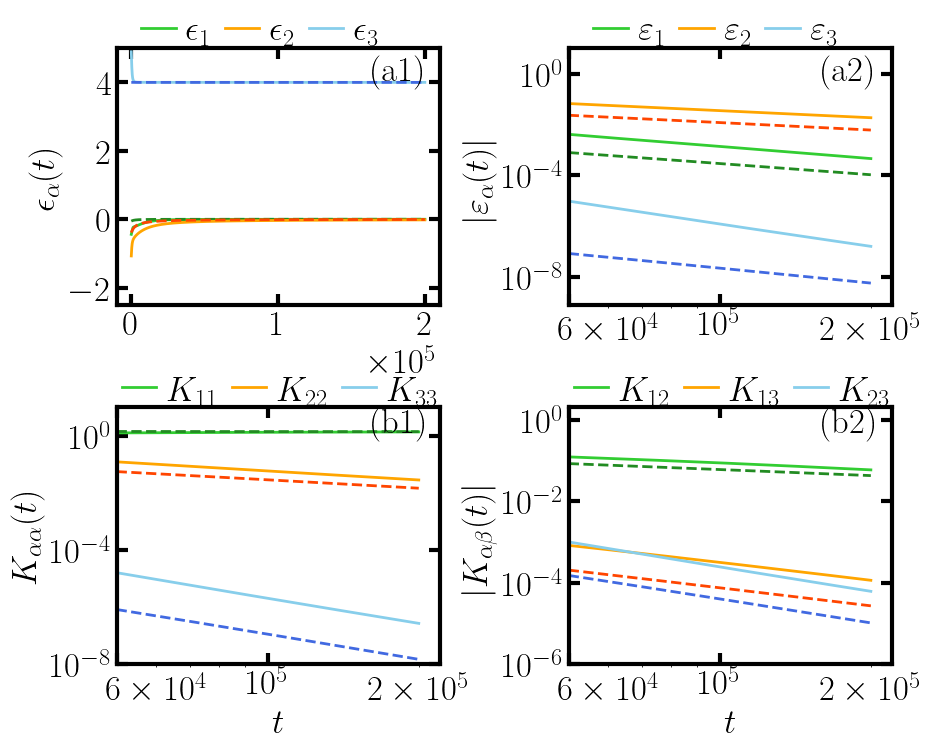

In [60]:
steps = int(2e5)+1
ts = np.arange(steps)
ndata = 3
tlate = int(1e4) + 1

idx = 7
eps_hist_c_mix_fro = np.load('data/training/n4/orth_data/ndata3/L48/RPASlepshist_n4L48_0.4_1.0_-5.0.npy')[:, idx]
K_hist_c_mix_fro = np.load('data/training/n4/orth_data/ndata3/L48/RPASlKhist_n4L48_0.4_1.0_-5.0.npy')[:, idx]
muend_c_mix_fro = np.load('data/training/n4/orth_data/ndata3/L48/RPASlmuhist_n4L48_0.4_1.0_-5.0.npy')[-1, idx]
g_hist_c_mix_fro = np.sqrt(K_hist_c_mix_fro[:, range(ndata), range(ndata)])

Rs_c_mix_fro = np.array([0, 0, 4])
ldaend_c_mix_fro = ldaUT(K_hist_c_mix_fro[-1], muend_c_mix_fro)
Aend_c_mix_fro = ldaend_c_mix_fro[range(ndata), range(ndata)]
Bend_c_mix_fro = KoffdiagRatio(K_hist_c_mix_fro[-1])

eps_pred_c_mix_fro = np.zeros((steps, 3))
g_pred_c_mix_fro = np.zeros((steps, 3))
# prediction on epsilon (crit) and g (crit)
c1E_c_mix_fro, c1G_c_mix_fro = -0.405126, 1
c0_c_mix_fro = c1E_c_mix_fro/eps_hist_c_mix_fro[tlate, 0] - 0.001*tlate/ndata
eps_pred_c_mix_fro[:, 1] = c1E_c_mix_fro/(0.001*ts/ndata + c0_c_mix_fro)
g_pred_c_mix_fro[:, 1] = c1G_c_mix_fro/np.sqrt(0.001*ts/ndata + c0_c_mix_fro)
# prediction on epsilont (inside) and g (outside)
a1E_c_mix_fro, a3G_c_mix_fro = -0.0580515, 0.067643
eps_pred_c_mix_fro[:, 0] = a1E_c_mix_fro/(c0_c_mix_fro + 0.001*ts/ndata)**1.5
g_pred_c_mix_fro[:, 2] = a3G_c_mix_fro/(c0_c_mix_fro + 0.001*ts/ndata)**1.5
# # prediction on epsilon (outside) and g (inside)
factor_in = Bend_c_mix_fro[2, 0]*g_hist_c_mix_fro[-1, 0]*a1E_c_mix_fro
factor_crit = Bend_c_mix_fro[2, 1]*c1E_c_mix_fro*c1G_c_mix_fro
factor_out = Bend_c_mix_fro[2, 2]*Rs_c_mix_fro[2]*a3G_c_mix_fro
a3E_c_mix_fro = a3G_c_mix_fro*(factor_in + factor_crit + factor_out)/2
eps_pred_c_mix_fro[:, 2] = a3E_c_mix_fro/(c0_c_mix_fro + 0.001*ts/ndata)**2 + Rs_c_mix_fro[2]

factor_in = Aend_c_mix_fro[0, 1]*g_hist_c_mix_fro[-1, 0]*a1E_c_mix_fro
factor_crit = Bend_c_mix_fro[0, 1]*c1E_c_mix_fro*c1G_c_mix_fro
factor_out = Bend_c_mix_fro[0, 2]*Rs_c_mix_fro[2]*a3G_c_mix_fro
a1G_c_mix_fro = 2*(factor_in + factor_crit + factor_out)
g_pred_c_mix_fro[:, 0] = a1G_c_mix_fro/np.sqrt(c0_c_mix_fro + 0.001*ts/ndata) + g_hist_c_mix_fro[-1, 0]


fig, axs = plt.subplots(2, 2, figsize=(10, 8))
cl = ['limegreen', 'orange', 'skyblue']
cl2 = ['forestgreen', 'orangered', 'royalblue']
for i in range(ndata):
    axs[0, 0].plot(eps_hist_c_mix_fro[:, i], lw=2, c=cl[i], label=fr'$\epsilon_{{{i+1}}}$')
    axs[0, 0].plot(eps_pred_c_mix_fro[:, i], '--', lw=2, c=cl2[i])
axs[0, 0].legend(handletextpad=0.3, labelspacing=0.2, borderpad=0.2, handlelength=1, framealpha=0,
    loc='upper left', bbox_to_anchor=(0., 1.22), ncol=3, columnspacing=0.4)
axs[0, 0].set_xticks(np.arange(3)*5e4)
axs[0, 0].set_ylim(-2.5, 5)
axs[0, 0].set_yticks([-2, 1, 4])
axs[0, 0].set_ylabel(r'$\epsilon_\alpha (t)$')

for i in range(ndata):
    axs[0, 1].plot(np.abs(eps_hist_c_mix_fro[:, i] - Rs_c_mix_fro[i]), lw=2, c=cl[i], 
        label=fr'$\varepsilon_{{{i+1}}}$')
    axs[0, 1].plot(np.abs(eps_pred_c_mix_fro[:, i] - Rs_c_mix_fro[i]), '--', lw=2, c=cl2[i])
axs[0, 1].legend(handletextpad=0.3, labelspacing=0.2, borderpad=0.2, handlelength=1, framealpha=0,
    loc='upper left', bbox_to_anchor=(0., 1.22), ncol=3, columnspacing=0.4)
axs[0, 1].set_yscale('log')
axs[0, 1].set_ylim(10**-9.1, 10)
axs[0, 1].set_yticks([1e-8, 1e-4, 1])
axs[0, 1].set_ylabel(r'$|\varepsilon_\alpha (t)|$')

for i in range(ndata):
    axs[1, 0].plot(K_hist_c_mix_fro[:, i, i], lw=2, c=cl[i], label=fr'$K_{{{i+1} {i+1}}}$')
    axs[1, 0].plot(g_pred_c_mix_fro[:, i]**2, '--', lw=2, c=cl2[i])
axs[1, 0].legend(handletextpad=0.3, labelspacing=0.2, borderpad=0.2, handlelength=1, framealpha=0,
    loc='upper left', bbox_to_anchor=(-0.06, 1.22), ncol=3, columnspacing=0.4)
axs[1, 0].set_ylabel(r'$K_{\alpha \alpha}(t)$')
axs[1, 0].set_yscale('log')
axs[1, 0].set_xticks(np.arange(3)*5e4)
axs[1, 0].set_ylim(1e-8, 10)
axs[1, 0].set_yticks([1e-8, 1e-4, 1])

for cc, (i, j) in enumerate(combinations(range(ndata), 2)):
    axs[1, 1].plot(np.abs(K_hist_c_mix_fro[:, i, j]), lw=2, c=cl[cc], label=fr'$K_{{{i+1} {j+1}}}$')
    axs[1, 1].plot(np.abs(Bend_c_mix_fro[i, j]*g_pred_c_mix_fro[:, i]*g_pred_c_mix_fro[:, j]), 
        '--', lw=2, c=cl2[cc])
axs[1, 1].legend(handletextpad=0.3, labelspacing=0.2, borderpad=0.2, handlelength=1, framealpha=0,
    loc='upper left', bbox_to_anchor=(-0.06, 1.22), ncol=3, columnspacing=0.4)
axs[1, 1].set_ylabel(r'$|K_{\alpha \beta}(t)|$')
axs[1, 1].set_yscale('log')
axs[1, 1].set_xticks(np.arange(3)*5e4)
axs[1, 1].set_ylim(1e-6, 2)

axs[0, 0].set_xticks(np.arange(3)*1e5)
axs[0, 0].set_yticks([-2, 0, 2, 4])
axs[0, 0].ticklabel_format(axis='x', style='sci', scilimits=(0,0))
for i in range(4):
    axs[i//2, i%2].tick_params(direction='in', length=8, width=3, top='on', right='on')

for i in range(2):
    axs[1, i].set_xlabel(r'$t$')

xpos = [0.38, 0.83]
ypos = [0.84, 0.4]
for i in range(4):
    fig.text(x=xpos[i%2], y=ypos[i//2], s=fr'$\rm ({chr(97+i//2)} {i%2 + 1})$')

for i in range(1, 4):
    axs[i//2, i%2].set_xscale('log')
    axs[i//2, i%2].set_xscale('log')
    axs[i//2, i%2].set_xticks(np.arange(3)*5e4)
    axs[i//2, i%2].set_xlim(5e4, 2.2e5)
    axs[i//2, i%2].set_xlim(5e4, 2.2e5)


plt.subplots_adjust(wspace=0.4, hspace=0.4)
plt.savefig('figures/crit_mix_fro_N3_loglog.pdf', bbox_inches='tight')
plt.show()
plt.close()

## relative dQNTK dynamics in short

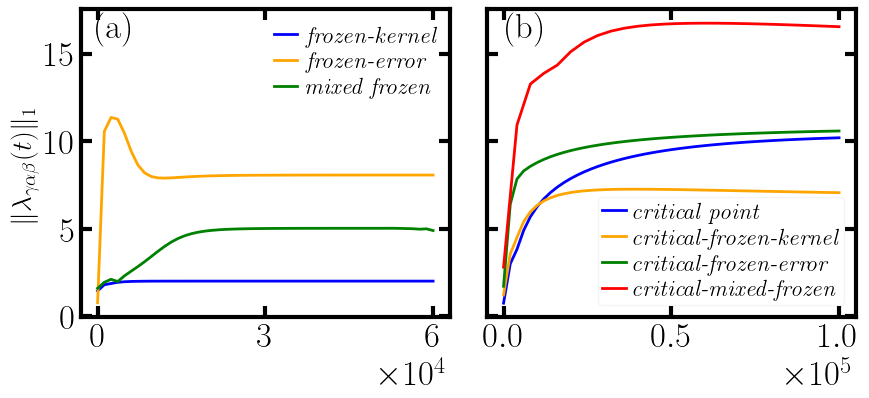

In [46]:
steps_list = [int(6e4)+1, int(1e5)+1, int(2e5)+1]
idx_exp = [12, 15, 11]
ys_exp = [(0.3, -0.5), (5, -6), (0.4, -5.0)]
lda_hist_exp = np.zeros((3, 51, 2, 2, 2))

path = 'data/training/n4/orth_data/ndata2/L48/'
for k in range(3):
    y1, y2 = ys_exp[k]
    idx = idx_exp[k]
    steps = steps_list[0]
    K_hist = np.load(os.path.join(path, f'RPASlKhist_n4L48_{y1}_{y2}.npy'))[::steps//50, idx]
    mu_hist = np.load(os.path.join(path, f'RPASlmuhist_n4L48_{y1}_{y2}.npy'))[:, idx]
    for i in range(51):
        lda_hist_exp[k, i] = ldaUT(K_hist[i], mu_hist[i])

idx_poly = [2, 6, 1, 7]
ys_poly = [(1, -1), (0.4, -1.0), (1, -5), (0.4, 1, -5)]
lda_hist_poly = np.zeros((3, 51, 2, 2, 2))

path = 'data/training/n4/orth_data/ndata2/L48/'
for k in range(3):
    y1, y2 = ys_poly[k]
    idx = idx_poly[k]
    steps = steps_list[1]
    K_hist = np.load(os.path.join(path, f'RPASlKhist_n4L48_{y1}_{y2}.npy'))[::steps//50, idx]
    mu_hist = np.load(os.path.join(path, f'RPASlmuhist_n4L48_{y1}_{y2}.npy'))[:, idx]
    for i in range(51):
        lda_hist_poly[k, i] = ldaUT(K_hist[i], mu_hist[i])

lda_hist_poly2 = np.zeros((51, 3, 3, 3))
path = 'data/training/n4/orth_data/ndata3/L48/'
K_hist = np.load(os.path.join(path, f'RPASlKhist_n4L48_0.4_1.0_-5.0.npy'))[::steps_list[2]//50, 7]
mu_hist = np.load(os.path.join(path, f'RPASlmuhist_n4L48_0.4_1.0_-5.0.npy'))[:, 7]
for i in range(51):
    lda_hist_poly2[i] = ldaUT(K_hist[i], mu_hist[i])

fig, axs = plt.subplots(1, 2, figsize=(10, 4), sharey=True)
cl = ['b', 'orange', 'g', 'r']
for k in range(3):
    axs[0].plot(np.arange(0, 60001, 60001//50), np.sum(np.abs(lda_hist_exp[k]), axis=(1, 2, 3)),
        c=cl[k], lw=2)
    axs[1].plot(np.arange(0, 100001, 100001//50), np.sum(np.abs(lda_hist_poly[k]), axis=(1, 2, 3)),
        c=cl[k], lw=2)
axs[1].plot(np.arange(0, 200001, 200001//50)[:26], np.sum(np.abs(lda_hist_poly2[:26]), axis=(1, 2, 3)),
    c=cl[-1], lw=2)
axs[0].legend(['\it frozen-kernel', '\it frozen-error', '\it mixed frozen'],
    handletextpad=0.3, labelspacing=0.2, borderpad=0.2, handlelength=1, framealpha=0, fontsize=17)
axs[1].legend(['\it critical point', '\it critical-frozen-kernel', '\it critical-frozen-error',
    '\it critical-mixed-frozen'], handletextpad=0.3, labelspacing=0.2, borderpad=0.2, handlelength=1, 
    framealpha=0.2, fontsize=17, loc='lower right')
axs[0].set_ylabel(r'$\|\lambda_{\gamma \alpha \beta}(t)\|_1$',
    fontsize=20)

axs[0].set_xticks(np.arange(3)*3e4)
axs[1].set_xticks(np.arange(3)*5e4)
for i in range(2):
    axs[i].ticklabel_format(axis='x', style='sci', scilimits=(0,0))
    axs[i].tick_params(direction='in', length=8, width=3, top='on', right='on')

fig.text(0.14, 0.81, r'$\rm (a)$')
fig.text(0.55, 0.81, r'$\rm (b)$')

plt.subplots_adjust(wspace=0.1)
plt.savefig('figures/lda.pdf', bbox_inches='tight')
plt.show()
plt.close()

## relative dQNTK

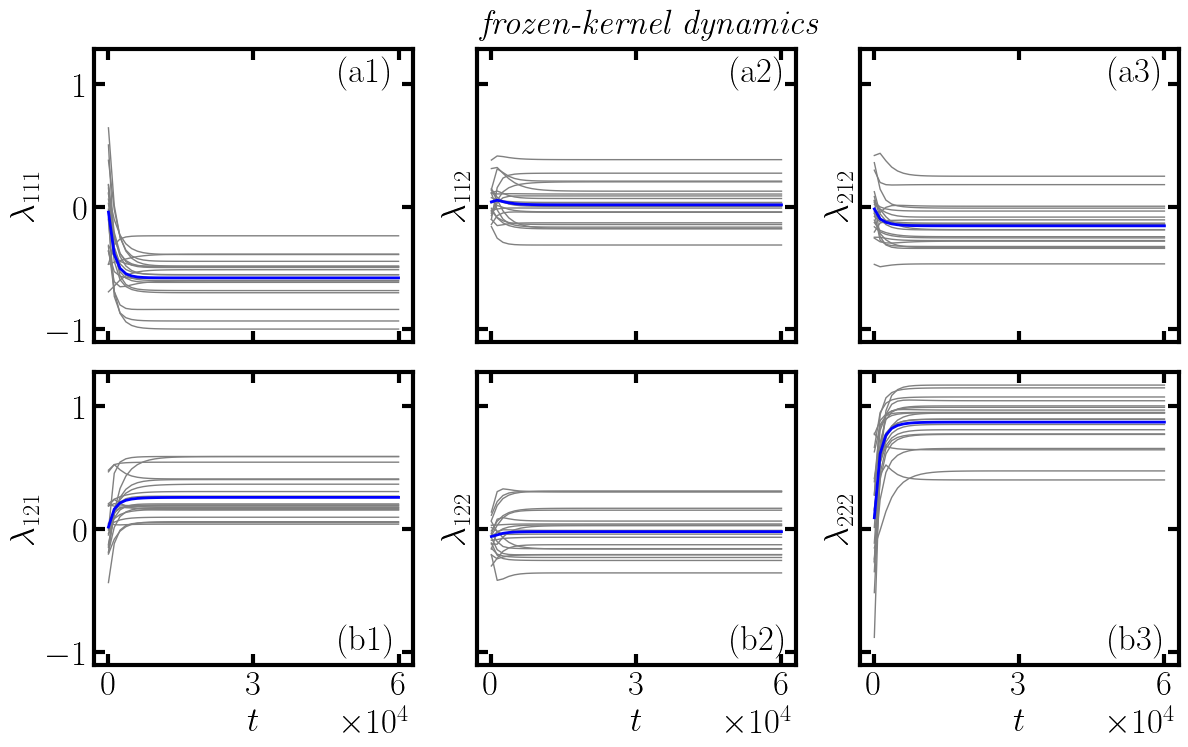

In [295]:
# lambda: frozen-kernel phase
steps = 60001
ts = np.arange(0, steps, steps//50)

K_hist = np.load('data/training/n4/orth_data/ndata2/L48/RPASlKhist_n4L48_0.3_-0.5.npy')[::steps//50]
mu_hist = np.load('data/training/n4/orth_data/ndata2/L48/RPASlmuhist_n4L48_0.3_-0.5.npy')

lda_hist = np.zeros((51, 20, 2, 2, 2))
for i in range(51):
    for k in range(20):
        lda_hist[i, k] = ldaUT(K_hist[i, k], mu_hist[i, k])

fig, axs = plt.subplots(2, 3, figsize=(14, 8), sharex=True, sharey=True)
for cc, (i, j) in enumerate(combinations_with_replacement(range(2), 2)):
    axs[0, cc].plot(ts, lda_hist[:, :, i, 0, j], lw=1, c='grey')
    axs[0, cc].plot(ts, np.mean(lda_hist[:, :, i, 0, j], axis=1), lw=2, c='b')
    axs[1, cc].plot(ts, lda_hist[:, :, i, 1, j], lw=1, c='grey')
    axs[1, cc].plot(ts, np.mean(lda_hist[:, :, i, 1, j], axis=1), lw=2, c='b')
    axs[0, cc].set_ylabel(fr'$\lambda_{{{i+1} 1 {j+1}}}$')
    axs[1, cc].set_ylabel(fr'$\lambda_{{{i+1} 2 {j+1}}}$')
for i in range(3):
    axs[1, i].set_xlabel(r'$t$')
axs[0, 0].set_xticks(np.arange(3)*3e4)
axs[0, 0].set_yticks([-1, 0, 1])
axs[0, 0].ticklabel_format(axis='x', style='sci', scilimits=(0,0))
for i in range(6):
    axs[i//3, i%3].tick_params(direction='in', length=8, width=3, top='on', right='on')

xpos = [0.3, 0.58, 0.85]
ypos = [0.84, 0.13]
for i in range(6):
    fig.text(x=xpos[i%3], y=ypos[i//3], s=fr'$\rm ({chr(97+i//3)} {i%3 + 1})$')
fig.text(0.4, 0.9, '\it frozen-kernel dynamics')

plt.subplots_adjust(hspace=0.1)
plt.savefig('figures/lda_fro_k.pdf', bbox_inches='tight')
plt.show()
plt.close()

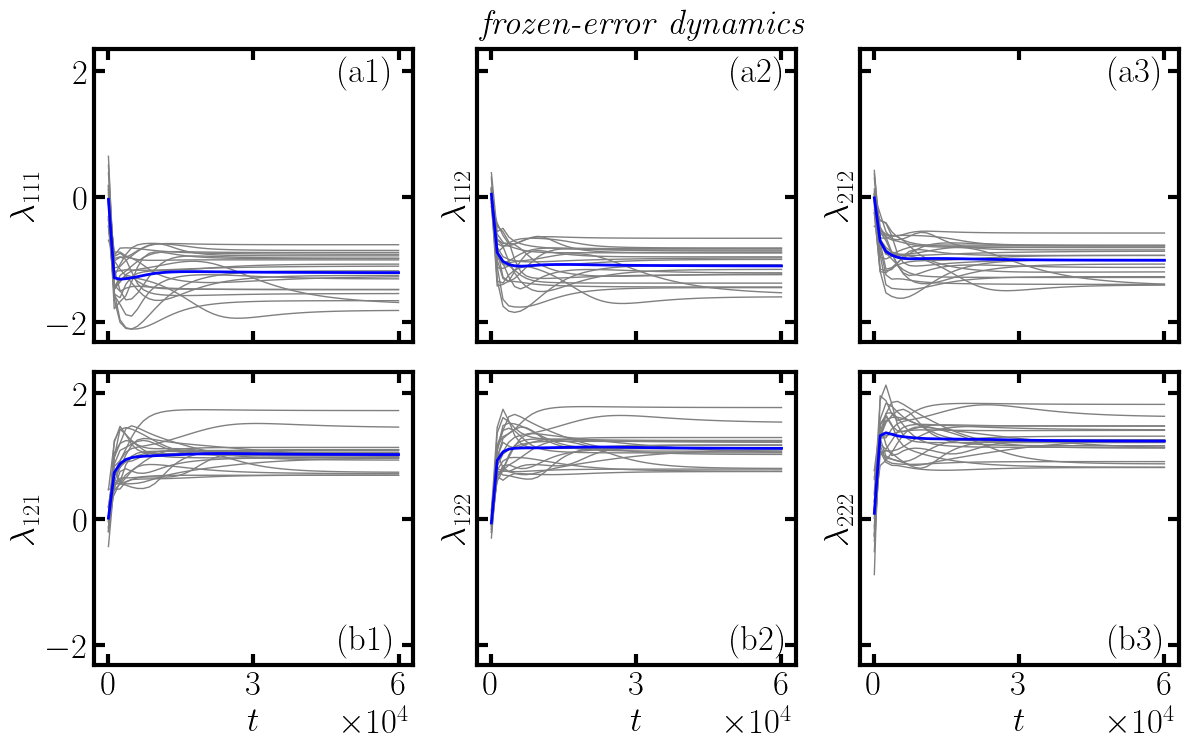

In [296]:
# lambda: frozen-error phase
steps = 60001
ts = np.arange(0, steps, steps//50)

K_hist = np.load('data/training/n4/orth_data/ndata2/L48/RPASlKhist_n4L48_5_-6.npy')[::steps//50]
mu_hist = np.load('data/training/n4/orth_data/ndata2/L48/RPASlmuhist_n4L48_5_-6.npy')

lda_hist = np.zeros((51, 20, 2, 2, 2))
for i in range(51):
    for k in range(20):
        lda_hist[i, k] = ldaUT(K_hist[i, k], mu_hist[i, k])

fig, axs = plt.subplots(2, 3, figsize=(14, 8), sharex=True, sharey=True)
for cc, (i, j) in enumerate(combinations_with_replacement(range(2), 2)):
    axs[0, cc].plot(ts, lda_hist[:, :, i, 0, j], lw=1, c='grey')
    axs[0, cc].plot(ts, np.mean(lda_hist[:, :, i, 0, j], axis=1), lw=2, c='b')
    axs[1, cc].plot(ts, lda_hist[:, :, i, 1, j], lw=1, c='grey')
    axs[1, cc].plot(ts, np.mean(lda_hist[:, :, i, 1, j], axis=1), lw=2, c='b')
    axs[0, cc].set_ylabel(fr'$\lambda_{{{i+1} 1 {j+1}}}$')
    axs[1, cc].set_ylabel(fr'$\lambda_{{{i+1} 2 {j+1}}}$')
for i in range(3):
    axs[1, i].set_xlabel(r'$t$')
axs[0, 0].set_xticks(np.arange(3)*3e4)
axs[0, 0].set_yticks([-2, 0, 2])
axs[0, 0].ticklabel_format(axis='x', style='sci', scilimits=(0,0))
for i in range(6):
    axs[i//3, i%3].tick_params(direction='in', length=8, width=3, top='on', right='on')

xpos = [0.3, 0.58, 0.85]
ypos = [0.84, 0.13]
for i in range(6):
    fig.text(x=xpos[i%3], y=ypos[i//3], s=fr'$\rm ({chr(97+i//3)} {i%3 + 1})$')
fig.text(0.4, 0.9, '\it frozen-error dynamics')

plt.subplots_adjust(hspace=0.1)
plt.savefig('figures/lda_fro_e.pdf', bbox_inches='tight')
plt.show()
plt.close()

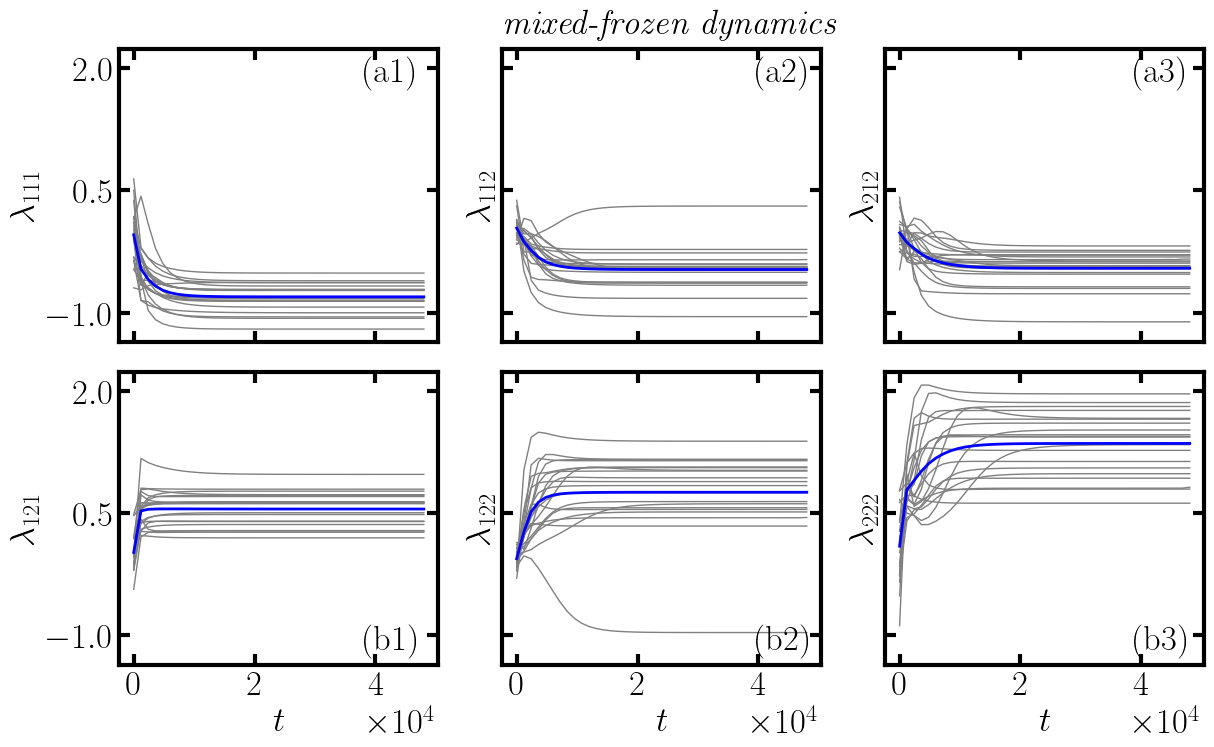

In [297]:
# lambda: mixed-frozen phase
steps = 60001
ts = np.arange(0, steps, steps//50)

K_hist = np.load('data/training/n4/orth_data/ndata2/L48/RPASlKhist_n4L48_0.4_-5.0.npy')[::steps//50]
mu_hist = np.load('data/training/n4/orth_data/ndata2/L48/RPASlmuhist_n4L48_0.4_-5.0.npy')

lda_hist = np.zeros((51, 20, 2, 2, 2))
for i in range(51):
    for k in range(20):
        lda_hist[i, k] = ldaUT(K_hist[i, k], mu_hist[i, k])

fig, axs = plt.subplots(2, 3, figsize=(14, 8), sharex=True, sharey=True)
for cc, (i, j) in enumerate(combinations_with_replacement(range(2), 2)):
    axs[0, cc].plot(ts[:41], lda_hist[:41, :, i, 0, j], lw=1, c='grey')
    axs[0, cc].plot(ts[:41], np.mean(lda_hist[:41, :, i, 0, j], axis=1), lw=2, c='b')
    axs[1, cc].plot(ts[:41], lda_hist[:41, :, i, 1, j], lw=1, c='grey')
    axs[1, cc].plot(ts[:41], np.mean(lda_hist[:41, :, i, 1, j], axis=1), lw=2, c='b')
    axs[0, cc].set_ylabel(fr'$\lambda_{{{i+1} 1 {j+1}}}$')
    axs[1, cc].set_ylabel(fr'$\lambda_{{{i+1} 2 {j+1}}}$')
for i in range(3):
    axs[1, i].set_xlabel(r'$t$')
#axs[0, 0].set_xticks(np.arange(3)*3e4)
axs[0, 0].set_yticks([-1, 0.5, 2])
axs[0, 0].ticklabel_format(axis='x', style='sci', scilimits=(0,0))
for i in range(6):
    axs[i//3, i%3].tick_params(direction='in', length=8, width=3, top='on', right='on')

xpos = [0.3, 0.58, 0.85]
ypos = [0.84, 0.13]
for i in range(6):
    fig.text(x=xpos[i%3], y=ypos[i//3], s=fr'$\rm ({chr(97+i//3)} {i%3 + 1})$')
fig.text(0.4, 0.9, '\it mixed-frozen dynamics')

plt.subplots_adjust(hspace=0.1)
plt.savefig('figures/lda_mix_fro.pdf', bbox_inches='tight')
plt.show()
plt.close()

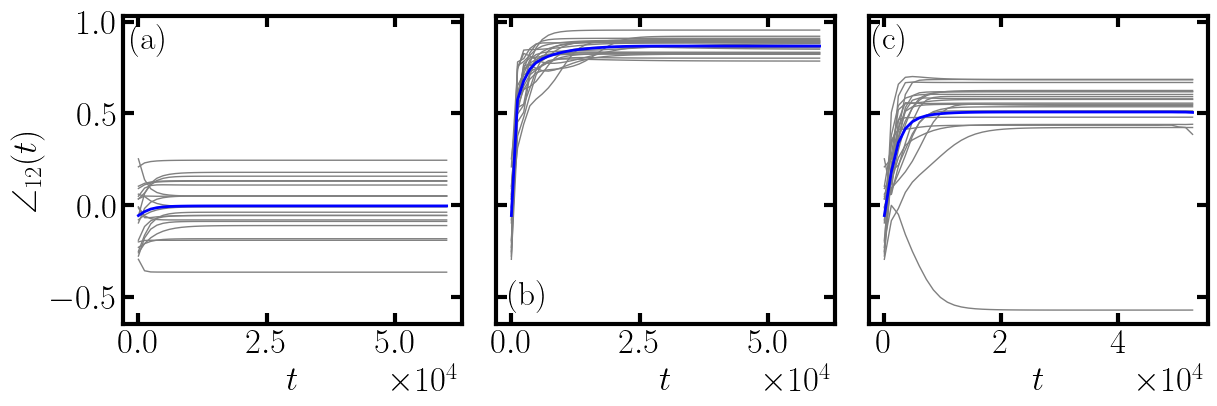

In [298]:
steps = int(6e4) + 1
ts = np.arange(0, steps, steps//50)

ys_exp = [(0.3, -0.5), (5, -6), (0.4, -5.0)]
B_hist = np.zeros((3, 51, 20))

path = 'data/training/n4/orth_data/ndata2/L48/'
for k in range(3):
    y1, y2 = ys_exp[k]
    K_hist = np.load(os.path.join(path, f'RPASlKhist_n4L48_{y1}_{y2}.npy'))[::steps//50]
    B_hist[k] = K_hist[:, :, 0, 1]/np.sqrt(K_hist[:, :, 0, 0]*K_hist[:, :, 1, 1])

fig, axs = plt.subplots(1, 3, figsize=(14, 4), sharey=True)
for k in range(2):
    axs[k].plot(ts, B_hist[k], c='grey', lw=1)
    axs[k].plot(ts, np.mean(B_hist[k], axis=1), c='b', lw=2)
axs[2].plot(ts[:45], B_hist[2, :45], c='grey', lw=1)
axs[2].plot(ts[:45], np.mean(B_hist[2, :45], axis=1), c='b', lw=2)

axs[0].set_ylabel(r'$\angle_{12}(t)$')
for i in range(3):
    axs[i].set_xlabel(r'$t$')
    axs[i].tick_params(direction='in', length=8, width=3, top='on', right='on')
    axs[i].ticklabel_format(axis='x', style='sci', scilimits=(0,0))

fig.text(0.13, 0.8, r'$\rm (a)$', fontsize=24)
fig.text(0.4, 0.16, r'$\rm (b)$', fontsize=24)
fig.text(0.66, 0.8, r'$\rm (c)$', fontsize=24)

plt.subplots_adjust(wspace=0.1)
plt.savefig('figures/B_exp.pdf', bbox_inches='tight')
plt.show()
plt.close()

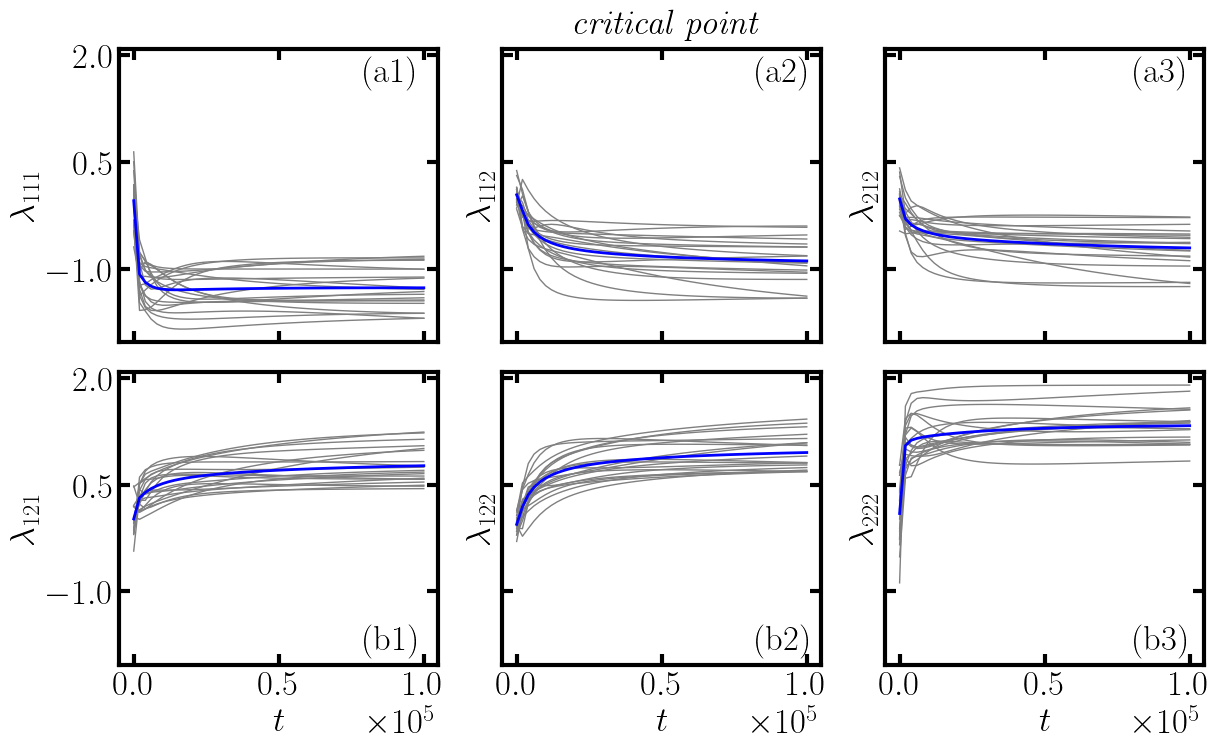

In [299]:
# lambda: critical point
steps = int(1e5) + 1
ts = np.arange(0, steps, steps//50)

K_hist = np.load('data/training/n4/orth_data/ndata2/L48/RPASlKhist_n4L48_1_-1.npy')[::steps//50]
mu_hist = np.load('data/training/n4/orth_data/ndata2/L48/RPASlmuhist_n4L48_1_-1.npy')

lda_hist = np.zeros((51, 20, 2, 2, 2))
for i in range(51):
    for k in range(20):
        lda_hist[i, k] = ldaUT(K_hist[i, k], mu_hist[i, k])

fig, axs = plt.subplots(2, 3, figsize=(14, 8), sharex=True, sharey=True)
for cc, (i, j) in enumerate(combinations_with_replacement(range(2), 2)):
    axs[0, cc].plot(ts, lda_hist[:, :, i, 0, j], lw=1, c='grey')
    axs[0, cc].plot(ts, np.mean(lda_hist[:, :, i, 0, j], axis=1), lw=2, c='b')
    axs[1, cc].plot(ts, lda_hist[:, :, i, 1, j], lw=1, c='grey')
    axs[1, cc].plot(ts, np.mean(lda_hist[:, :, i, 1, j], axis=1), lw=2, c='b')
    axs[0, cc].set_ylabel(fr'$\lambda_{{{i+1} 1 {j+1}}}$')
    axs[1, cc].set_ylabel(fr'$\lambda_{{{i+1} 2 {j+1}}}$')
for i in range(3):
    axs[1, i].set_xlabel(r'$t$')
axs[0, 0].set_xticks(np.arange(3)*5e4)
axs[0, 0].set_yticks([-1, 0.5, 2])
axs[0, 0].ticklabel_format(axis='x', style='sci', scilimits=(0,0))
for i in range(6):
    axs[i//3, i%3].tick_params(direction='in', length=8, width=3, top='on', right='on')

xpos = [0.3, 0.58, 0.85]
ypos = [0.84, 0.13]
for i in range(6):
    fig.text(x=xpos[i%3], y=ypos[i//3], s=fr'$\rm ({chr(97+i//3)} {i%3 + 1})$')
fig.text(0.45, 0.9, '\it critical point')

plt.subplots_adjust(hspace=0.1)
plt.savefig('figures/lda_c.pdf', bbox_inches='tight')
plt.show()
plt.close()

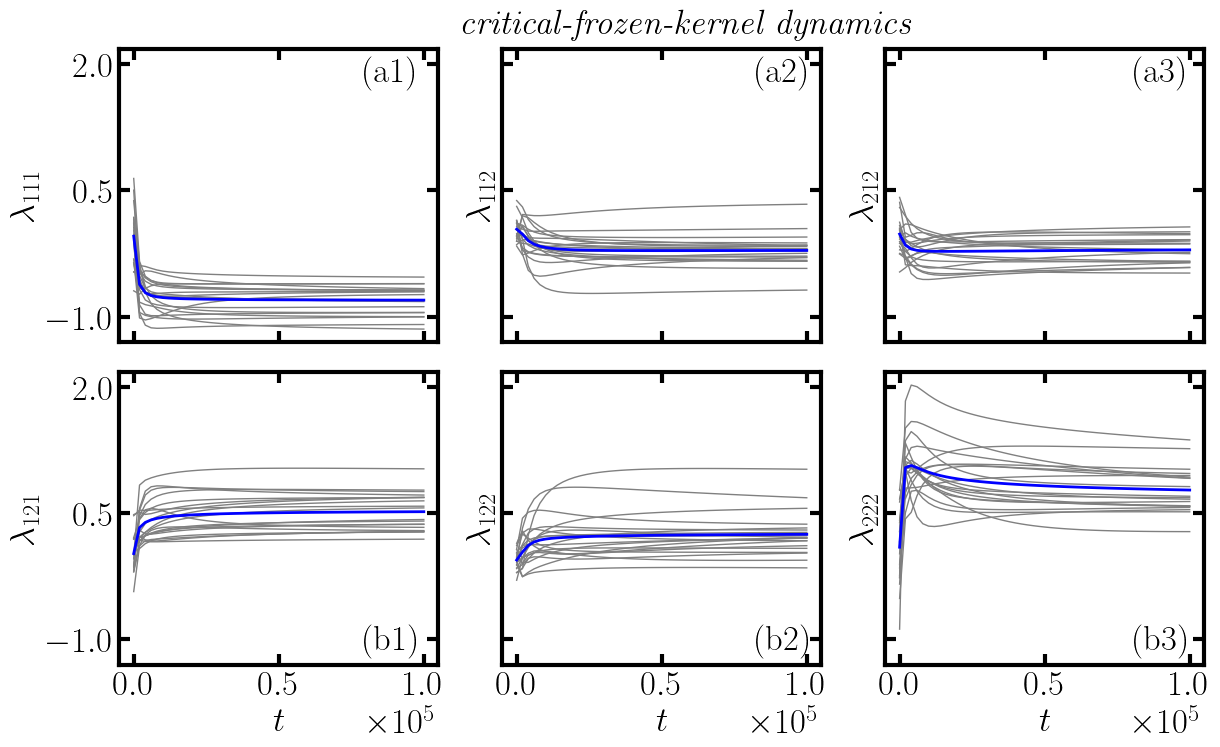

In [300]:
# lambda: critical-frozen-kernel
steps = int(1e5) + 1
ts = np.arange(0, steps, steps//50)

K_hist = np.load('data/training/n4/orth_data/ndata2/L48/RPASlKhist_n4L48_0.4_-1.0.npy')[::steps//50]
mu_hist = np.load('data/training/n4/orth_data/ndata2/L48/RPASlmuhist_n4L48_0.4_-1.0.npy')

lda_hist = np.zeros((51, 20, 2, 2, 2))
for i in range(51):
    for k in range(20):
        lda_hist[i, k] = ldaUT(K_hist[i, k], mu_hist[i, k])

fig, axs = plt.subplots(2, 3, figsize=(14, 8), sharex=True, sharey=True)
for cc, (i, j) in enumerate(combinations_with_replacement(range(2), 2)):
    axs[0, cc].plot(ts, lda_hist[:, :, i, 0, j], lw=1, c='grey')
    axs[0, cc].plot(ts, np.mean(lda_hist[:, :, i, 0, j], axis=1), lw=2, c='b')
    axs[1, cc].plot(ts, lda_hist[:, :, i, 1, j], lw=1, c='grey')
    axs[1, cc].plot(ts, np.mean(lda_hist[:, :, i, 1, j], axis=1), lw=2, c='b')
    axs[0, cc].set_ylabel(fr'$\lambda_{{{i+1} 1 {j+1}}}$')
    axs[1, cc].set_ylabel(fr'$\lambda_{{{i+1} 2 {j+1}}}$')
for i in range(3):
    axs[1, i].set_xlabel(r'$t$')
axs[0, 0].set_xticks(np.arange(3)*5e4)
axs[0, 0].set_yticks([-1, 0.5, 2])
axs[0, 0].ticklabel_format(axis='x', style='sci', scilimits=(0,0))
for i in range(6):
    axs[i//3, i%3].tick_params(direction='in', length=8, width=3, top='on', right='on')

xpos = [0.3, 0.58, 0.85]
ypos = [0.84, 0.13]
for i in range(6):
    fig.text(x=xpos[i%3], y=ypos[i//3], s=fr'$\rm ({chr(97+i//3)} {i%3 + 1})$')
fig.text(0.37, 0.9, '\it critical-frozen-kernel dynamics')

plt.subplots_adjust(hspace=0.1)
plt.savefig('figures/lda_c_fro_k.pdf', bbox_inches='tight')
plt.show()
plt.close()

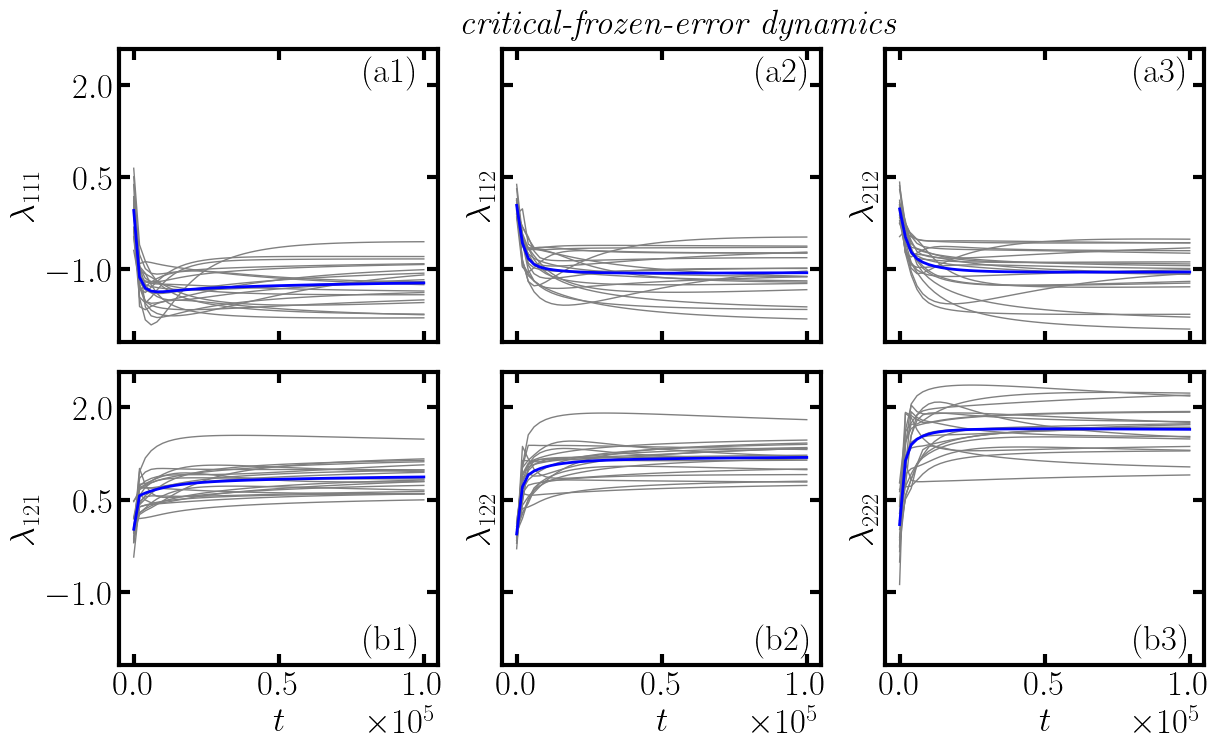

In [301]:
# lambda: critical-frozen-error
steps = int(1e5) + 1
ts = np.arange(0, steps, steps//50)

K_hist = np.load('data/training/n4/orth_data/ndata2/L48/RPASlKhist_n4L48_1_-5.npy')[::steps//50]
mu_hist = np.load('data/training/n4/orth_data/ndata2/L48/RPASlmuhist_n4L48_1_-5.npy')

lda_hist = np.zeros((51, 20, 2, 2, 2))
for i in range(51):
    for k in range(20):
        lda_hist[i, k] = ldaUT(K_hist[i, k], mu_hist[i, k])

fig, axs = plt.subplots(2, 3, figsize=(14, 8), sharex=True, sharey=True)
for cc, (i, j) in enumerate(combinations_with_replacement(range(2), 2)):
    axs[0, cc].plot(ts, lda_hist[:, :, i, 0, j], lw=1, c='grey')
    axs[0, cc].plot(ts, np.mean(lda_hist[:, :, i, 0, j], axis=1), lw=2, c='b')
    axs[1, cc].plot(ts, lda_hist[:, :, i, 1, j], lw=1, c='grey')
    axs[1, cc].plot(ts, np.mean(lda_hist[:, :, i, 1, j], axis=1), lw=2, c='b')
    axs[0, cc].set_ylabel(fr'$\lambda_{{{i+1} 1 {j+1}}}$')
    axs[1, cc].set_ylabel(fr'$\lambda_{{{i+1} 2 {j+1}}}$')
for i in range(3):
    axs[1, i].set_xlabel(r'$t$')
axs[0, 0].set_xticks(np.arange(3)*5e4)
axs[0, 0].set_yticks([-1, 0.5, 2])
axs[0, 0].ticklabel_format(axis='x', style='sci', scilimits=(0,0))
for i in range(6):
    axs[i//3, i%3].tick_params(direction='in', length=8, width=3, top='on', right='on')

xpos = [0.3, 0.58, 0.85]
ypos = [0.84, 0.13]
for i in range(6):
    fig.text(x=xpos[i%3], y=ypos[i//3], s=fr'$\rm ({chr(97+i//3)} {i%3 + 1})$')
fig.text(0.37, 0.9, '\it critical-frozen-error dynamics')

plt.subplots_adjust(hspace=0.1)
plt.savefig('figures/lda_c_fro_e.pdf', bbox_inches='tight')
plt.show()
plt.close()

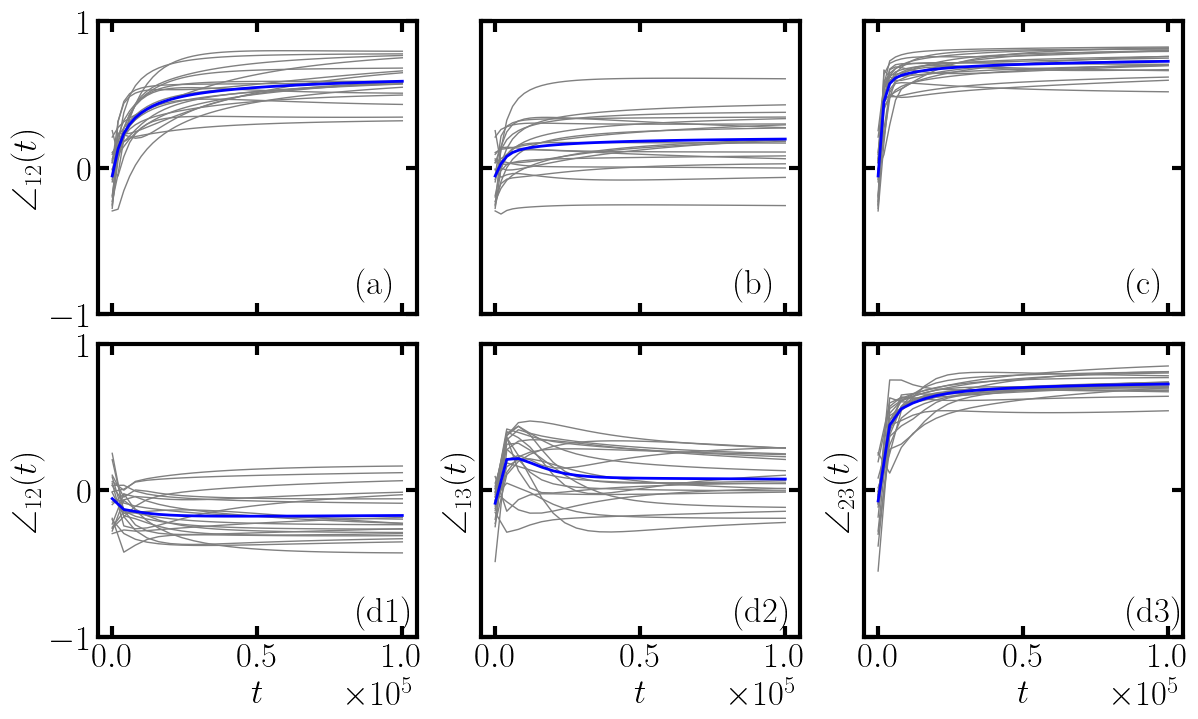

In [305]:
steps = int(1e5) + 1
ts = np.arange(0, steps, steps//50)

ys_poly = [(1, -1), (0.4, -1.0), (1, -5)]
B_hist = np.zeros((3, 51, 20))
path = 'data/training/n4/orth_data/ndata2/L48/'
for k in range(3):
    y1, y2 = ys_poly[k]
    K_hist = np.load(os.path.join(path, f'RPASlKhist_n4L48_{y1}_{y2}.npy'))[::steps//50]
    B_hist[k] = K_hist[:, :, 0, 1]/np.sqrt(K_hist[:, :, 0, 0]*K_hist[:, :, 1, 1])

steps2 = int(2e5) + 1
ts2 = np.arange(0, steps2, steps2//50)
K_hist = np.load('data/training/n4/orth_data/ndata3/L48/RPASlKhist_n4L48_0.4_1.0_-5.0.npy')[::steps2//50]
B_hist2 = np.zeros((51, 20, 3))
for cc, (i, j) in enumerate(combinations(range(3), 2)):
    B_hist2[:, :, cc] = K_hist[:, :, i, j]/np.sqrt(K_hist[:, :, i, i]*K_hist[:, :, j, j])

fig, axs = plt.subplots(2, 3, figsize=(14, 8), sharey=True, sharex=True)
for k in range(3):
    axs[0, k].plot(ts, B_hist[k], c='grey', lw=1)
    axs[0, k].plot(ts, np.mean(B_hist[k], axis=1), c='b', lw=2)
axs[0, 0].set_ylabel(r'$\angle_{12}(t)$')
axs[0, 0].set_ylim(-1, 1)
axs[0, 0].set_yticks([-1, 0, 1])
for cc, (i, j) in enumerate(combinations(range(3), 2)):
    axs[1, cc].plot(ts2[:26], B_hist2[:26, :, cc], c='grey', lw=1)
    axs[1, cc].plot(ts2[:26], np.mean(B_hist2[:26, :, cc], axis=1), c='b', lw=2)
    axs[1, cc].set_ylabel(fr'$\angle_{{{i+1} {j+1}}}(t)$')
for i in range(3):
    axs[1, i].set_xlabel(r'$t$')
for i in range(6):
    axs[i//3, i%3].tick_params(direction='in', length=8, width=3, top='on', right='on')
    axs[i//3, i%3].ticklabel_format(axis='x', style='sci', scilimits=(0,0))

xs = [0.31, 0.58, 0.86]
for i in range(3):
    fig.text(xs[i], 0.54, s=fr'$\rm ({chr(97+i)})$')
    fig.text(xs[i], 0.13, s=fr'$\rm (d {i+1})$')

plt.subplots_adjust(wspace=0.2, hspace=0.1)
plt.savefig('figures/B_poly.pdf', bbox_inches='tight')
plt.show()
plt.close()

## gauge invariance of geometric angle and relative dQTNK

In [87]:
def angleTransform(r, v, sint, cost):
    cos2t = 2*cost**2 - 1
    sin2t = 2*sint*cost
    numer = r*v*cos2t + (1-v**2) * sin2t/2
    denom1 = cost**2 + sint**2 * v**2 - sin2t*r*v
    denom2 = cost**2 * v**2 + sint**2 + sin2t*r*v
    return numer/np.sqrt(denom1*denom2)

def ldaTransform_reduce(lda, r, v, sint, cost):
    cos2t = 2*cost**2 - 1
    sin2t = 2*sint*cost
    K0t = cost**2 + sint**2 * v**2 - sin2t*r*v
    K1t = cost**2 * v**2 + sint**2 + sin2t*r*v
    ldat = np.zeros((2, 2))
    # 000
    mu00t = lda[0, 0, 0]*cost**3 - sint*cost**2 * (2*lda[0, 0, 1]*v+lda[0, 1, 0])\
        + v*sint**2 *cost * (2*lda[0, 1, 1] + lda[1, 0, 1]*v) - lda[1, 1, 1]*v**2*sint**3
    ldat[0, 0] = mu00t/K0t
    # 001
    mu01t = cost*sin2t*(lda[0, 0, 0] - lda[1, 0, 1]*v**2)/2 + cost*cos2t*lda[0, 0, 1]*v \
        - sint*sin2t*(lda[0, 1, 0] - lda[1, 1, 1]*v**2)/2 - sint*cos2t*lda[0, 1, 1]*v
    ldat[0, 1] = mu01t/np.sqrt(K0t * K1t)
    # 110
    mu10t = cost*sint**2 *(lda[0, 0, 0] - lda[1, 0, 1]*v**2) + cost*cos2t*lda[0, 1, 1]*v \
        + sint*cost**2 *(lda[0, 1, 0] - lda[1, 1, 1]*v**2) + sint*cos2t*lda[0, 0, 1]*v
    ldat[1, 0] = mu10t/np.sqrt(K0t * K1t)
    # 111
    mu11t = lda[0, 0, 0]*sint**3 + cost*sint**2 * (2*lda[0, 0, 1]*v+lda[0, 1, 0])\
        + v*sint*cost**2 * (2*lda[0, 1, 1] + lda[1, 0, 1]*v) + lda[1, 1, 1]*v**2*cost**3
    ldat[1, 1] = mu11t/K1t
    
    return ldat

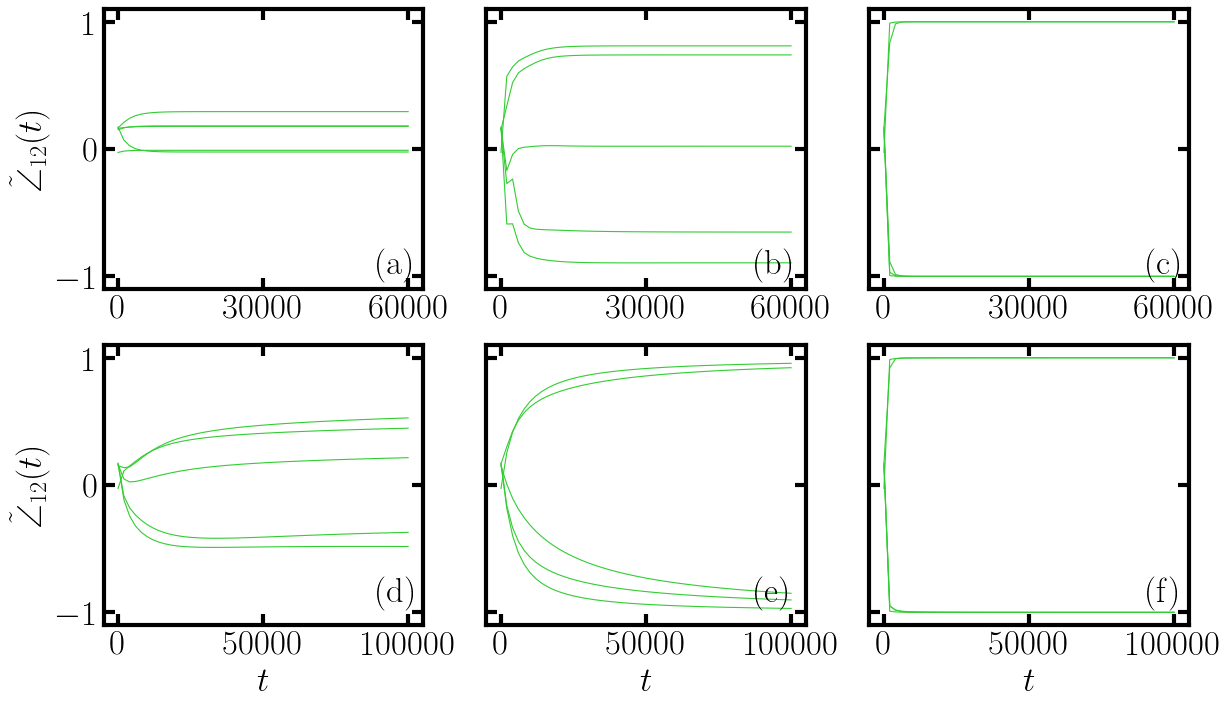

In [149]:
steps1 = int(6e4) + 1
steps2 = int(1e5) + 1
ts1 = np.arange(0, steps1, steps1//50)
ts2 = np.arange(0, steps2, steps2//50)

ys = [(0.3, -0.5), (5, -6), (0.4, -5.0), (1, -1), (0.4, -1.0), (1, -5)]
B_hist = np.zeros((6, 51, 5))

path = 'data/training/n4/orth_data/ndata2/L48/'
np.random.seed(25)
Os = special_ortho_group.rvs(dim=2, size=5)
xs = np.random.randint(0, 20, 5)
for k in range(6):
    y1, y2 = ys[k]
    if k < 3:
        K_hist = np.load(os.path.join(path, f'RPASlKhist_n4L48_{y1}_{y2}.npy'))[::steps1//50, xs]
    else:
        K_hist = np.load(os.path.join(path, f'RPASlKhist_n4L48_{y1}_{y2}.npy'))[::steps2//50, xs] 
    Ktrans = contract('bij, tbjk, blk->tbil', Os, K_hist, Os)
    B_hist[k] = Ktrans[:, :, 0, 1]/np.sqrt(Ktrans[:, :, 0, 0]*Ktrans[:, :, 1, 1])

fig, axs = plt.subplots(2, 3, figsize=(14, 8), sharey=True)
for k in range(3):
    axs[0, k].plot(ts1, B_hist[k], c='limegreen', lw=0.8)
    axs[1, k].plot(ts2, B_hist[3+k], c='limegreen', lw=0.8)

for k in range(3):
    axs[0, k].set_xticks(np.arange(3)*3e4)
    axs[1, k].set_xticks(np.arange(3)*5e4)
    axs[1, k].set_xlabel(r'$t$')
    axs[0, k].tick_params(direction='in', length=8, width=3, top='on', right='on')
    axs[1, k].tick_params(direction='in', length=8, width=3, top='on', right='on')

for i in range(2):
    axs[i, 0].set_ylabel(r'$\tilde{\angle}_{12}(t)$')

xs = [0.32, 0.59, 0.87]
ys = [0.55, 0.14]

for k in range(6):
    fig.text(xs[k%3], ys[k//3], fr'$\rm ({chr(97+k)})$')

plt.savefig('figures/B_gauge.pdf', bbox_inches='tight')
plt.show()
plt.close()

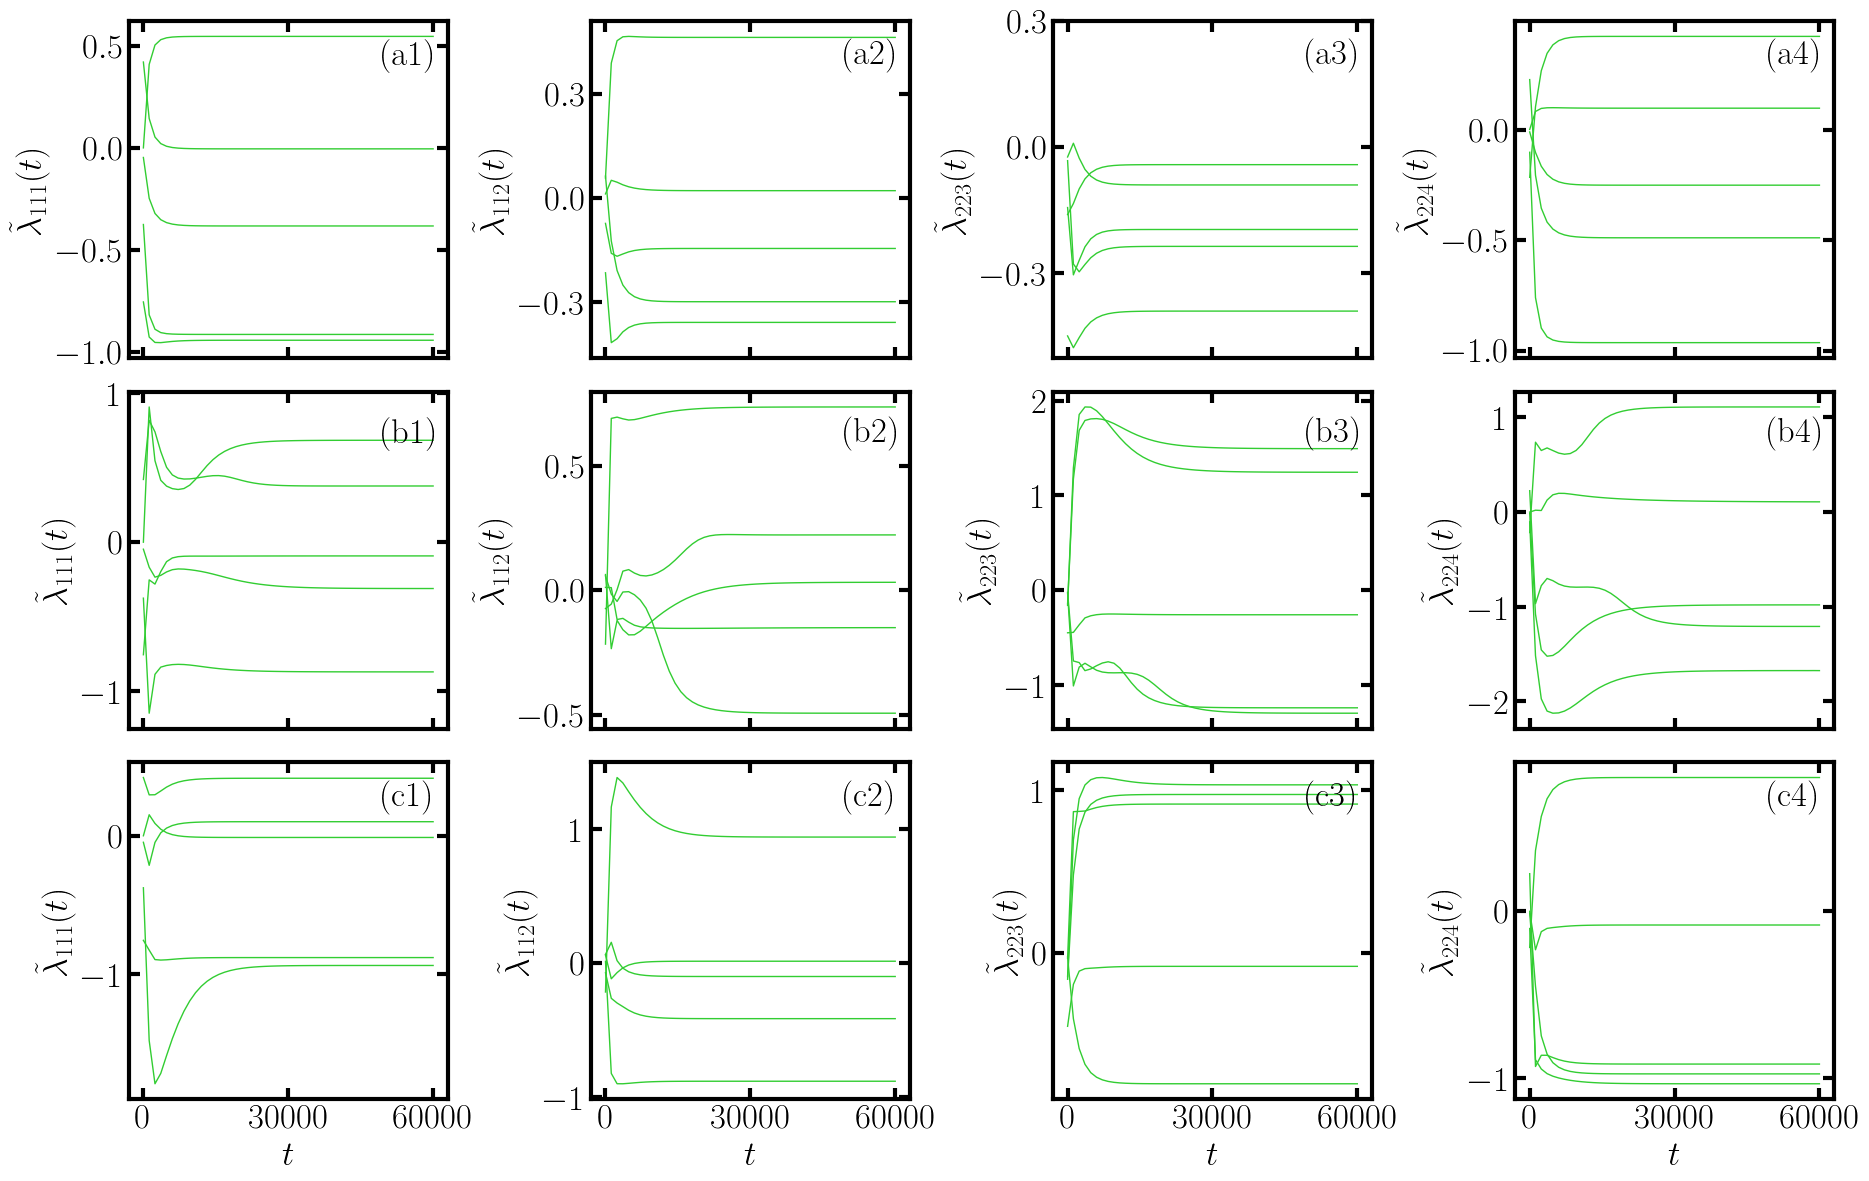

In [143]:
steps1 = int(6e4) + 1
ts1 = np.arange(0, steps1, steps1//50)

path = 'data/training/n4/orth_data/ndata2/L48/'

lda_hist = np.zeros((3, 51, 4, 5))

ys = [(0.3, -0.5), (5, -6), (0.4, -5.0)]
np.random.seed(18)
Os = special_ortho_group.rvs(dim=2, size=5)
xs = np.random.randint(0, 20, 5)
for k in range(3):
    y1, y2 = ys[k]
    mu_hist = np.load(os.path.join(path, f'RPASlmuhist_n4L48_{y1}_{y2}.npy'))[:, xs]
    K_hist = np.load(os.path.join(path, f'RPASlKhist_n4L48_{y1}_{y2}.npy'))[::steps1//50, xs]
    
    K_trans = contract('bij, tbjk, blk->tbil', Os, K_hist, Os)
    mu_trans = contract('bip, bjq, tbpqr, bkr->tbijk', Os, Os, mu_hist, Os)
    
    lda_hist[k, :, 0] = mu_trans[:, :, 0, 0, 0]/K_trans[:, :, 0, 0]
    lda_hist[k, :, 1] = mu_trans[:, :, 0, 0, 1]/np.sqrt(K_trans[:, :, 0, 0]*K_trans[:, :, 1, 1])
    lda_hist[k, :, 2] = mu_trans[:, :, 1, 1, 0]/np.sqrt(K_trans[:, :, 0, 0]*K_trans[:, :, 1, 1])
    lda_hist[k, :, 3] = mu_trans[:, :, 1, 1, 1]/K_trans[:, :, 1, 1]
    
fig, axs = plt.subplots(3, 4, figsize=(22, 14), sharex=True)
for k in range(3):
    for i in range(4):
        axs[k, i].plot(ts1, lda_hist[k, :, i], c='limegreen', lw=1)
        axs[k, i].set_ylabel(fr'$\tilde{{\lambda}}_{{{i//2+1}{i//2+1}{i+1}}}(t)$')
        axs[k, i].tick_params(direction='in', length=8, width=3, top='on', right='on')
for i in range(4):
    axs[-1, i].set_xlabel(r'$t$')
    axs[-1, i].set_xticks(np.arange(3)*3e4)
axs[0, 1].set_yticks([-0.3, 0, 0.3])
axs[0, 2].set_yticks([-0.3, 0, 0.3])

plt.subplots_adjust(wspace=0.45, hspace=0.1)

xs = [0.24, 0.45, 0.66, 0.87]
ys = [0.85, 0.58, 0.32]

for k in range(12):
    fig.text(xs[k%4], ys[k//4], fr'$\rm ({chr(97+k//4)}{k%4+1})$')

plt.savefig('figures/lda_gauge_exp.pdf', bbox_inches='tight')
plt.show()
plt.close()

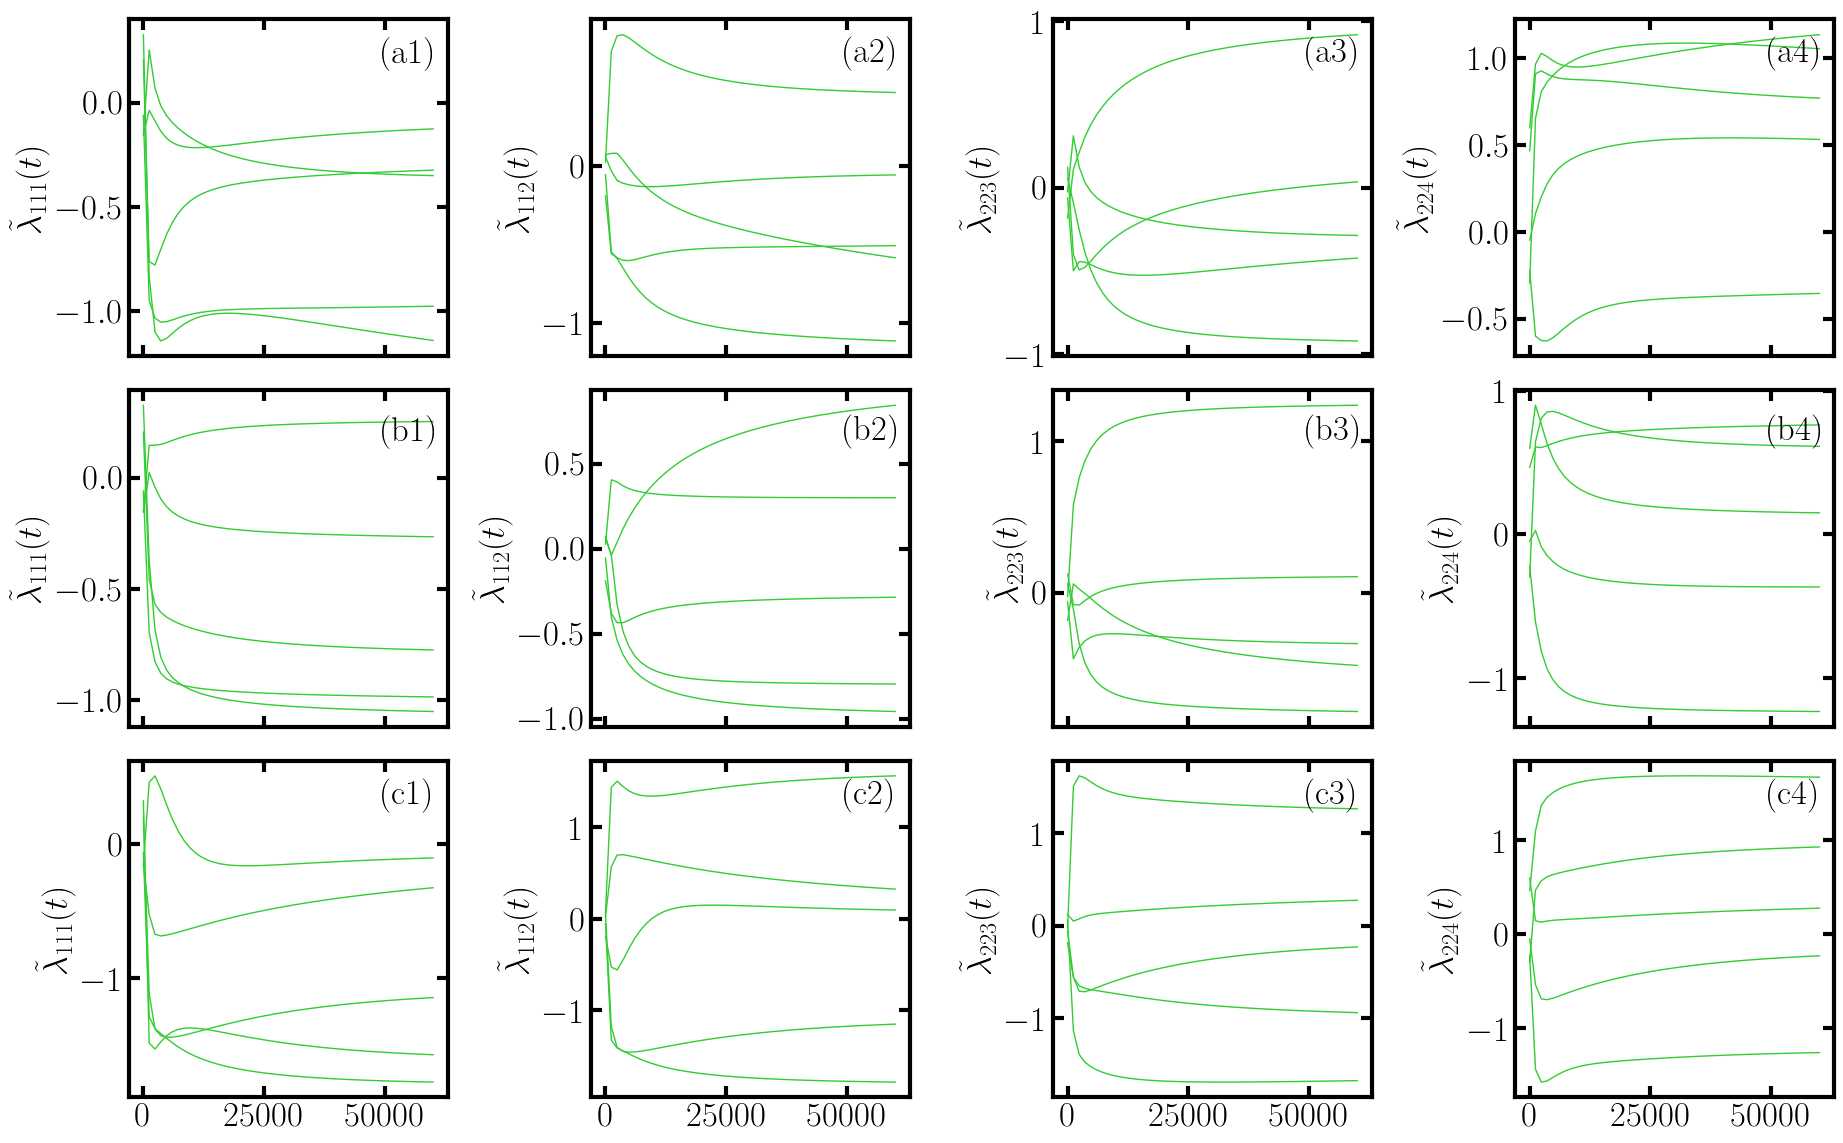

In [147]:
steps2 = int(1e5) + 1
ts2 = np.arange(0, steps2, steps2//50)

path = 'data/training/n4/orth_data/ndata2/L48/'

lda_hist = np.zeros((3, 51, 4, 5))

ys = [(1, -1), (0.4, -1.0), (1, -5)]
np.random.seed(35)
Os = special_ortho_group.rvs(dim=2, size=5)
xs = np.random.randint(0, 20, 5)
for k in range(3):
    y1, y2 = ys[k]
    mu_hist = np.load(os.path.join(path, f'RPASlmuhist_n4L48_{y1}_{y2}.npy'))[:, xs]
    K_hist = np.load(os.path.join(path, f'RPASlKhist_n4L48_{y1}_{y2}.npy'))[::steps2//50, xs]
    
    K_trans = contract('bij, tbjk, blk->tbil', Os, K_hist, Os)
    mu_trans = contract('bip, bjq, tbpqr, bkr->tbijk', Os, Os, mu_hist, Os)
    
    lda_hist[k, :, 0] = mu_trans[:, :, 0, 0, 0]/K_trans[:, :, 0, 0]
    lda_hist[k, :, 1] = mu_trans[:, :, 0, 0, 1]/np.sqrt(K_trans[:, :, 0, 0]*K_trans[:, :, 1, 1])
    lda_hist[k, :, 2] = mu_trans[:, :, 1, 1, 0]/np.sqrt(K_trans[:, :, 0, 0]*K_trans[:, :, 1, 1])
    lda_hist[k, :, 3] = mu_trans[:, :, 1, 1, 1]/K_trans[:, :, 1, 1]

fig, axs = plt.subplots(3, 4, figsize=(22, 14), sharex=True)
cl = ['b', 'r', 'g', 'orange', 'violet']
for k in range(3):
    for i in range(4):
        axs[k, i].plot(ts1, lda_hist[k, :, i], c='limegreen', lw=1)
        axs[k, i].set_ylabel(fr'$\tilde{{\lambda}}_{{{i//2+1}{i//2+1}{i+1}}}(t)$')
        axs[k, i].tick_params(direction='in', length=8, width=3, top='on', right='on')

plt.subplots_adjust(wspace=0.45, hspace=0.1)

xs = [0.24, 0.45, 0.66, 0.87]
ys = [0.85, 0.58, 0.32]

for k in range(12):
    fig.text(xs[k%4], ys[k//4], fr'$\rm ({chr(97+k//4)}{k%4+1})$')

plt.savefig('figures/lda_gauge_poly.pdf', bbox_inches='tight')
plt.show()
plt.close()

## bifurcation plot

In [2]:
def linearJ_2data(Cs, rs, gs):
    J = np.zeros((2, 2))
    J[0, 0] = Cs[0] - 3*gs[0]**2
    J[1, 1] = Cs[1] - 3*gs[1]**2
    J[0, 1] = J[1, 1]*rs[0]
    J[1, 0] = J[0, 0]*rs[1]
    
    return J

In [3]:
def sqrtK_grad(Cs, rs, g1, g2):
    grad1 = -(g1*(g1**2 - Cs[0]) + rs[0] * g2*(g2**2 - Cs[1]))
    grad2 = -(rs[1] * g1*(g1**2 - Cs[0]) + g2*(g2**2 - Cs[1]))
    return grad1, grad2

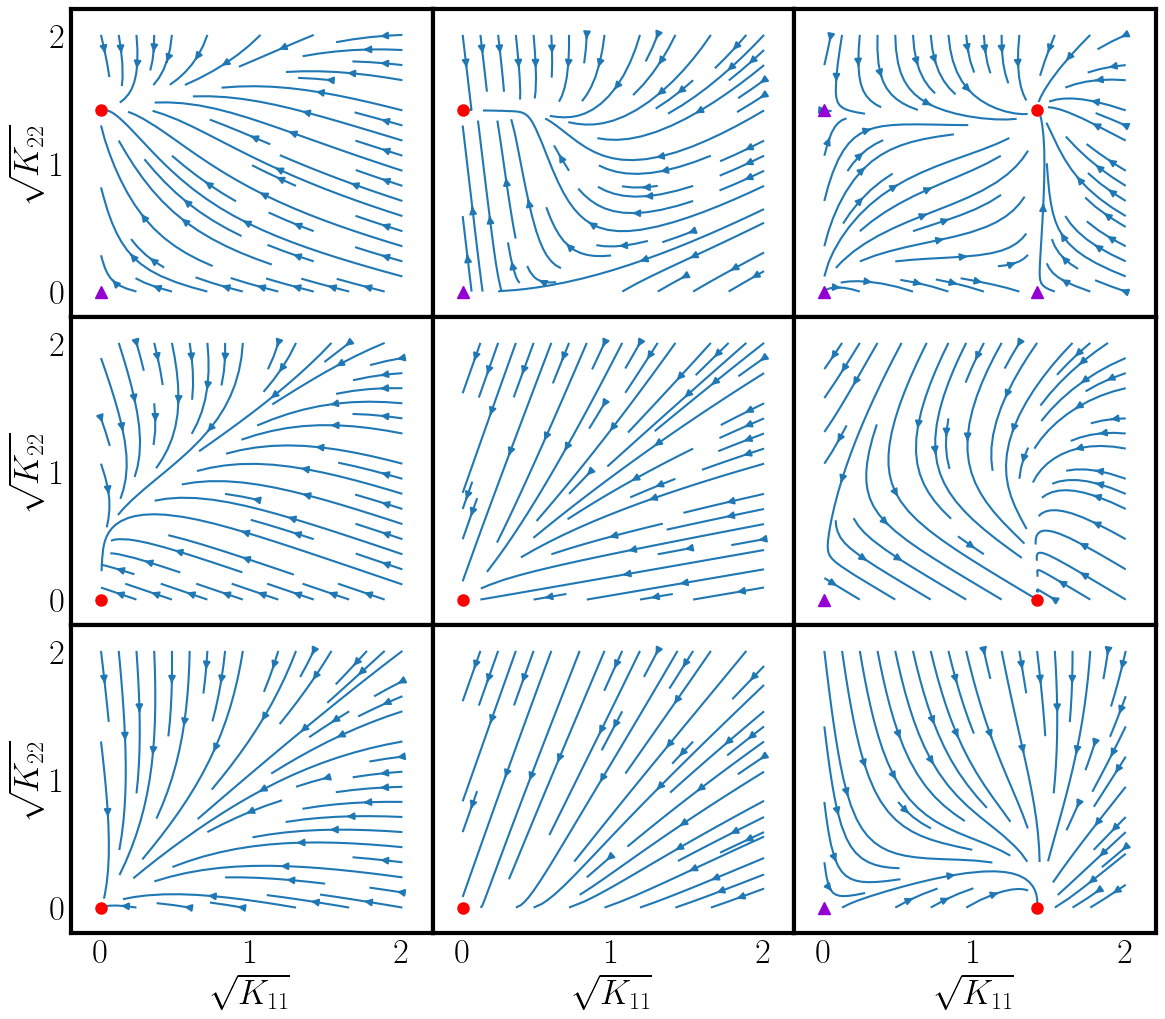

In [4]:
X1, X2 = np.meshgrid(np.linspace(0, 2, 50), np.linspace(0, 2, 50))

Cs = [(-2, 2), (0, 2.), (2, 2), (-2, 0), (0, 0), (2, 0), (-2, -2), (0, -2), (2, -2)]
rs = [(-0.2, -0.3), (-0.1, 0.7), (0.2, -0.4), (-0.3, -0.4), (0.3, 0.2), (0.6, -0.7),
      (-0.1, -0.2), (0.3, 0.4), (-0.1, 0.7)]


fig, axs = plt.subplots(3, 3, figsize=(14, 12), sharex=True, sharey=True)

for i in range(9):
    g1, g2 = sqrtK_grad(Cs[i], rs[i], X1, X2)
    axs[i//3, i%3].streamplot(X1, X2, g1, g2, density=0.6)
    stable_pt = np.sqrt(np.array(Cs[i]) * np.heaviside(Cs[i], 0))
    axs[i//3, i%3].plot(stable_pt[0], stable_pt[1], 'o', markersize=8, c='r')
    axs[i//3, i%3].tick_params(which='both', length=0)
axs[0, 2].plot(np.sqrt(Cs[2][0]), 0, '^', markersize=9, c='darkviolet')
axs[0, 2].plot(0, np.sqrt(Cs[2][1]), '^', markersize=9, c='darkviolet')
axs[0, 2].plot(0, 0, '^', markersize=8, c='darkviolet')
for (i, j) in [(0, 0), (0, 1), (1, 2), (2, 2)]:
    axs[i, j].plot(0, 0, '^', markersize=9, c='darkviolet')

axs[0, 0].set_xlim(-0.2, 2.2)
axs[0, 0].set_ylim(-0.2, 2.2)
for i in range(3):
    axs[2, i].set_xlabel(r'$\sqrt{K_{11}}$')
    axs[i, 0].set_ylabel(r'$\sqrt{K_{22}}$')
plt.subplots_adjust(wspace=0, hspace=0)
plt.savefig('figures/flow_diag.svg', bbox_inches='tight')
plt.show()
plt.close()

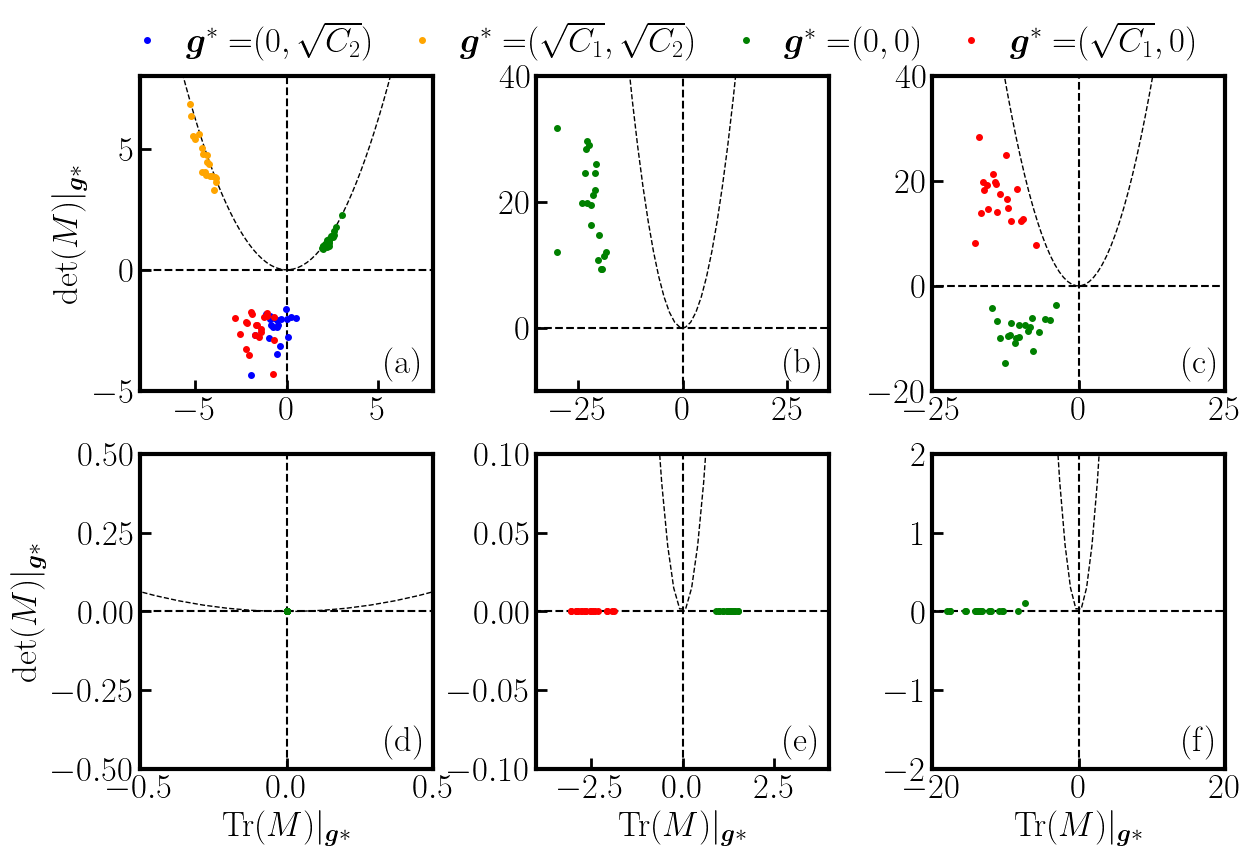

In [293]:
fix_pts = np.zeros((3, 3, 2))
fix_pts[:, 0, 0] = -1
fix_pts[:, 2, 0] = 1
fix_pts[0, :, 1] = 1
fix_pts[2, :, 1] = -1
fix_pts = np.reshape(fix_pts, (9, 2))

Js = np.zeros((6, 20, 9, 2, 2))
for i in range(6):
    ys = ys_list[i]
    epsend = np.load(os.path.join(path, f'RPASlepshist_n4L48_{ys[0]}_{ys[1]}.npy'))[-1]
    Kend = np.load(os.path.join(path, f'RPASlKhist_n4L48_{ys[0]}_{ys[1]}.npy'))[-1]
    muend = np.load(os.path.join(path, f'RPASlmuhist_n4L48_{ys[0]}_{ys[1]}.npy'))[-1]
    
    for k in range(20):
        ldaend = ldaUT(Kend[k], muend[k])
        Cs = np.around(np.diag(Kend[k]) - 2*ldaend[range(2), range(2), range(2)]*epsend[k], 1)
        rs = ldaend[0, 0, 1]/ldaend[1, 1, 1], ldaend[1, 1, 0]/ldaend[0, 0, 0]
        for j in range(9):
            Js[i, k, j] = linearJ_2data(Cs, rs, fix_pts[j]*np.sqrt(Kend[k, range(2), range(2)]))

trJs = contract('mbpii->mbp', Js)
detJs = np.linalg.det(Js)

fig, axs = plt.subplots(2, 3, figsize=(14, 9))
phy_choices = [(1, 2, 4, 5), (4, ), (4, 5), (4, ), (4, 5), (4, )]
labels = [r'$(-\sqrt{C_1},\sqrt{C_2})$', r'$(0,\sqrt{C_2})$', r'$(\sqrt{C_1},\sqrt{C_2})$',
          r'$(-\sqrt{C_1},0)$', r'$(0, 0)$', r'$(\sqrt{C_1},0)$']
cl = ['', 'b', 'orange', '', 'g', 'r']
for i in range(6):
    xlim = np.ceil(np.max(np.abs(trJs[i, :, phy_choices[i]])))
    if i == 3:
        xlim = 2
    axs[i//3, i%3].plot(np.linspace(-xlim, xlim, 50), np.linspace(-xlim, xlim, 50)**2/4, '--', lw=1, c='k')
    axs[i//3, i%3].hlines(0, -xlim-10, xlim+10, ls='--', color='k')
    axs[i//3, i%3].vlines(0, -30, xlim**2/4, ls='--', color='k')

    for j in phy_choices[i]:
        axs[i//3, i%3].plot(trJs[i, :, j], detJs[i, :, j], 'o', c=cl[j], markersize=4, label=r'${\bm g^*}=$'+f'{labels[j]}')
axs[0, 0].legend(ncol=4, columnspacing=0.4, loc='lower left', bbox_to_anchor=(-0.2, 0.95), framealpha=0, handletextpad=0.1)

for i in range(3):
    axs[1, i].set_xlabel(r'${\rm Tr}(M)|_{\bm g*}$')
for i in range(2):
    axs[i, 0].set_ylabel(r'${\rm det}(M)|_{\bm g*}$')

axs[0, 0].set_ylim(-5, 8)
axs[0, 0].set_xlim(-8, 8)
axs[0, 1].set_ylim(-10, 40)
axs[0, 1].set_xlim(-35, 35)
axs[0, 2].set_ylim(-20, 40)
axs[0, 2].set_xlim(-25, 25)
axs[1, 0].set_ylim(-0.5, 0.5)
axs[1, 0].set_xlim(-0.5, 0.5)
axs[1, 1].set_ylim(-0.1, 0.1)
axs[1, 1].set_xlim(-4, 4)
axs[1, 2].set_ylim(-2, 2)
axs[1, 2].set_xlim(-20, 20)

for i in range(6):
    axs[i//3, i%3].tick_params(length=8, width=2, direction='in')

xs = [0.3, 0.585, 0.87]
for i in range(3):
    fig.text(xs[i], 0.55, r'$\rm (%s)$'%(chr(97+i)))
    fig.text(xs[i], 0.13, r'$\rm (%s)$'%(chr(100+i)))

plt.subplots_adjust(hspace=0.2, wspace=0.35)
plt.savefig('figures/poincare_diagram.pdf', bbox_inches='tight')
plt.show()
plt.close()

## spectrum of loss function hessian

In [175]:
path = 'data/training/n4/orth_data/ndata2/L48'
ys_list = [(0.3, -0.5), (5, -6), (0.4, -5.0), (1, -1), (0.4, -1.0), (1, -5)]
idx = [12, 15, 11, 2, 5, 1]

vals = np.zeros((6, 48))
for k in range(6):
    if k < 6:
        s = f'{ys_list[k][0]}_{ys_list[k][1]}'
    else:
        s = f'{ys_list[k][0]}_{ys_list[k][1]}_{ys_list[k][2]}'
        path = 'data/training/n4/orth_data/ndata3/L48'
    epss = np.load(os.path.join(path, f'RPASlepshist_n4L48_{s}.npy'))[-1, idx[k]]
    Js = np.load(os.path.join(path, f'RPASlJhist_n4L48_{s}.npy'))[-1, idx[k]]
    Hs = np.load(os.path.join(path, f'RPASlHhist_n4L48_{s}.npy'))[-1, idx[k]]

    Ms = contract('ai, aj->ij', Js, Js) + contract('a, aij->ij', epss, Hs)

    vals[k] = np.linalg.eigvalsh(Ms)

[-3.60822483e-14  7.50621787e-13]
[-4.  5.]
[-1.16541776e-11  4.00000000e+00]
[-0.02888452  0.02899617]
[-0.00035087  0.00917195]
[-0.01656884  4.00000016]


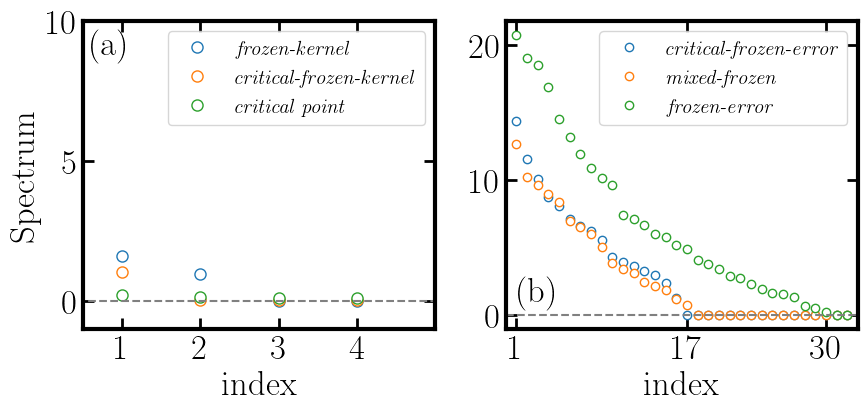

In [307]:
labels = ['\it frozen-kernel', '\it critical-frozen-kernel', '\it critical point',
    '\it critical-frozen-error', '\it mixed-frozen', '\it frozen-error']

fig, axs = plt.subplots(1, 2, figsize=(10, 4))

cc = 0
for k in [0, 4, 3]:
    axs[0].plot(np.arange(1, 5), vals[k][::-1][:4], 'o', mfc='white', markersize=8,
        label=labels[cc])
    cc += 1
for k in [5, 2, 1]:
    y1, y2 = ys_list[k]
    axs[1].plot(np.arange(1, 33), vals[k][::-1][:32], 'o', mfc='white', markersize=6,
        label=labels[cc])
    cc += 1
axs[0].hlines(0, xmin=0, xmax=6, ls='--', color='grey')
axs[1].hlines(0, xmin=0, xmax=33, ls='--', color='grey')
axs[1].set_xlim(0, 33)
axs[0].set_xlim(0.5, 5)
axs[1].set_xticks([1, 17, 30])
axs[0].set_xticks([1, 2, 3, 4])
axs[0].set_ylim(-1, 10)
axs[0].set_ylabel(r'$\rm Spectrum$')

for i in range(2):
    axs[i].legend(fontsize=15)
    axs[i].set_xlabel(r'$\rm index$')
    axs[i].tick_params(top=True, right=True, length=8, width=2, direction='in')

axs[0].text(0.6, 8.8, r'$\rm (a)$')
axs[1].text(1.2, 1, r'$\rm (b)$')

plt.savefig('figures/spectrum.pdf', bbox_inches='tight')
plt.show()
plt.close()

In [128]:
path = 'data/training/n4/orth_data/ndata2/L48'
ys_list = [(0.3, -0.5), (5, -6), (0.4, -5.0), (1, -1), (0.4, -1.0), (1, -5), (0.4, 1.0, -5.0)]
path = 'data/training/n4/orth_data/ndata2/L48'

k = 2
s = f'{ys_list[k][0]}_{ys_list[k][1]}'

epss = np.load(os.path.join(path, f'RPASlepshist_n4L48_{s}.npy'))[-1]
Js = np.load(os.path.join(path, f'RPASlJhist_n4L48_{s}.npy'))[-1]
Hs = np.load(os.path.join(path, f'RPASlHhist_n4L48_{s}.npy'))[-1]


Ms = (contract('mai, maj->maij', Js, Js) + contract('ma, maij->maij', epss, Hs))[12]

print(np.linalg.matrix_rank(Ms[0], tol=1e-6), np.linalg.matrix_rank(Ms[1], tol=1e-6))

_, v1 = np.linalg.eigh(Ms[0])
_, v2 = np.linalg.eigh(Ms[1])

A = np.hstack((v1[:, -1:], -v2[:, -16:]))
print(A.shape)
_, S, _ = np.linalg.svd(A)
S

1 16
(48, 17)


array([1.20979634, 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 0.73238843])